# Advanced lane finding using OpenCV

## 1. Camera Calibration

Our initial goal is to obtain a transformation matrix to map a 3D object to a 2D image and a set of coefficients representative of the distortion due to the optics and setting of the image capturing device. Let's import first the main libraries used for this project:


In [1]:
import time
import cv2 
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import glob
#qt inline
%matplotlib inline

nx = 9 # number of inside corners in x
ny = 6 # number of inside corners in y

# Make a list of calibration images
images = glob.glob('camera_cal/calibration*.jpg')

The camera calibration function receives a set of images from a source and uses cv2.calibrateCamera to obtain the calibration matrix and distortion coefficients

In [2]:
def camera_calibration(images, nx, ny):
    
    # Prepare object points in the format (0,0,0), (0,1,0),..., (8,8,0)
    objp =  np.zeros((nx*ny, 3), np.float32)
    objp[:,:2] = np.mgrid[0:nx, 0:ny].T.reshape(-1,2) # x and y coordinates. z value is zero for all points

    # Arrays to store object and image points for all the images
    objpoints = [] # 3D points in real world space
    imgpoints = [] # 2D points in image plane
    
    # Step through the list and search for chess corners
    count = 1
    for fname in images:
        img = cv2.imread(fname)
        
        # Convert image to gray scale
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

        # Find the chessboard corners
        ret, corners = cv2.findChessboardCorners(gray, (nx,ny), None)
        
        if ret ==  True:
            objpoints.append(objp)
            imgpoints.append(corners)
        
    ret, mtx, dist, rvec, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None)
    
    return mtx, dist

mtx , dist = camera_calibration(images,nx,ny)

# 2. Distortion correction

The following procedure distort the image and apply color/gradient threshold to clearly identify the lane lines

In [3]:
def undistort_image(img, mtx, dist):
    #1. Undistort using mtx and dist
    undist = cv2.undistort(img, mtx, dist, None, mtx)
        
    return undist


## Example of the results so far.

Let's undistort a chessboard image using the matrix and distortion coefficients obtained after camera calibration.

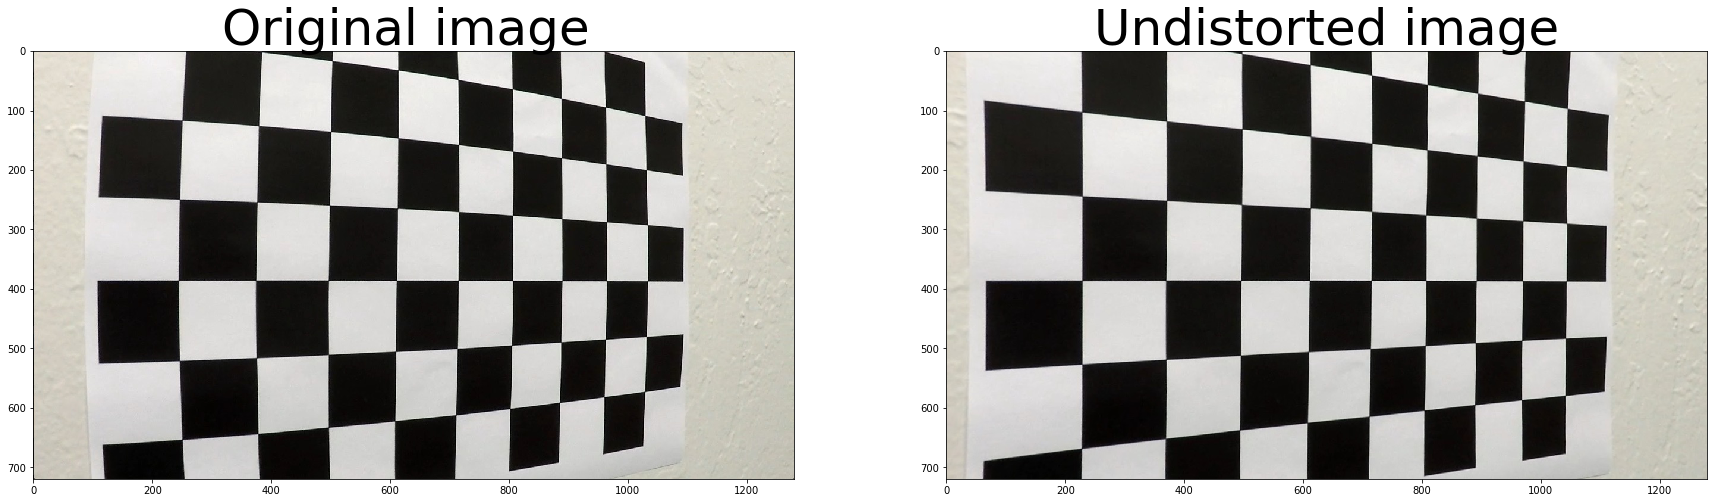

In [4]:
img = mpimg.imread('camera_cal/calibration5.jpg')

undist = undistort_image(img, mtx, dist)

# Plotting thresholded images
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(30,10))
ax1.set_title('Original image ', fontsize=50)
ax1.imshow(img)

ax2.set_title('Undistorted image', fontsize=50)
ax2.imshow(undist)

# 3. Color and gradient thresholds

In [5]:
def threshold_function(img):
    
    # Transforms image to the HLS color space 
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)# Compute a binary thresholded image where yellow is isolated from HLS components
    
    # Define saturation and lightness channel in separata variables
    s_channel = hls[:,:,2] # Takes the saturation channel from the image in HLS color space
    l_channel = hls[:,:,1] # Takes the lightness channel from the image in HLS color space

    
    # Threshold over gradient: Sobel x in the lightness channel 
    sobelx = cv2.Sobel(l_channel, cv2.CV_64F, 1, 0) # Take the derivative in the x direction
    abs_sobelx = np.absolute(sobelx)
    scaled_sobelx = np.uint8(255*abs_sobelx/np.max(sobelx))
    
    #Threshold x gradient
    thresh_min = 25
    thresh_max = 255
    sxbinary = np.zeros_like(scaled_sobelx)
    sxbinary[(scaled_sobelx >= thresh_min) & (scaled_sobelx < thresh_max)] = 1
    
    # Threshold over color: HSL color space
    # Compute a binary thresholded image where yellow is isolated from HLS components
    hls_yellow_bin = np.zeros_like(hls[:,:,0])
    hls_yellow_bin[
                        ((hls[:,:,0] >= 15) & (hls[:,:,0] <= 35))
                         & ((hls[:,:,1] >= 30) & (hls[:,:,1] <= 204))
                         & ((hls[:,:,2] >= 115) & (hls[:,:,2] <= 255))                
                      ] = 1
    
    # Compute a binary thresholded image where white is isolated from HLS components
    hls_white_bin = np.zeros_like(hls[:,:,0])
    hls_white_bin[
                        ((hls[:,:,0] >= 0) & (hls[:,:,0] <= 255))
                         & ((hls[:,:,1] >= 200) & (hls[:,:,1] <= 255))
                         & ((hls[:,:,2] >= 0) & (hls[:,:,2] <= 255))                
                      ] = 1
    
    # Now combine both
    s_binary = np.zeros_like(hls[:,:,0])
    s_binary[(hls_yellow_bin == 1) | (hls_white_bin == 1)] = 1
    
    '''
    s_thresh_min = 140 
    s_thresh_max = 255
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= s_thresh_min)&( s_channel < s_thresh_max)] = 1
    '''
    
    # Stack both channels to see their individual contributions as blue (saturation channel) and green (sobel x)
    color_binary = np.dstack((np.zeros_like(s_channel), sxbinary, s_binary ))*255
    
    # Combine the two binary thresholds
    combined_binary = np.zeros_like(s_binary)
    combined_binary[(sxbinary==1) | (s_binary==1)] = 1
    
    return combined_binary


## Color and gradient thresholds output

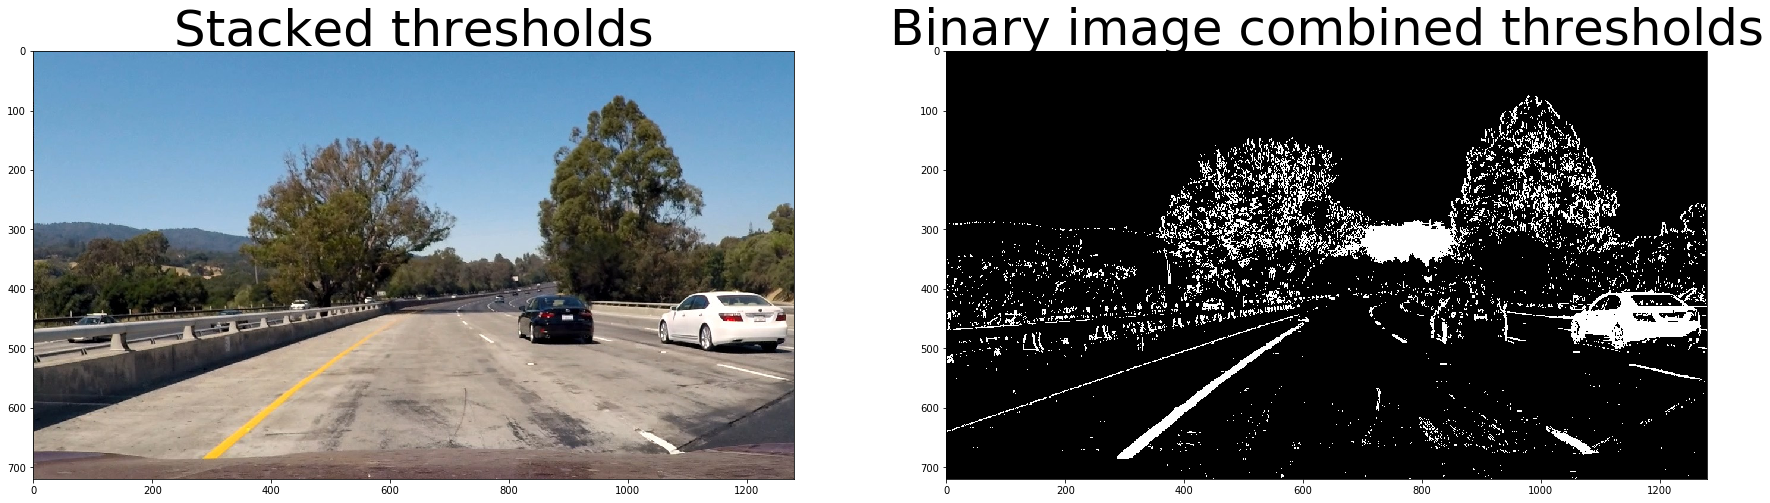

In [6]:
img = mpimg.imread('test_images/test1.jpg')

binary_output=threshold_function(img)

# Plotting thresholded images
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(30,10))
ax1.set_title('Stacked thresholds', fontsize=50)
ax1.imshow(img)

ax2.set_title('Binary image combined thresholds', fontsize=50)
ax2.imshow(binary_output, cmap='gray')
plt.show()

# 4. Perspective transform

Based on previous modifications of the original image now we apply a perspective transform. Our goal is to see the real nature of the lanes as seen from the top down. Lanes should be parallel and clear on the final result

In [7]:
def perspective_transform(img):
    
    # x and y image sizes
    img_size = (img.shape[1], img.shape[0])

    offset_left = 245 # offset in x direction at the left side of the warped image
    offset_right = 285 # offset in the x directions at the right side of the warped image

    #b. Define four source points src=np.float32([[,],[,],[,],[,]])
    src = np.float32([[206,img_size[1]], [582,460], [701,460], [1100,img_size[1]]])

    #c. Define four destination points dst=np.float32([[,],[,],[,],[,]])
    dst = np.float32([[offset_left,img_size[1]],[offset_left,0],[img_size[0]-offset_right,0],[img_size[0]-offset_right,img_size[1]]])

    #d. Get perspective transform M using the source and destination points
    M = cv2.getPerspectiveTransform(src, dst)
    
    #e. Get the inverse perspective transform Minv using the destination and source points
    Minv = cv2.getPerspectiveTransform(dst,src)
    
    #f. Warp the image captured by the camera using this transform to get an accurate depiction of the 2D image
    warped = cv2.warpPerspective(img, M,  img_size, flags=cv2.INTER_LINEAR)
    #options: cv2.INTER_NEAREST
    
    return warped, M, Minv


## Implementation of the perspective transform

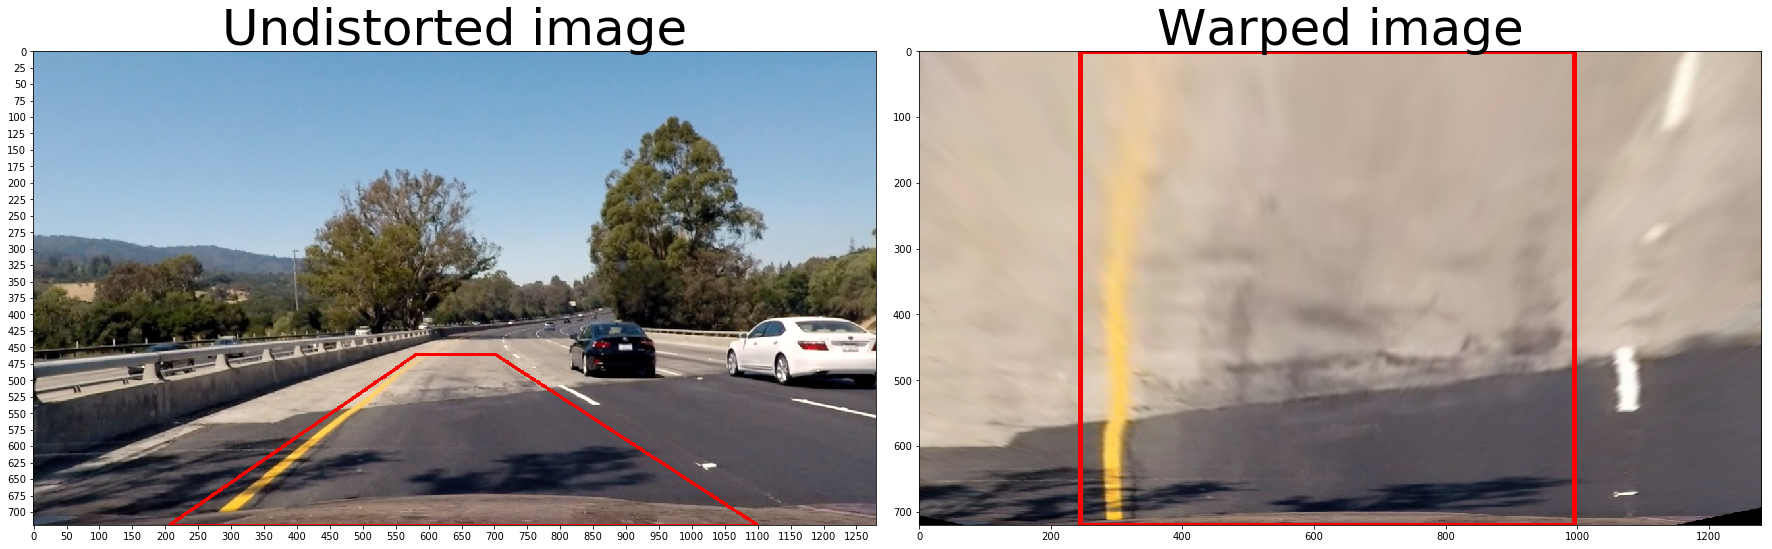

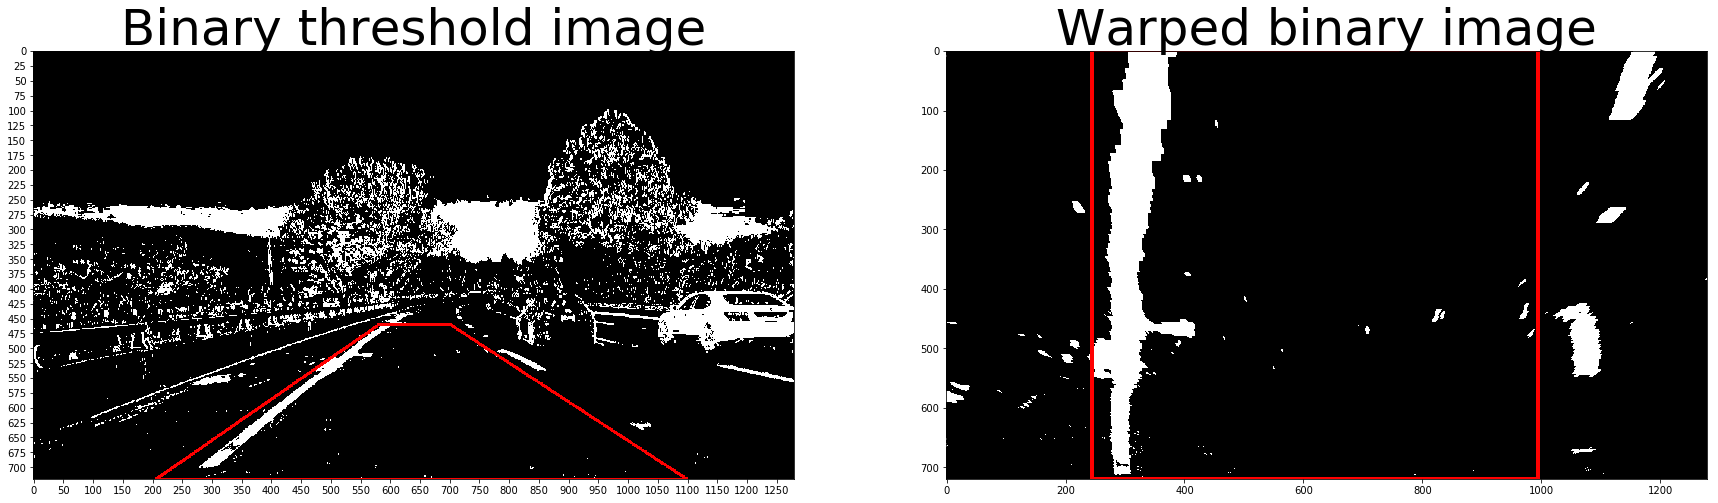

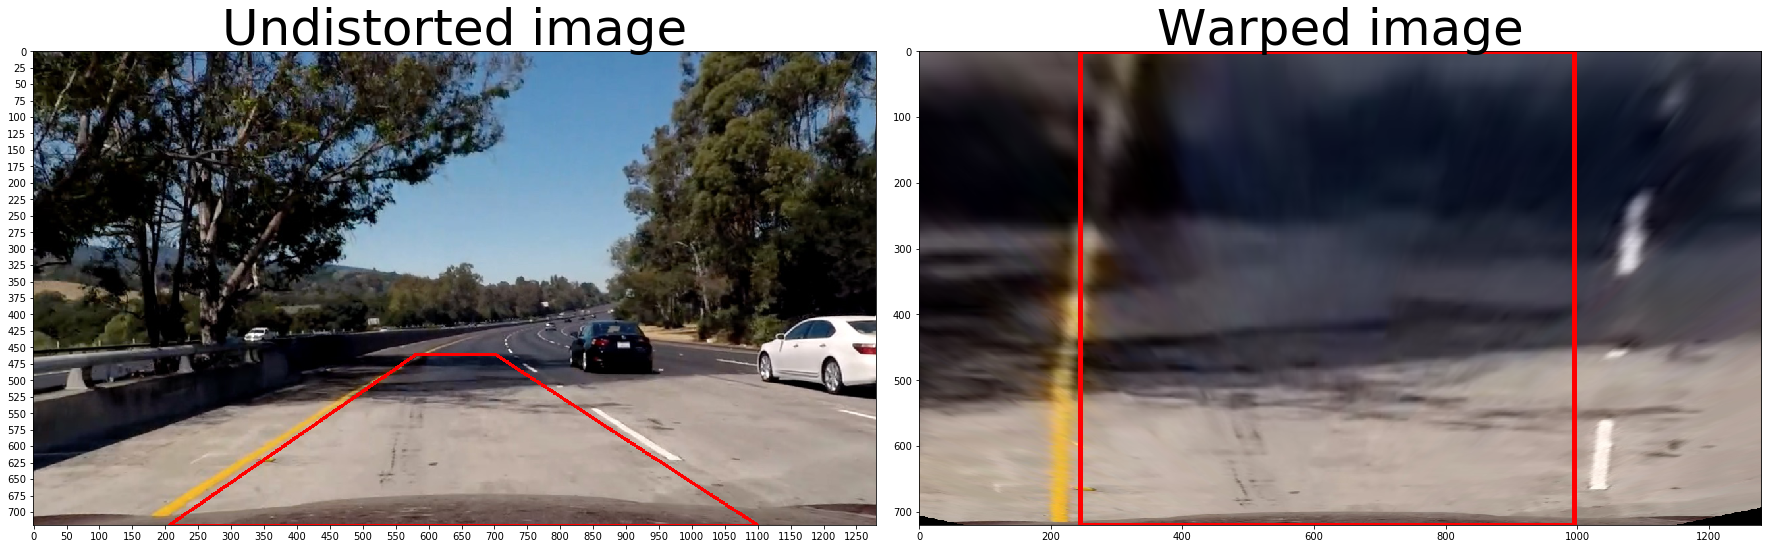

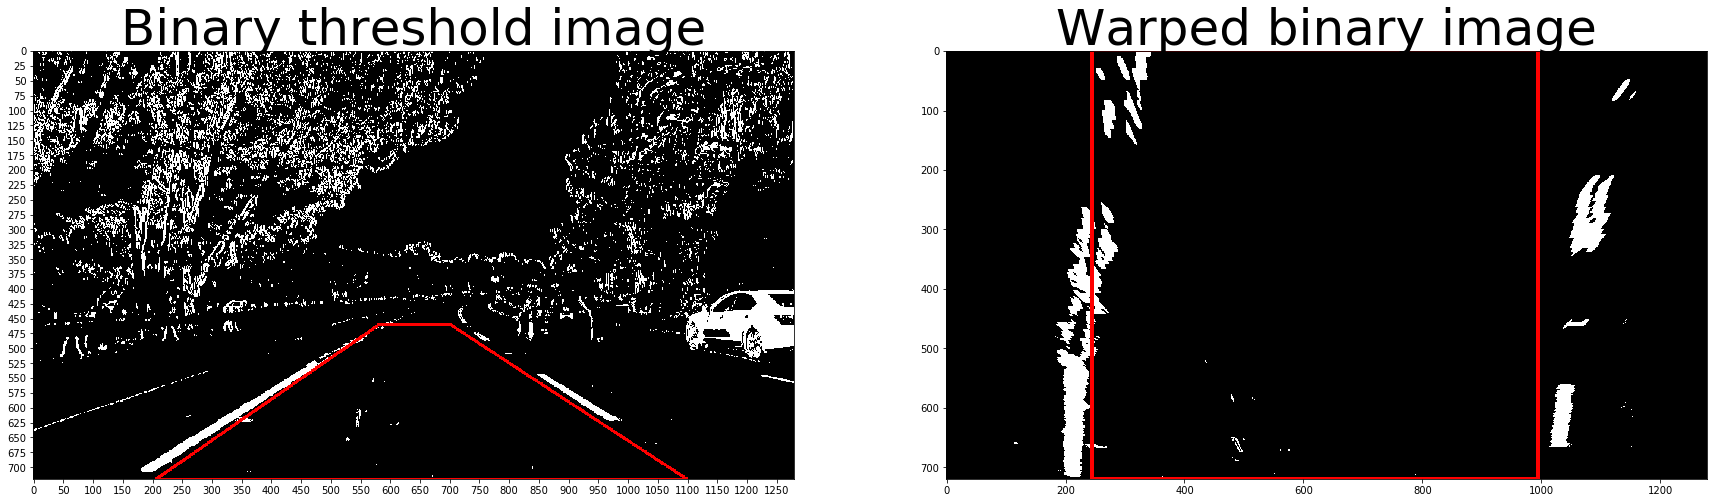

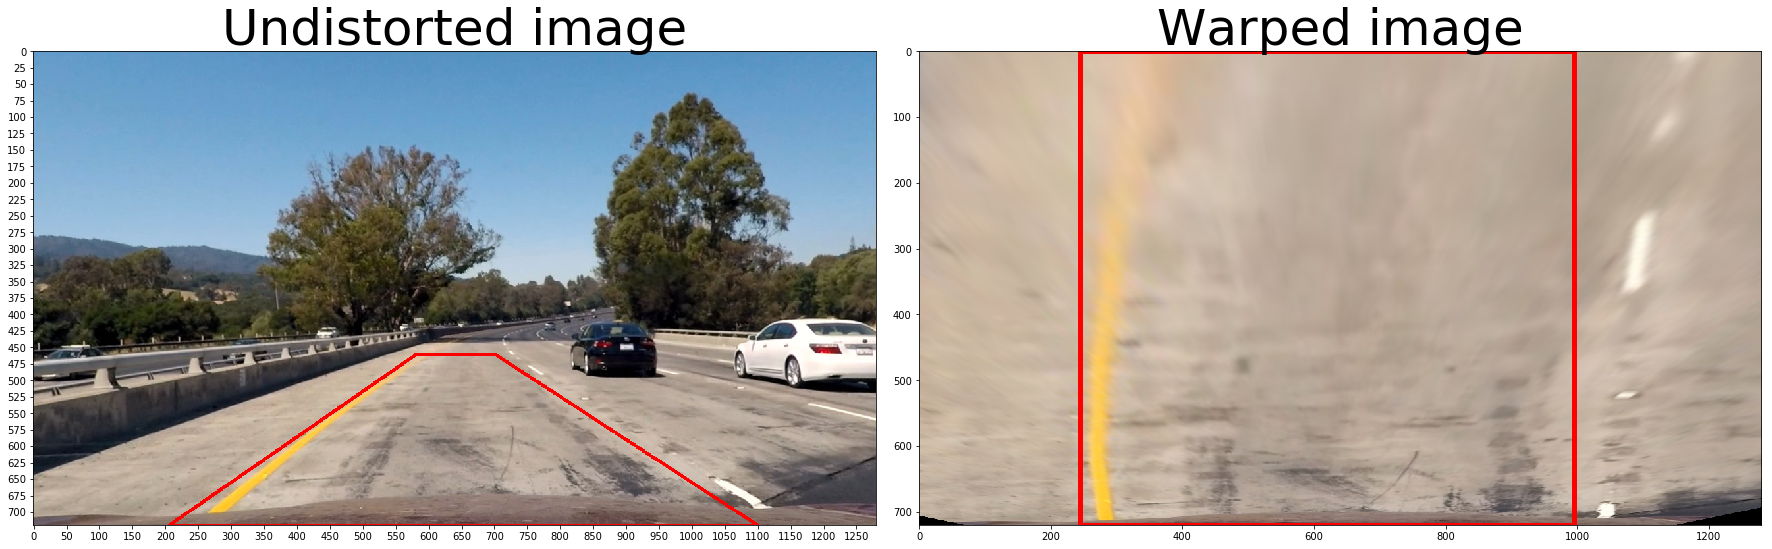

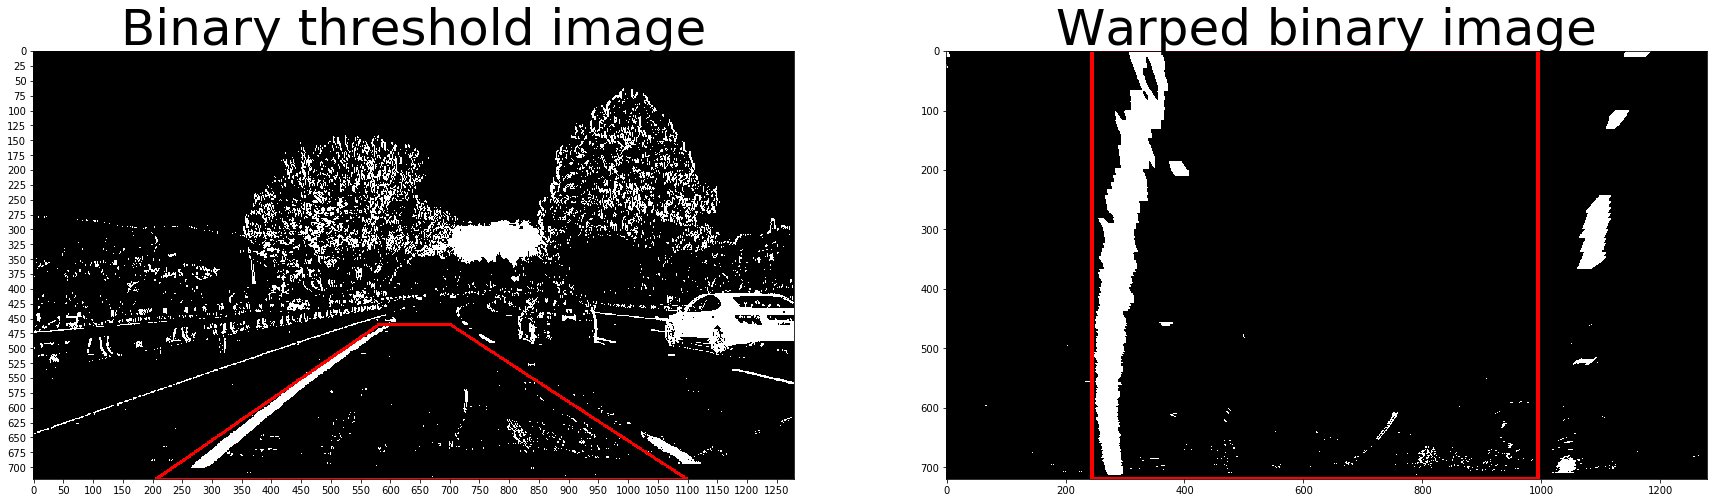

In [8]:
#images = glob.glob('test_images/test*.jpg')
images = ['test_images/test4.jpg','test_images/test5.jpg','test_images/test1.jpg']#'test_images/test5.jpg']#'test_images/straight_lines1.jpg']

for fname in images:
    img = mpimg.imread(fname)

    # Undistorted image
    undist = undistort_image(img, mtx, dist)
    
    # Combine binary image after the application of gradient in x direction and saturation channel thresholds
    img_thresh = threshold_function(undist)
    
    # x and y image sizes
    img_size = (img.shape[1], img.shape[0])
    offset_left = 245 # offset in x direction at the left side of the warped image
    offset_right = 285 # offset in the x directions at the right side of the warped image
    #b. Define four source points src=np.float32([[,],[,],[,],[,]])
    src = np.float32([[206,img_size[1]], [582,460], [701,460], [1100,img_size[1]]])
    #c. Define four destination points dst=np.float32([[,],[,],[,],[,]])
    dst = np.float32([[offset_left,img_size[1]],[offset_left,0],[img_size[0]-offset_right,0],[img_size[0]-offset_right,img_size[1]]])

    # Warped image using perspective transform over the undistorted image
    warped, perspective_M, Minv = perspective_transform(undist)
    
    # Warped binary image using perspective transform over the combined threshold binary image
    binary_warped, perspective_M, Minv = perspective_transform(img_thresh)
    
    
    binary_lines = np.dstack((img_thresh, img_thresh, img_thresh))*255

    for i in range(len(src)):
        if i==(len(src)-1):
            cv2.line(undist,tuple(src[0]), tuple(src[i]),(255,0, 0), thickness=3, lineType=8)
            cv2.line(binary_lines,tuple(src[0]), tuple(src[i]),(255,0, 0), thickness=3, lineType=8)
        else:
            cv2.line(undist,tuple(src[i]), tuple(src[i+1]),(255,0, 0), thickness=3, lineType=8)
            cv2.line(binary_lines,tuple(src[i]), tuple(src[i+1]),(255,0, 0), thickness=3, lineType=8)
    
    warped_lines = np.dstack((binary_warped, binary_warped, binary_warped))*255
    
    for i in range(len(dst)):
        if i==(len(dst)-1):
            cv2.line(warped,tuple(dst[0]), tuple(dst[i]),(255,0, 0), thickness=5, lineType=8)
            cv2.line(warped_lines,tuple(dst[0]), tuple(dst[i]),(255,0, 0), thickness=5, lineType=8)
        else:
            cv2.line(warped,tuple(dst[i]), tuple(dst[i+1]),(255,0, 0), thickness=5, lineType=8)
            cv2.line(warped_lines,tuple(dst[i]), tuple(dst[i+1]),(255,0, 0), thickness=5, lineType=8)
        
    
    # Plotting undistorted image and warped image
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24,9))
    f.tight_layout()
    ax1.set_title('Undistorted image', fontsize=50)
    ax1.set_xticks(np.arange(0, undist.shape[1], step=50))
    ax1.set_yticks(np.arange(0, undist.shape[0], step=25))
    ax1.imshow(undist)
    ax2.set_title('Warped image', fontsize= 50)
    ax2.imshow(warped)
    plt.subplots_adjust(left = 0., right = 1, top=0.9, bottom = 0.)
    plt.show()
    # Plotting binary threshold image and warped binary image
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(30,10))
    ax1.set_title('Binary threshold image', fontsize=50)
    ax1.set_xticks(np.arange(0, undist.shape[1], step=50))
    ax1.set_yticks(np.arange(0, undist.shape[0], step=25))
    ax1.imshow(binary_lines)

    ax2.set_title('Warped binary image', fontsize=50)
    ax2.imshow(warped_lines)

# 5. Detect lane lines

Here we find the lane lines using histograms and sliding window techniques. We start from the bottom of the image and move upwards trying to map peaks of the histogram to the most populated active pixels in each window. The following segment shows the functions used to detect the lane lines.

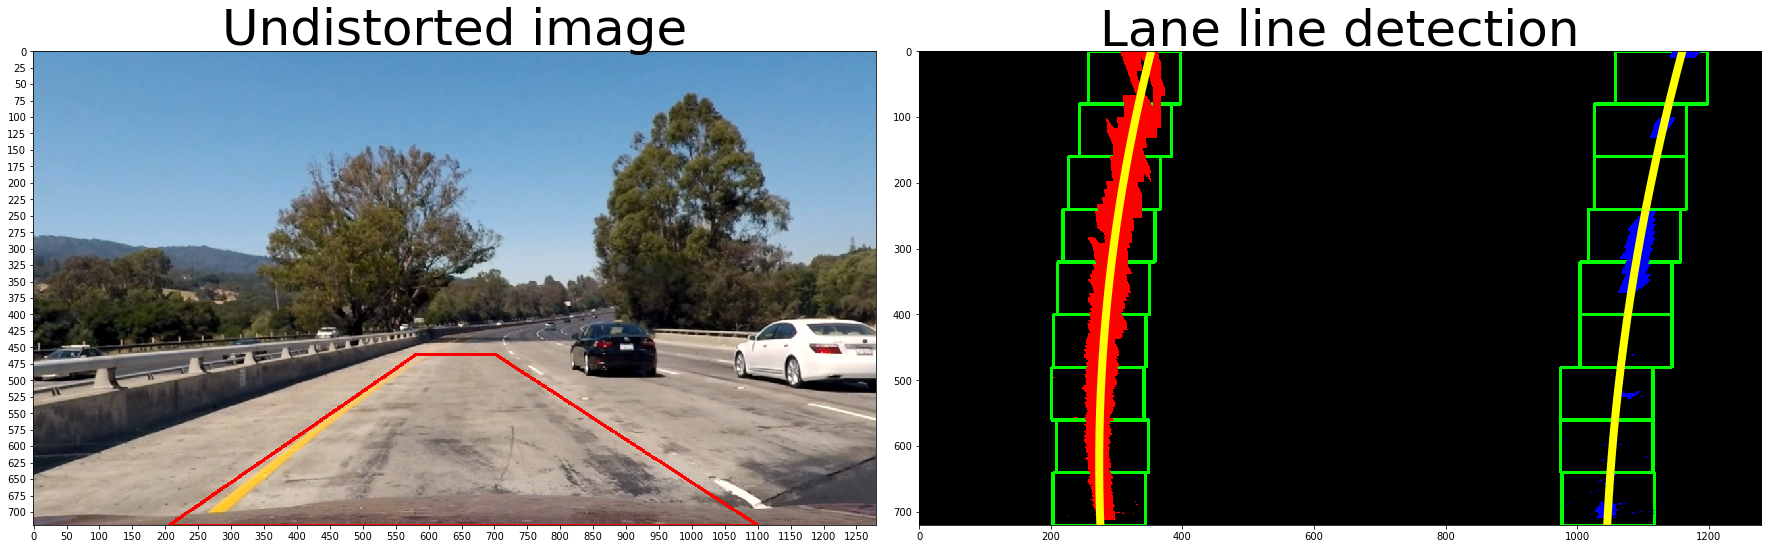

In [9]:
# Find a set of pixels part of the left and right lane when no previous lanes have been identified
def find_lane_pixels_prior(binary_warped):
    # Take a histogram of the bottom half of the image
    histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)
    # Create an output image to draw on and visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))
    
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]//2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # HYPERPARAMETERS
    # Choose the number of sliding windows
    nwindows = 9
    # Set the width of the windows +/- margin
    margin = 70
    # Set minimum number of pixels found to recenter window
    minpix = 40

    # Set height of windows - based on nwindows above and image shape
    window_height = np.int(binary_warped.shape[0]//nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated later for each window in nwindows
    leftx_current = leftx_base
    rightx_current = rightx_base

    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        ### 1. Find the four boundaries of the left and right window ###
        win_xleft_low = leftx_current - margin 
        win_xleft_high = leftx_current + margin  
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),
        (win_xleft_high,win_y_high),(0,255,0), 4) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),
        (win_xright_high,win_y_high),(0,255,0), 4) 
        
        ### 2. Identify the nonzero pixels in x and y within the window ###
        good_left_inds = []
        good_right_inds = []
       
        for i in range(len(nonzerox)):
            
            if nonzerox[i]> binary_warped.shape[1]:
                print(i, nonzerox[i])
                continue
            # Add nonzero pixels within the windows in left line
            if (nonzerox[i]<win_xleft_high and nonzerox[i]>=win_xleft_low) and \
                (nonzeroy[i]<win_y_high and nonzeroy[i]>=win_y_low):    
                good_left_inds += [i]
            # Add nonzero pixels within the windows in right line    
            if (nonzerox[i]<win_xright_high and nonzerox[i]>=win_xright_low) and \
                (nonzeroy[i]<win_y_high and nonzeroy[i]>=win_y_low):    
                good_right_inds += [i]
        
        
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        
        
        ### 3. If you found > minpix pixels, recenter next window ###
        ### (`right` or `leftx_current`) on their mean position ###
        # Left window
        nleft = 0
        leftx_sum = 0
        for i in good_left_inds:
            nleft +=  1
            leftx_sum += nonzerox[i]
        if nleft > minpix:
            leftx_current =  leftx_sum//nleft

        # Right window
        nright = 0
        rightx_sum = 0
        for i in good_right_inds:
            nright +=  1
            rightx_sum += nonzerox[i]
        if nright > minpix:
            rightx_current =  rightx_sum//nright
    

    # Concatenate the arrays of indices (previously was a list of lists of pixels)
    try:
        left_lane_inds = np.concatenate(left_lane_inds)
        right_lane_inds = np.concatenate(right_lane_inds)
    except ValueError:
        # Avoids an error if the above is not implemented fully
        print('Something went wrong with the concatenation step!\n')
        pass
    
    # Extract left and right line pixel positions
    leftx = nonzerox[np.uint(left_lane_inds)]
    lefty = nonzeroy[np.uint(left_lane_inds)] 
    rightx = nonzerox[np.uint(right_lane_inds)]
    righty = nonzeroy[np.uint(right_lane_inds)]

    return leftx, lefty, rightx, righty, out_img
    
#Fit a set of pixel coordinates found in a image to a 2nd degree polynomial
def fit_polynomial(binary_warped):
    # Find our lane pixels first
    leftx, lefty, rightx, righty, out_img = find_lane_pixels_prior(binary_warped)
    
    # Define conversions in x and y from pixels space to meters
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/750 # meters per pixel in x dimension
    
    ### 4. Fit a second order polynomial to each using `np.polyfit` ###
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    

    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    try:
        left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
        right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    except TypeError:
        # Avoids an error if `left` and `right_fit` are still none or incorrect
        print('The function failed to fit a line!')
        left_fitx = 1*ploty**2 + 1*ploty
        right_fitx = 1*ploty**2 + 1*ploty

    left_fit_cr = np.polyfit(ym_per_pix*ploty, xm_per_pix*left_fitx, 2)
    right_fit_cr = np.polyfit(ym_per_pix*ploty, xm_per_pix*right_fitx, 2)
    
    ## Visualization ##
    # Colors in the left and right lane regions
    out_img[lefty, leftx] = [255, 0, 0]
    out_img[righty, rightx] = [0, 0, 255]

    # Plots the left and right polynomials on the lane lines
    ax2.plot(left_fitx, ploty,linewidth=8, color='yellow',)
    ax2.plot(right_fitx, ploty,linewidth=8, color='yellow')
    
    
    # Here we calculate the left and right lanes x coordinate at the bottom of the undistorted image
    # Create an image to draw the lines on
    warp_zero = np.zeros_like(binary_warped).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))
    
    left_fitx = np.uint(np.abs(left_fitx))
    right_fitx = np.uint(np.abs(right_fitx))
    
    # Get the indices for which the fix <= limit
    left_indices = np.argwhere(left_fitx < binary_warped.shape[1])
    right_indices = np.argwhere(right_fitx < binary_warped.shape[1])
        
    color_warp[np.uint(ploty[left_indices]),left_fitx[left_indices]] = [0,255,0]
    color_warp[np.uint(ploty[right_indices]),right_fitx[right_indices]] = [0,255,0]
    
     # Warp the blank back to original image space using inverse perspective matrix (Minv)
    color_unwarped = cv2.warpPerspective(color_warp, Minv, (undist.shape[1], undist.shape[0])) 
    
    single_unwarped = color_unwarped[:,:,1]
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = single_unwarped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])

    # Get the indices fro which the y value is max in the binary image
    max_y_indices = np.argwhere(nonzeroy == np.amax(nonzeroy))
    # Values of x at the bottom of the image in the region between the lanes
    xvals = nonzerox[max_y_indices]
    
    left_x = np.min(xvals)
    right_x = np.max(xvals)
    
    return left_fitx, right_fitx, left_fit, right_fit, left_fit_cr, right_fit_cr, left_x, right_x, out_img

# Plotting undistorted image and warped image
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24,9))
f.tight_layout()

left_fitx, right_fitx, left_fit, right_fit, left_fit_cr, right_fit_cr, left_x, right_x, out_img= fit_polynomial(binary_warped)

ax1.set_title('Undistorted image', fontsize=50)
ax1.set_xticks(np.arange(0, undist.shape[1], step=50))
ax1.set_yticks(np.arange(0, undist.shape[0], step=25))
ax1.imshow(undist)
ax2.set_title('Lane line detection', fontsize= 50)
ax2.imshow(out_img)
plt.subplots_adjust(left = 0., right = 1, top=0.9, bottom = 0.)
plt.show()

# 6. Determine the lane curvature and vehicle position


In [10]:
def curvature_position_estimation(binary_warped,left_fit_cr, right_fit_cr, left_x, right_x):
    '''
    Calculates the curvature of polynomial functions and the 
    vehicle position from the center of the lanes in meters.
    '''
    # Define conversions in x and y from pixels space to meters
    ym_per_pix = 30/720 # meters per pixel in y dimension in warped space
    xm_per_pix = 3.7/750 # meters per pixel in x dimension in warped space
    
    xm_per_pix_cam = 3.7/(1100-206) # meters per pixel in x dimension in camera space
    
    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    
    # Define y-value where we want radius of curvature
    # We'll choose the maximum y-value, corresponding to the bottom of the image
    y_eval = ym_per_pix*np.max(ploty)
    
    ##### Implement the calculation of R_curve (radius of curvature) #####
    left_curverad = ((1+(2*left_fit_cr[0]*y_eval+left_fit_cr[1])**2)**1.5)/np.abs(2*left_fit_cr[0]) 
    right_curverad = ((1+(2*right_fit_cr[0]*y_eval+right_fit_cr[1])**2)**1.5)/np.abs(2*right_fit_cr[0])
    
    #x position of the car in the road
    real_midpoint_x = (binary_warped.shape[1]//2)
    
    #x coordinate of middle point of the lanes
    lane_center_x = (right_x+left_x)//2 
    
    #Distance of the car from the center of the lanes
    distance_from_center = (real_midpoint_x-lane_center_x)*xm_per_pix_cam
    
    return left_curverad, right_curverad, distance_from_center

## Testing curvature and position estimation function

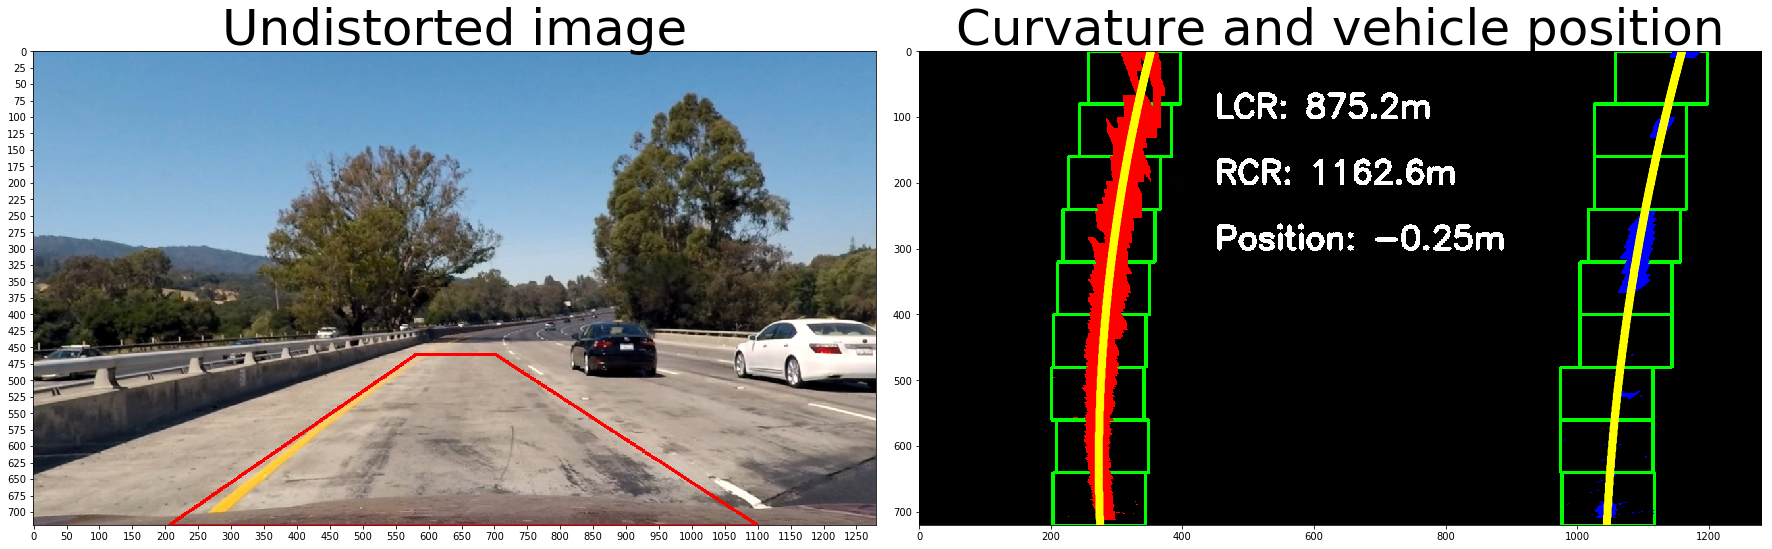

In [11]:
left_curverad, right_curverad, distance_from_center = curvature_position_estimation(binary_warped, left_fit_cr, right_fit_cr, left_x, right_x)

# Generate x and y values for plotting
ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )


# Plotting undistorted image and warped image
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24,9))
f.tight_layout()

ax1.set_title('Undistorted image', fontsize=50)
ax1.set_xticks(np.arange(0, undist.shape[1], step=50))
ax1.set_yticks(np.arange(0, undist.shape[0], step=25))
ax1.imshow(undist)



# Text visualization parameters
fontFace=cv2.FONT_HERSHEY_SIMPLEX
fontScale= 1.6
color = (255,255,255)
lineType = 5

#Left lane curvature - LCR
cv2.putText(out_img, 'LCR: {0:.1f}'.format(left_curverad)+'m', (450,100), fontFace, fontScale, color, lineType) 
#Right lane curvature - RCR
cv2.putText(out_img, 'RCR: {0:.1f}'.format(right_curverad)+'m', (450,200),fontFace, fontScale, color, lineType) 
# Vehicle position from the lanes midpoint - Positive values indicate to the right, negative to the left of
# the lanes midpoint
cv2.putText(out_img, 'Position: {0:.2f}'.format(distance_from_center)+'m', (450,300),fontFace, fontScale, color, lineType) 

ax2.set_title('Curvature and vehicle position', fontsize= 50)
# Plots the left and right polynomials on the lane lines
ax2.plot(left_fitx, ploty, linewidth=8, color='yellow')
ax2.plot(right_fitx, ploty, linewidth=8,color='yellow')
ax2.imshow(out_img)
plt.subplots_adjust(left = 0., right = 1, top=0.9, bottom = 0.)
plt.show()

# 7. Draw lanes in the original image

In [12]:
def draw_lanes(undist, warped, Minv, left_fitx, right_fitx):
    # Create an image to draw the lines on
    warp_zero = np.zeros_like(warped).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))
    
    # Generate x and y values for plotting
    ploty = np.linspace(0, warped.shape[0]-1, warped.shape[0] )
    
    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    unwarped = cv2.warpPerspective(color_warp, Minv, (undist.shape[1], undist.shape[0])) 
    
    # Combine the result with the original image
    result = cv2.addWeighted(undist, 1, unwarped, 0.3, 0)

    # resunt final image, value x of left lane at the bottom of image, value x of right lane at the bottom of image
    return result

## Sanity check

Our goal here is to check whether the lane lines are close to parallel, have a similar curvature and are separated by the right distance (should be around 3.7 meters)

In [13]:
def sanity_check(left_fit, right_fit, left_curverad, right_curverad, left_x_lane, right_x_lane):
    
    check_failed = False
    
    parallel_check = np.sqrt((left_fit[0]-right_fit[0])**2 + (left_fit[1]-right_fit[1])**2)
    print('Parallel indicator: {0:.2f}'.format(parallel_check))
    if parallel_check > 2: #0.5
        check_failed = True
        
    curvature_rl_ratio = right_curverad/left_curverad
    print('Curvature radius ratio: {0:.2f}'.format(curvature_rl_ratio))
    if ((curvature_rl_ratio > 10) | (curvature_rl_ratio < 0.1)):
        check_failed = True
    xm_per_pix_cam = 3.7/(1100-206) # meters per pixel in x dimension in camera space
    horizontal_distance = (right_x_lane-left_x_lane)* xm_per_pix_cam
    print('Horizontal separation of lanes: {0:.2f}m'.format(horizontal_distance))
    if np.abs(horizontal_distance-3.7) > 2:
        check_failed = True
    return check_failed


# Advanced lane finding pipeline (without line tracking)

Parallel indicator: 0.02
Curvature radius ratio: 1.33
Horizontal separation of lanes: 3.80m


<Figure size 432x288 with 0 Axes>

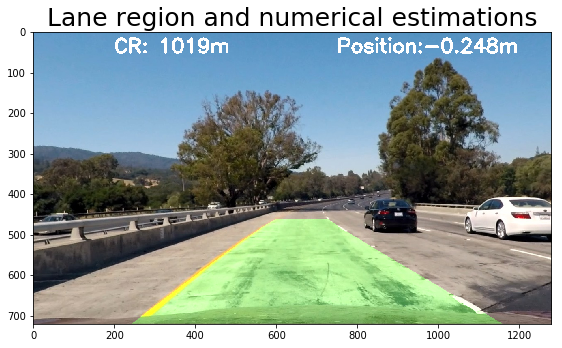

In [14]:
last_detection_left =  None
last_detection_right = None
last_curvature = None
last_distance = None 


def advanced_pipeline(img):
    
    global last_detection_left
    global last_detection_right
    global last_curvature
    global last_distance
    
    undist = undistort_image(img, mtx, dist)
    
    img_thresh = threshold_function(undist)
    
    binary_warped, perspective_M, Minv = perspective_transform(img_thresh)
    
    left_fitx, right_fitx, left_fit, right_fit, left_fit_cr, right_fit_cr, left_x_lane, right_x_lane, out_img = fit_polynomial(binary_warped)
    
    left_curverad, right_curverad, distance_from_center = curvature_position_estimation(binary_warped,left_fit_cr, right_fit_cr, left_x_lane, right_x_lane)
    
    insanity = sanity_check(left_fit, right_fit, left_curverad, right_curverad, left_x_lane, right_x_lane)
    
    if insanity:
        final = draw_lanes(undist, binary_warped, Minv, last_detection_left, last_detection_right)
        cv2.putText(final, 'CR: {0:.0f}'.format(last_curvature)+'m', (200,50), fontFace, fontScale, color, lineType) 
        cv2.putText(final, 'Position:{0:.3f}'.format(last_distance)+'m', (750,50),fontFace, fontScale, color, lineType) 
    else:
        final= draw_lanes(undist, binary_warped, Minv, left_fitx, right_fitx)
        #Curvature radius mean of left and right lanes
        cv2.putText(final, 'CR: {0:.0f}'.format((left_curverad+right_curverad)/2)+'m', (200,50), fontFace, fontScale, color, lineType) 
        cv2.putText(final, 'Position:{0:.3f}'.format(distance_from_center)+'m', (750,50),fontFace, fontScale, color, lineType) 
        
        last_detection_left  = left_fitx
        last_detection_right = right_fitx
        last_curvature = (left_curverad+right_curverad)/2
        last_distance = distance_from_center
    
    return final 

image = 'test_images/test1.jpg'
img = mpimg.imread(image)

fimage= advanced_pipeline(img)
plt.gcf().clear()

# Plotting undistorted image and warped image
f, (ax1) = plt.subplots(1, 1, figsize=(12,4.5))
f.tight_layout()
ax1.set_title('Lane region and numerical estimations', fontsize= 25)
ax1.imshow(fimage)
plt.subplots_adjust(left = 0., right = 1, top=0.9, bottom = 0.)
plt.show()


# Processing video

In [15]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [16]:
def process_image(image):
    # NOTE: The output you return should be a color image (3 channel) for processing video below
    # DONE: put your pipeline here,
    # you should return the final output (image where lines are drawn on lanes)
    
    # Use mode=0 to get raw lines as output over the original image. mode = 1 will offer two solid lines instead
    result = advanced_pipeline(image)
    return result

In [ ]:
input = 'challenge_video.mp4'

output ='challenge_output_project_video.mp4'

last_detection_left =  None
last_detection_right = None
last_curvature = None
last_distance = None

## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4").subclip(18.5,26)
clip1 = VideoFileClip(input).subclip(0,7)
output_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time output_clip.write_videofile(output, audio=False)
plt.gcf().clear()

In [ ]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(output))

# Advanced lane finding pipeline (with line tracking) and prior/posterior lane detection

In this section I will create a Line class to track the lanes in different frames and operate with data stored over time

In [17]:
# Define a class to receive the characteristics of each line detection
class Line():
    '''
    Line lane class. Stored the main attributes of the line abstraction and defines
    useful methods to process the line lanes in different frames
    '''
    def __init__(self, lane_type, buffer_size):
        
        # was the line detected in the last iteration?
        self.detected = False  
        
        # x values of the last n fits of the line
        self.recent_xfitted = [[0]]*buffer_size
        #average x values of the fitted line over the last n iterations
        self.bestx = None     
        #polynomial coefficients of the last n iterations
        self.recent_fit = [np.array([0,0,0])]*buffer_size  
        #polynomial coefficients averaged over the last n iterations
        self.best_fit = None 
        
        #difference in fit coefficients between last and new fits
        self.diffs = np.array([0,0,0], dtype='float') 
        
        #x values for detected line pixels
        self.allx = None  
        #y values for detected line pixels
        self.ally = None
        
        #radius of curvature of the line in some units
        self.radius_of_curvature = None 
        #distance in meters of vehicle center from the line
        self.line_base_pos = None 
        
        #number of iterations where data is going to be stored
        self.buffer_size = buffer_size
        #lane type
        if lane_type in ['left', 'right']:
            self.lane_type = lane_type
        else:
            raise Exception('Incorrect lane type.')
        #current index to store data in buffer
        self.current_index = 0
        #indicated when the buffer is full of data
        self.buffer_full = False
    

    # Find a set of pixels part of the left and right lane when no previous lanes have been identified
    def find_lane_pixels_prior(self, binary_warped):
        # Take a histogram of the bottom half of the image
        histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)
        
        # Returns true when the lane detection fails in the pixel finding step
        did_fail = False
        
        # Create an image to draw on and an image to show the selection window
        out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
        
        # Find the peak of the left and right halves of the histogram
        # These will be the starting point for the left and right lines
        midpoint = np.int(histogram.shape[0]//2)
        if self.lane_type == 'left':
            x_base = np.argmax(histogram[:midpoint])
        elif self.lane_type == 'right':
            x_base = np.argmax(histogram[midpoint:]) + midpoint

        # HYPERPARAMETERS
        # Choose the number of sliding windows
        nwindows = 9
        # Set the width of the windows +/- margin
        margin = 80
        # Set minimum number of pixels found to recenter window
        minpix = 40

        # Set height of windows - based on nwindows above and image shape
        window_height = np.int(binary_warped.shape[0]//nwindows)
        # Identify the x and y positions of all nonzero pixels in the image
        nonzero = binary_warped.nonzero()
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Current positions to be updated later for each window in nwindows
        x_current = x_base

        # Create empty lists to receive left and right lane pixel indices
        lane_inds = []

        # Step through the windows one by one
        for window in range(nwindows):
            # Identify window boundaries in x and y (and right and left)
            win_y_low = binary_warped.shape[0] - (window+1)*window_height
            win_y_high = binary_warped.shape[0] - window*window_height
            ### 1. Find the four boundaries of the left and right window ###
            win_x_low = x_current - margin 
            win_x_high = x_current + margin  
 

            # Draw the windows on the visualization image
            cv2.rectangle(out_img,(win_x_low,win_y_low),
            (win_x_high,win_y_high),(0,255,0), 4) 

            ### 2. Identify the nonzero pixels in x and y within the window ###
            good_inds = []

            for i in range(len(nonzerox)):

                if nonzerox[i]> binary_warped.shape[1]:
                    print(i, nonzerox[i])
                    continue
                # Add nonzero pixels within the windows in left line
                if (nonzerox[i]<win_x_high and nonzerox[i]>=win_x_low) and \
                    (nonzeroy[i]<win_y_high and nonzeroy[i]>=win_y_low):    
                    good_inds += [i]

            # Append these indices to the lists
            lane_inds.append(good_inds)

            ### 3. If you found > minpix pixels, recenter next window ###
            ### (`x_current`) on their mean position ###
            n = 0
            x_sum = 0
            for i in good_inds:
                n +=  1
                x_sum += nonzerox[i]
            if n > minpix:
                x_current =  x_sum//n


        # Concatenate the arrays of indices (previously was a list of lists of pixels)
        try:
            lane_inds = np.concatenate(lane_inds)
        except ValueError:
            # Avoids an error if the above is not implemented fully
            print('Something went wrong with the concatenation step!\n')
            self.detected = False
            pass

        # Extract left and right line pixel positions
        x = nonzerox[np.uint(lane_inds)]
        y = nonzeroy[np.uint(lane_inds)] 
        
        if x.size == 0:
            did_fail = True
            return self.bestx, None, None, None, None , None  
        
        # Fit new polynomials
        fitx, ploty, fit, fit_cr, x_lane ,out_img = self.fit_polynomial(binary_warped,out_img, x , y)
        
        # Updates basic information about the lane
        self.detected = True
        
        self.recent_xfitted[self.current_index] = fitx
        self.recent_fit[self.current_index] = np.array(fit)
        self.diffs = self.recent_fit[self.current_index] - self.recent_fit[self.current_index-1]
        
        self.ally = ploty
        self.allx = fitx
        
        if self.buffer_full:
            self.bestx = np.sum(self.recent_xfitted,0)//self.buffer_size
            self.best_fit = np.sum(self.recent_fit,0)//self.buffer_size
        else:
            self.bestx = np.sum(self.recent_xfitted,0)//(self.current_index+1)
            self.best_fit = np.sum(self.recent_fit,0)//(self.current_index+1)
            
        self.current_index += 1
        if (self.current_index == self.buffer_size):
            self.current_index = 0
            self.buffer_full = True
        
        #return fitx, ploty, fit,  fit_cr, x_lane ,out_img
        return self.bestx, ploty, self.best_fit,  fit_cr, x_lane ,out_img
    
    # Find a set of pixels part of the left and right lane when previous lanes have been identified
    def find_lane_pixels_posterior(self, binary_warped):
        
        # Create an image to draw on and an image to show the selection window
        out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
        window_img = np.zeros_like(out_img)
        
        # Returns true when the lane detection fails in the pixel finding step
        did_fail = False
        
        # margin of exploration of lane lines from the previous polynomial fit
        margin = 100
        
        # Grab activated pixels
        nonzero = binary_warped.nonzero()
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        
        ### Set the area of search based on activated x-values ###
        ### within the +/- margin of our polynomial function ###
        ### Hint: consider the window areas for the similarly named variables ###
        ### in the previous quiz, but change the windows to our new search area ###
        margin_min = self.recent_fit[self.current_index-1][0]*nonzeroy**2+self.recent_fit[self.current_index-1][1]*nonzeroy+self.recent_fit[self.current_index-1][2] - margin
        margin_max = self.recent_fit[self.current_index-1][0]*nonzeroy**2+self.recent_fit[self.current_index-1][1]*nonzeroy+self.recent_fit[self.current_index-1][2] + margin
        lane_inds = ((nonzerox >= margin_min) & (nonzerox < margin_max)).nonzero()[0]

        
        # Again, extract line pixel positions
        x = nonzerox[lane_inds]
        y = nonzeroy[lane_inds] 
        
        if x.size == 0:
            did_fail = True
            return self.bestx, None, None, None, None , None  
        
        # Fit new polynomials
        fitx, ploty, fit, fit_cr, x_lane ,out_img = self.fit_polynomial(binary_warped, out_img, x , y)
        
        # Generate a polygon to illustrate the search window area
        # And recast the x and y points into usable format for cv2.fillPoly()
        line_window1 = np.array([np.transpose(np.vstack([fitx-margin, ploty]))])
        line_window2 = np.array([np.flipud(np.transpose(np.vstack([fitx+margin, 
                                  ploty])))])
        line_pts = np.hstack((line_window1, line_window2))        
        
        cv2.fillPoly(window_img, np.int_([line_pts]), (0,255, 0))
        
        result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)
        
        # Updates basic information about the lane
        self.detected = True
        
        self.recent_xfitted[self.current_index] = fitx
        self.recent_fit[self.current_index] = np.array(fit)
        self.diffs = self.recent_fit[self.current_index] - self.recent_fit[self.current_index-1]
        
        self.ally = ploty
        self.allx = fitx
        
        if self.buffer_full:
            self.bestx = np.sum(self.recent_xfitted,0)//self.buffer_size
            self.best_fit = np.sum(self.recent_fit,0)//self.buffer_size
        else:
            self.bestx = np.sum(self.recent_xfitted,0)//(self.current_index+1)
            self.best_fit = np.sum(self.recent_fit,0)//(self.current_index+1)
            
        self.current_index += 1
        if (self.current_index == self.buffer_size):
            self.current_index = 0
            self.buffer_full = True
        
        #return fitx, ploty, fit,  fit_cr, x_lane ,result
        return self.bestx, ploty, self.best_fit,  fit_cr, x_lane ,out_img
    
    #Fit a set of pixel coordinates found in a image to a 2nd degree polynomial
    def fit_polynomial(self, binary_warped, out_img, x, y):
        
        
        # Define conversions in x and y from pixels to meters in the warped space 
        ym_per_pix = 30/720 # meters per pixel in y dimension
        xm_per_pix = 3.7/750 # meters per pixel in x dimension

        ### Fit a second order polynomial to each using `np.polyfit` ###
        fit = np.polyfit(y, x, 2)

        # Generate x and y values for plotting
        ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
        try:
            fitx = fit[0]*ploty**2 + fit[1]*ploty + fit[2]
        except TypeError:
            # Avoids an error if `left` and `right_fit` are still none or incorrect
            print('The function failed to fit a line!')
            fitx = 1*ploty**2 + 1*ploty

        fit_cr = np.polyfit(ym_per_pix*ploty, xm_per_pix*fitx, 2)
        
        # Here we calculate the lane x coordinate at the bottom of the undistorted image
        # Create an image to draw the lines on
        warp_zero = np.zeros_like(binary_warped).astype(np.uint8)
        warp = np.dstack((warp_zero, warp_zero, warp_zero))
        
        
        fitx = np.uint(np.abs(fitx))
        # Get the indices for which the fix <= limit
        indices = np.argwhere(fitx < binary_warped.shape[1])
    
        warp[np.uint(ploty[indices]),fitx[indices]] = [0,255,0]

         # Warp the blank back to original image space using inverse perspective matrix (Minv)
        unwarped = cv2.warpPerspective(warp, Minv, (undist.shape[1], undist.shape[0])) 

        single_unwarped = unwarped[:,:,1]
        # Identify the x and y positions of all nonzero pixels in the image
        nonzero = single_unwarped.nonzero()
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])

        # Get the indices fro which the y value is max in the binary image
        max_y_indices = np.argwhere(nonzeroy == np.amax(nonzeroy))
        # Values of x at the bottom of the image in the region between the lanes
        xvals = nonzerox[max_y_indices]
        
        if self.lane_type =='left':
            x_lane = np.min(xvals)
        elif self.lane_type == 'right':
            x_lane = np.max(xvals)
        
        ## Visualization ##
        window_img = np.zeros_like(out_img)    
        
        # Color in lane line pixels
        if self.lane_type =='left':
            out_img[y, x] = [255, 0, 0]
        elif self.lane_type == 'right':
            out_img[y, x] = [0, 0, 255]
        ## End visualization steps ##

        return fitx, ploty, fit, fit_cr, x_lane, out_img 
        
        


## Reset core data from lane lines

In [18]:
def reset_values():
    left_lane.detected = False
    right_lane.detected = False
    # x values of the last n fits of the line
    left_lane.recent_xfitted = [[0]]*left_lane.buffer_size
    right_lane.recent_xfitted = [[0]]*left_lane.buffer_size
    #average x values of the fitted line over the last n iterations
    left_lane.bestx = None
    right_lane.bestx = None 
    #polynomial coefficients of the last n iterations
    left_lane.recent_fit = [np.array([0,0,0])]*left_lane.buffer_size 
    right_lane.recent_fit = [np.array([0,0,0])]*left_lane.buffer_size
    #polynomial coefficients averaged over the last n iterations
    left_lane.best_fit = None
    right_lane.best_fit = None
    #current index to store data in buffer
    left_lane.current_index = 0
    right_lane.current_index = 0
    #indicated when the buffer is full of data
    left_lane.buffer_full = False
    right_lane.buffer_full = False

## Testing the Line class

Duration of find lane pixels prior: 1.069


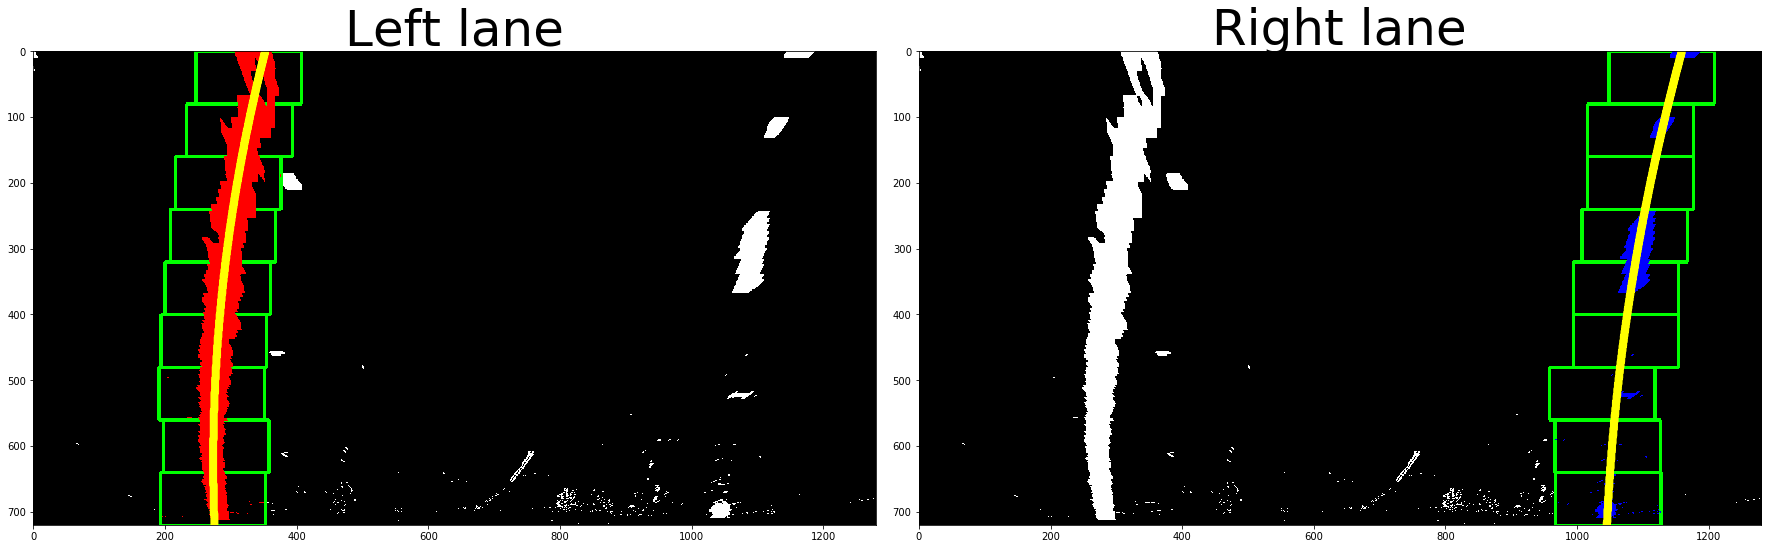

Duration of find lane pixels posterior: 0.119


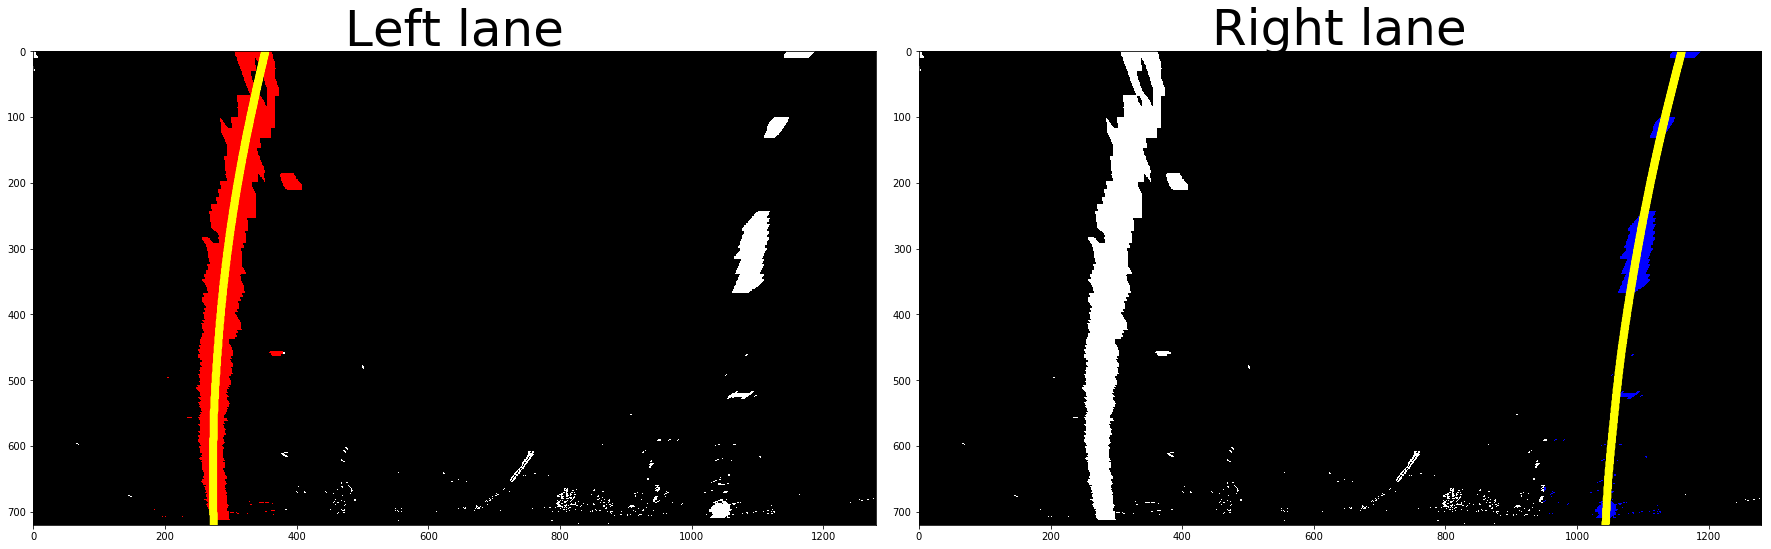

In [19]:
left_lane = Line('left',10)
right_lane = Line('right', 10)

t0 = time.time()

fitx, ploty, fit, fit_cr, x_lane ,result = left_lane.find_lane_pixels_prior(binary_warped)

fitx2, ploty2, fit2, fit_cr2, x_lane2 ,result2 = right_lane.find_lane_pixels_prior(binary_warped)

t1 = time.time()

print('Duration of find lane pixels prior: {0:.3f}'.format(t1-t0))

# Plotting undistorted image and warped image
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24,9))

f.tight_layout()
ax1.set_title('Left lane', fontsize=50)
ax1.plot(fitx, ploty, linewidth=8, color='yellow')
ax1.imshow(result)
ax2.set_title('Right lane', fontsize= 50)
ax2.plot(fitx2, ploty, linewidth=8, color='yellow')
ax2.imshow(result2)
plt.subplots_adjust(left = 0., right = 1, top=0.9, bottom = 0.)

plt.show()

t0 = time.time()

fitx, ploty, fit, fit_cr, x_lane ,result = left_lane.find_lane_pixels_posterior(binary_warped)

fitx2, ploty2, fit2, fit_cr2, x_lane2 ,result2 = right_lane.find_lane_pixels_posterior(binary_warped)

t1 = time.time()

print('Duration of find lane pixels posterior: {0:.3f}'.format(t1-t0))
# Plotting undistorted image and warped image
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24,9))
f.tight_layout()
ax1.set_title('Left lane', fontsize=50)
ax1.plot(fitx, ploty, linewidth=8, color='yellow')
ax1.imshow(result)
ax2.set_title('Right lane', fontsize= 50)
ax2.plot(fitx2, ploty, linewidth=8, color='yellow')
ax2.imshow(result2)
plt.subplots_adjust(left = 0., right = 1, top=0.9, bottom = 0.)
plt.show()


## Pipeline using the line class

Parallel indicator: 0.00
Curvature radius ratio: 1.13
Horizontal separation of lanes: 4.02m
Time duration of one pipeline pass: 0.828


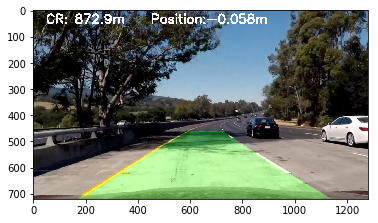

In [26]:
fail_count = 0

def advanced_pipeline_improved(img):
    
    global fail_count
    
    undist = undistort_image(img, mtx, dist)
    
    img_thresh = threshold_function(undist)
    
    binary_warped, perspective_M, Minv = perspective_transform(img_thresh)
    
    if left_lane.detected & right_lane.detected:
        left_fitx, ploty, left_fit, left_fit_cr, left_x_lane ,out_img = left_lane.find_lane_pixels_posterior(binary_warped)
        right_fitx, ploty, right_fit, right_fit_cr, right_x_lane ,out_img2 = right_lane.find_lane_pixels_posterior(binary_warped)
    else:
        left_fitx, ploty, left_fit, left_fit_cr, left_x_lane ,out_img = left_lane.find_lane_pixels_prior(binary_warped)
        right_fitx, ploty, right_fit, right_fit_cr, right_x_lane ,out_img2 = right_lane.find_lane_pixels_prior(binary_warped)
    
    
    insanity = False
    
    if (type(left_fit_cr) != type(None)):
        left_curverad, right_curverad, distance_from_center = curvature_position_estimation(binary_warped,left_fit_cr, right_fit_cr, left_x_lane, right_x_lane)
        insanity = sanity_check(left_fit, right_fit, left_curverad, right_curverad, left_x_lane, right_x_lane)

    if insanity | (type(left_fit_cr) == type(None)):
        fail_count += 1
        
        if (type(left_fit_cr) != type(None)):
            # x values of the last n fits of the line
            left_lane.recent_xfitted[left_lane.current_index-1] = np.zeros(binary_warped.shape[0])
            right_lane.recent_xfitted[right_lane.current_index-1] = np.zeros(binary_warped.shape[0])

            #polynomial coefficients of the last n iterations
            left_lane.recent_fit[left_lane.current_index-1] = np.array([0,0,0])
            right_lane.recent_fit[right_lane.current_index-1] = np.array([0,0,0])

            #average x values of the fitted line over the last n iterations
            if left_lane.buffer_full:
                left_lane.bestx = np.sum(left_lane.recent_xfitted,0)//(left_lane.buffer_size-1)
                right_lane.bestx = np.sum(right_lane.recent_xfitted,0)//(right_lane.buffer_size-1)

                left_lane.best_fit = np.sum(left_lane.recent_fit,0)//(left_lane.buffer_size-1)
                left_lane.best_fit = np.sum(right_lane.recent_fit,0)//(right_lane.buffer_size-1)
            else:
                left_lane.bestx = np.sum(left_lane.recent_xfitted,0)//(left_lane.current_index+1)
                right_lane.bestx = np.sum(right_lane.recent_xfitted,0)//(right_lane.current_index+1)

                left_lane.best_fit = np.sum(left_lane.recent_fit,0)//(left_lane.current_index+1)
                right_lane.best_fit = np.sum(right_lane.recent_fit,0)//(right_lane.current_index+1)

            left_lane.current_index -= 1
            right_lane.current_index -= 1

        final= draw_lanes(undist, binary_warped, Minv, left_lane.bestx, right_lane.bestx)
        #Curvature radius mean of left and right lanes
        cv2.putText(final, 'CR: {0:.1f}'.format((left_lane.radius_of_curvature+right_lane.radius_of_curvature)/2)+'m', (50,50), fontFace, fontScale, color, lineType) 
        # Position of the vehicle respect to the center of the lane. Negative indicates the vehicle is to the left, positive to the right
        cv2.putText(final, 'Position:{0:.3f}'.format(left_lane.line_base_pos)+'m', (450,50),fontFace, fontScale, color, lineType) 
        
        if fail_count>20:
            fail_count = 0
            reset_values()
    else:
        final= draw_lanes(undist, binary_warped, Minv, left_fitx, right_fitx)
        #Curvature radius mean of left and right lanes
        cv2.putText(final, 'CR: {0:.1f}'.format((left_curverad+right_curverad)/2)+'m', (50,50), fontFace, fontScale, color, lineType) 
        # Position of the vehicle respect to the center of the lane. Negative indicates the vehicle is to the left, positive to the right
        cv2.putText(final, 'Position:{0:.3f}'.format(distance_from_center)+'m', (450,50),fontFace, fontScale, color, lineType) 
        
        left_lane.radius_of_curvature = left_curverad
        right_lane.radius_of_curvature = right_curverad
        
        left_lane.line_base_pos = distance_from_center 
        
    return final

left_lane = Line('left',10)
right_lane = Line('right', 10)

image = 'test_images/test5.jpg'
img = mpimg.imread(image)

t0 = time.time()

fimage= advanced_pipeline_improved(img)
plt.gcf().clear()
plt.imshow(fimage)

t1 = time.time()

print('Time duration of one pipeline pass: {0:.3f}'.format(t1-t0))

In [27]:
left_lane = Line('left', 5)
right_lane = Line('right', 5)
fail_count = 0

def process_image_improved(image):
    # NOTE: The output you return should be a color image (3 channel) for processing video below
    # put your pipeline here,
    # you should return the final output (image where lines are drawn on lanes)
    
    result = advanced_pipeline_improved(image)
    return result

In [28]:
input = 'project_video.mp4'

output ='output_project_video.mp4'

## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4").subclip(0,5)
clip2 = VideoFileClip(input)
output_clip2 = clip2.fl_image(process_image_improved) #NOTE: this function expects color images!!
%time output_clip2.write_videofile(output, audio=False)
plt.gcf().clear()

Parallel indicator: 0.00
Curvature radius ratio: 1.27
Horizontal separation of lanes: 3.53m
[MoviePy] >>>> Building video harder_challenge_output_project_video.mp4
[MoviePy] Writing video harder_challenge_output_project_video.mp4


  0%|                                                                                         | 0/1200 [00:00<?, ?it/s]

Parallel indicator: 0.00
Curvature radius ratio: 0.95
Horizontal separation of lanes: 3.56m


  0%|                                                                                 | 1/1200 [00:00<05:16,  3.79it/s]

Parallel indicator: 0.00
Curvature radius ratio: 0.58
Horizontal separation of lanes: 3.54m


  0%|▏                                                                                | 2/1200 [00:00<05:21,  3.72it/s]

Parallel indicator: 0.00
Curvature radius ratio: 0.55
Horizontal separation of lanes: 3.58m


  0%|▏                                                                                | 3/1200 [00:00<05:27,  3.66it/s]

Parallel indicator: 0.00
Curvature radius ratio: 0.52
Horizontal separation of lanes: 3.60m


  0%|▎                                                                                | 4/1200 [00:01<05:35,  3.56it/s]

Parallel indicator: 0.00
Curvature radius ratio: 0.49
Horizontal separation of lanes: 3.63m


  0%|▎                                                                                | 5/1200 [00:01<05:29,  3.62it/s]

Parallel indicator: 0.00
Curvature radius ratio: 0.49
Horizontal separation of lanes: 3.63m


  0%|▍                                                                                | 6/1200 [00:01<05:21,  3.71it/s]

Parallel indicator: 0.00
Curvature radius ratio: 0.49
Horizontal separation of lanes: 3.60m


  1%|▍                                                                                | 7/1200 [00:01<05:11,  3.83it/s]

Parallel indicator: 0.00
Curvature radius ratio: 0.56
Horizontal separation of lanes: 3.58m


  1%|▌                                                                                | 8/1200 [00:02<05:03,  3.93it/s]

Parallel indicator: 1.00
Curvature radius ratio: 0.60
Horizontal separation of lanes: 3.56m


  1%|▌                                                                                | 9/1200 [00:02<05:01,  3.96it/s]

Parallel indicator: 1.00
Curvature radius ratio: 0.57
Horizontal separation of lanes: 3.51m


  1%|▋                                                                               | 10/1200 [00:02<05:07,  3.87it/s]

Parallel indicator: 1.00
Curvature radius ratio: 0.50
Horizontal separation of lanes: 3.48m


  1%|▋                                                                               | 11/1200 [00:02<04:58,  3.98it/s]

Parallel indicator: 1.00
Curvature radius ratio: 0.50
Horizontal separation of lanes: 3.50m


  1%|▊                                                                               | 12/1200 [00:03<04:54,  4.03it/s]

Parallel indicator: 1.00
Curvature radius ratio: 0.47
Horizontal separation of lanes: 3.49m


  1%|▊                                                                               | 13/1200 [00:03<04:51,  4.07it/s]

Parallel indicator: 1.00
Curvature radius ratio: 0.46
Horizontal separation of lanes: 3.49m


  1%|▉                                                                               | 14/1200 [00:03<04:50,  4.08it/s]

Parallel indicator: 1.00
Curvature radius ratio: 0.45
Horizontal separation of lanes: 3.47m


  1%|█                                                                               | 15/1200 [00:03<04:51,  4.06it/s]

Parallel indicator: 1.00
Curvature radius ratio: 0.45
Horizontal separation of lanes: 3.44m


  1%|█                                                                               | 16/1200 [00:04<04:44,  4.16it/s]

Parallel indicator: 1.00
Curvature radius ratio: 0.51
Horizontal separation of lanes: 3.45m


  1%|█▏                                                                              | 17/1200 [00:04<04:48,  4.10it/s]

Parallel indicator: 0.00
Curvature radius ratio: 0.52
Horizontal separation of lanes: 3.46m


  2%|█▏                                                                              | 18/1200 [00:04<05:18,  3.71it/s]

Parallel indicator: 0.00
Curvature radius ratio: 0.58
Horizontal separation of lanes: 3.49m


  2%|█▎                                                                              | 19/1200 [00:04<05:13,  3.77it/s]

Parallel indicator: 0.00
Curvature radius ratio: 0.66
Horizontal separation of lanes: 3.53m


  2%|█▎                                                                              | 20/1200 [00:05<05:10,  3.79it/s]

Parallel indicator: 1.00
Curvature radius ratio: 0.64
Horizontal separation of lanes: 3.56m


  2%|█▍                                                                              | 21/1200 [00:05<04:57,  3.96it/s]

Parallel indicator: 1.00
Curvature radius ratio: 0.63
Horizontal separation of lanes: 3.58m


  2%|█▍                                                                              | 22/1200 [00:05<04:45,  4.12it/s]

Parallel indicator: 1.00
Curvature radius ratio: 0.59
Horizontal separation of lanes: 3.61m


  2%|█▌                                                                              | 23/1200 [00:05<04:55,  3.98it/s]

Parallel indicator: 1.00
Curvature radius ratio: 0.60
Horizontal separation of lanes: 3.63m


  2%|█▌                                                                              | 24/1200 [00:06<05:05,  3.85it/s]

Parallel indicator: 1.00
Curvature radius ratio: 0.51
Horizontal separation of lanes: 3.58m


  2%|█▋                                                                              | 25/1200 [00:06<05:11,  3.78it/s]

Parallel indicator: 1.00
Curvature radius ratio: 0.48
Horizontal separation of lanes: 3.53m


  2%|█▋                                                                              | 26/1200 [00:06<04:58,  3.93it/s]

Parallel indicator: 1.00
Curvature radius ratio: 0.46
Horizontal separation of lanes: 3.51m


  2%|█▊                                                                              | 27/1200 [00:06<04:48,  4.06it/s]

Parallel indicator: 1.00
Curvature radius ratio: 0.49
Horizontal separation of lanes: 3.54m


  2%|█▊                                                                              | 28/1200 [00:07<04:48,  4.07it/s]

Parallel indicator: 1.00
Curvature radius ratio: 0.54
Horizontal separation of lanes: 3.58m


  2%|█▉                                                                              | 29/1200 [00:07<04:45,  4.10it/s]

Parallel indicator: 1.00
Curvature radius ratio: 0.57
Horizontal separation of lanes: 3.61m


  2%|██                                                                              | 30/1200 [00:07<04:50,  4.03it/s]

Parallel indicator: 1.00
Curvature radius ratio: 0.52
Horizontal separation of lanes: 3.58m


  3%|██                                                                              | 31/1200 [00:07<04:59,  3.90it/s]

Parallel indicator: 1.00
Curvature radius ratio: 0.51
Horizontal separation of lanes: 3.59m


  3%|██▏                                                                             | 32/1200 [00:08<04:59,  3.90it/s]

Parallel indicator: 0.00
Curvature radius ratio: 0.59
Horizontal separation of lanes: 3.67m


  3%|██▏                                                                             | 33/1200 [00:08<05:05,  3.82it/s]

Parallel indicator: 0.00
Curvature radius ratio: 0.65
Horizontal separation of lanes: 3.66m


  3%|██▎                                                                             | 34/1200 [00:08<05:04,  3.83it/s]

Parallel indicator: 0.00
Curvature radius ratio: 0.73
Horizontal separation of lanes: 3.65m


  3%|██▎                                                                             | 35/1200 [00:08<04:51,  3.99it/s]

Parallel indicator: 0.00
Curvature radius ratio: 0.75
Horizontal separation of lanes: 3.63m


  3%|██▍                                                                             | 36/1200 [00:09<04:47,  4.05it/s]

Parallel indicator: 0.00
Curvature radius ratio: 0.83
Horizontal separation of lanes: 3.60m


  3%|██▍                                                                             | 37/1200 [00:09<04:42,  4.11it/s]

Parallel indicator: 1.00
Curvature radius ratio: 0.91
Horizontal separation of lanes: 3.60m


  3%|██▌                                                                             | 38/1200 [00:09<04:35,  4.21it/s]

Parallel indicator: 0.00
Curvature radius ratio: 0.94
Horizontal separation of lanes: 3.59m


  3%|██▌                                                                             | 39/1200 [00:09<04:30,  4.29it/s]

Parallel indicator: 0.00
Curvature radius ratio: 0.96
Horizontal separation of lanes: 3.58m


  3%|██▋                                                                             | 40/1200 [00:10<04:34,  4.23it/s]

Parallel indicator: 0.00
Curvature radius ratio: 1.11
Horizontal separation of lanes: 3.61m


  3%|██▋                                                                             | 41/1200 [00:10<04:46,  4.04it/s]

Parallel indicator: 0.00
Curvature radius ratio: 1.20
Horizontal separation of lanes: 3.63m


  4%|██▊                                                                             | 42/1200 [00:10<04:52,  3.96it/s]

Parallel indicator: 0.00
Curvature radius ratio: 1.25
Horizontal separation of lanes: 3.63m


  4%|██▊                                                                             | 43/1200 [00:10<05:00,  3.86it/s]

Parallel indicator: 0.00
Curvature radius ratio: 1.27
Horizontal separation of lanes: 3.62m


  4%|██▉                                                                             | 44/1200 [00:11<05:00,  3.85it/s]

Parallel indicator: 1.00
Curvature radius ratio: 1.44
Horizontal separation of lanes: 3.66m


  4%|███                                                                             | 45/1200 [00:11<04:50,  3.97it/s]

Parallel indicator: 1.00
Curvature radius ratio: 1.57
Horizontal separation of lanes: 3.68m


  4%|███                                                                             | 46/1200 [00:11<04:50,  3.98it/s]

Parallel indicator: 1.00
Curvature radius ratio: 1.68
Horizontal separation of lanes: 3.69m


  4%|███▏                                                                            | 47/1200 [00:11<04:54,  3.91it/s]

Parallel indicator: 1.00
Curvature radius ratio: 1.83
Horizontal separation of lanes: 3.72m


  4%|███▏                                                                            | 48/1200 [00:12<04:54,  3.92it/s]

Parallel indicator: 1.00
Curvature radius ratio: 1.91
Horizontal separation of lanes: 3.74m


  4%|███▎                                                                            | 49/1200 [00:12<05:05,  3.77it/s]

Parallel indicator: 1.00
Curvature radius ratio: 1.90
Horizontal separation of lanes: 3.73m


  4%|███▎                                                                            | 50/1200 [00:12<05:10,  3.70it/s]

Parallel indicator: 1.00
Curvature radius ratio: 1.71
Horizontal separation of lanes: 3.68m


  4%|███▍                                                                            | 51/1200 [00:13<05:07,  3.74it/s]

Parallel indicator: 1.00
Curvature radius ratio: 1.77
Horizontal separation of lanes: 3.68m


  4%|███▍                                                                            | 52/1200 [00:13<04:57,  3.85it/s]

Parallel indicator: 2.00
Curvature radius ratio: 1.82
Horizontal separation of lanes: 3.68m


  4%|███▌                                                                            | 53/1200 [00:13<04:56,  3.86it/s]

Parallel indicator: 2.00
Curvature radius ratio: 1.85
Horizontal separation of lanes: 3.68m


  4%|███▌                                                                            | 54/1200 [00:13<04:56,  3.87it/s]

Parallel indicator: 2.00
Curvature radius ratio: 1.76
Horizontal separation of lanes: 3.64m


  5%|███▋                                                                            | 55/1200 [00:14<04:50,  3.94it/s]

Parallel indicator: 2.00
Curvature radius ratio: 1.80
Horizontal separation of lanes: 3.64m


  5%|███▋                                                                            | 56/1200 [00:14<04:48,  3.97it/s]

Parallel indicator: 2.00
Curvature radius ratio: 1.95
Horizontal separation of lanes: 3.65m


  5%|███▊                                                                            | 57/1200 [00:14<05:04,  3.76it/s]

Parallel indicator: 2.00
Curvature radius ratio: 2.00
Horizontal separation of lanes: 3.65m


  5%|███▊                                                                            | 58/1200 [00:14<05:01,  3.78it/s]

Parallel indicator: 2.00
Curvature radius ratio: 1.87
Horizontal separation of lanes: 3.65m


  5%|███▉                                                                            | 59/1200 [00:15<04:59,  3.81it/s]

Parallel indicator: 2.00
Curvature radius ratio: 1.81
Horizontal separation of lanes: 3.65m


  5%|████                                                                            | 60/1200 [00:15<04:56,  3.85it/s]

Parallel indicator: 2.00
Curvature radius ratio: 1.80
Horizontal separation of lanes: 3.67m


  5%|████                                                                            | 61/1200 [00:15<05:08,  3.69it/s]

Parallel indicator: 2.00
Curvature radius ratio: 1.96
Horizontal separation of lanes: 3.70m


  5%|████▏                                                                           | 62/1200 [00:15<04:59,  3.79it/s]

Parallel indicator: 2.00
Curvature radius ratio: 2.11
Horizontal separation of lanes: 3.71m


  5%|████▏                                                                           | 63/1200 [00:16<04:52,  3.89it/s]

Parallel indicator: 2.00
Curvature radius ratio: 2.65
Horizontal separation of lanes: 3.75m


  5%|████▎                                                                           | 64/1200 [00:16<04:52,  3.88it/s]

Parallel indicator: 2.00
Curvature radius ratio: 3.62
Horizontal separation of lanes: 3.81m


  5%|████▎                                                                           | 65/1200 [00:16<04:58,  3.81it/s]

Parallel indicator: 2.00
Curvature radius ratio: 4.60
Horizontal separation of lanes: 3.84m


  6%|████▍                                                                           | 66/1200 [00:16<05:02,  3.75it/s]

Parallel indicator: 2.00
Curvature radius ratio: 6.10
Horizontal separation of lanes: 3.87m


  6%|████▍                                                                           | 67/1200 [00:17<04:54,  3.85it/s]

Parallel indicator: 3.00
Curvature radius ratio: 8.24
Horizontal separation of lanes: 3.89m


  6%|████▌                                                                           | 68/1200 [00:17<04:57,  3.81it/s]

Parallel indicator: 3.00
Curvature radius ratio: 10.45
Horizontal separation of lanes: 3.91m


  6%|████▌                                                                           | 69/1200 [00:17<04:58,  3.79it/s]

Parallel indicator: 3.00
Curvature radius ratio: 11.29
Horizontal separation of lanes: 3.90m


  6%|████▋                                                                           | 70/1200 [00:17<04:56,  3.81it/s]

Parallel indicator: 3.00
Curvature radius ratio: 10.75
Horizontal separation of lanes: 3.89m


  6%|████▋                                                                           | 71/1200 [00:18<04:55,  3.83it/s]

Parallel indicator: 3.00
Curvature radius ratio: 9.37
Horizontal separation of lanes: 3.90m


  6%|████▊                                                                           | 72/1200 [00:18<04:54,  3.83it/s]

Parallel indicator: 3.00
Curvature radius ratio: 6.38
Horizontal separation of lanes: 3.84m


  6%|████▊                                                                           | 73/1200 [00:18<05:04,  3.70it/s]

Parallel indicator: 2.00
Curvature radius ratio: 5.14
Horizontal separation of lanes: 3.79m


  6%|████▉                                                                           | 74/1200 [00:19<05:03,  3.71it/s]

Parallel indicator: 4.00
Curvature radius ratio: 4.67
Horizontal separation of lanes: 3.78m


  6%|█████                                                                           | 75/1200 [00:19<04:52,  3.85it/s]

Parallel indicator: 3.00
Curvature radius ratio: 4.02
Horizontal separation of lanes: 3.75m


  6%|█████                                                                           | 76/1200 [00:19<04:53,  3.82it/s]

Parallel indicator: 3.00
Curvature radius ratio: 3.91
Horizontal separation of lanes: 3.73m


  6%|█████▏                                                                          | 77/1200 [00:19<04:55,  3.80it/s]

Parallel indicator: 3.00
Curvature radius ratio: 3.54
Horizontal separation of lanes: 3.72m


  6%|█████▏                                                                          | 78/1200 [00:20<04:54,  3.81it/s]

Parallel indicator: 3.00
Curvature radius ratio: 3.66
Horizontal separation of lanes: 3.72m


  7%|█████▎                                                                          | 79/1200 [00:20<04:44,  3.93it/s]

Parallel indicator: 3.00
Curvature radius ratio: 3.92
Horizontal separation of lanes: 3.74m


  7%|█████▎                                                                          | 80/1200 [00:20<04:48,  3.89it/s]

Parallel indicator: 3.00
Curvature radius ratio: 3.58
Horizontal separation of lanes: 3.72m


  7%|█████▍                                                                          | 81/1200 [00:20<05:01,  3.71it/s]

Parallel indicator: 3.00
Curvature radius ratio: 3.43
Horizontal separation of lanes: 3.75m


  7%|█████▍                                                                          | 82/1200 [00:21<04:54,  3.80it/s]

Parallel indicator: 3.00
Curvature radius ratio: 3.05
Horizontal separation of lanes: 3.74m


  7%|█████▌                                                                          | 83/1200 [00:21<05:00,  3.71it/s]

Parallel indicator: 3.00
Curvature radius ratio: 2.40
Horizontal separation of lanes: 3.71m


  7%|█████▌                                                                          | 84/1200 [00:21<05:03,  3.68it/s]

Parallel indicator: 3.00
Curvature radius ratio: 2.04
Horizontal separation of lanes: 3.68m


  7%|█████▋                                                                          | 85/1200 [00:21<05:01,  3.70it/s]

Parallel indicator: 3.00
Curvature radius ratio: 1.39
Horizontal separation of lanes: 3.64m


  7%|█████▋                                                                          | 86/1200 [00:22<04:51,  3.82it/s]

Parallel indicator: 3.00
Curvature radius ratio: 1.37
Horizontal separation of lanes: 3.63m


  7%|█████▊                                                                          | 87/1200 [00:22<04:54,  3.78it/s]

Parallel indicator: 3.00
Curvature radius ratio: 1.77
Horizontal separation of lanes: 3.60m


  7%|█████▊                                                                          | 88/1200 [00:22<04:56,  3.75it/s]

Parallel indicator: 3.00
Curvature radius ratio: 2.02
Horizontal separation of lanes: 3.57m


  7%|█████▉                                                                          | 89/1200 [00:23<04:56,  3.75it/s]

Parallel indicator: 1.41
Curvature radius ratio: 8.62
Horizontal separation of lanes: 3.56m


  8%|██████                                                                          | 90/1200 [00:25<18:44,  1.01s/it]

Parallel indicator: 1.41
Curvature radius ratio: 7.50
Horizontal separation of lanes: 3.67m


  8%|██████                                                                          | 91/1200 [00:26<14:29,  1.28it/s]

Parallel indicator: 1.41
Curvature radius ratio: 5.71
Horizontal separation of lanes: 3.68m


  8%|██████▏                                                                         | 92/1200 [00:26<11:34,  1.60it/s]

Parallel indicator: 1.41
Curvature radius ratio: 3.73
Horizontal separation of lanes: 3.68m


  8%|██████▏                                                                         | 93/1200 [00:26<09:30,  1.94it/s]

Parallel indicator: 1.41
Curvature radius ratio: 1.26
Horizontal separation of lanes: 3.70m


  8%|██████▎                                                                         | 94/1200 [00:26<08:09,  2.26it/s]

Parallel indicator: 1.41
Curvature radius ratio: 0.27
Horizontal separation of lanes: 3.72m


  8%|██████▎                                                                         | 95/1200 [00:27<07:10,  2.56it/s]

Parallel indicator: 1.41
Curvature radius ratio: 0.61
Horizontal separation of lanes: 3.75m


  8%|██████▍                                                                         | 96/1200 [00:27<06:37,  2.78it/s]

Parallel indicator: 0.00
Curvature radius ratio: 0.66
Horizontal separation of lanes: 3.75m


  8%|██████▍                                                                         | 97/1200 [00:27<06:02,  3.04it/s]

Parallel indicator: 1.00
Curvature radius ratio: 0.76
Horizontal separation of lanes: 3.69m


  8%|██████▌                                                                         | 98/1200 [00:27<05:42,  3.22it/s]

Parallel indicator: 0.00
Curvature radius ratio: 0.86
Horizontal separation of lanes: 3.60m


  8%|██████▌                                                                         | 99/1200 [00:28<05:27,  3.36it/s]

Parallel indicator: 0.00
Curvature radius ratio: 0.89
Horizontal separation of lanes: 3.57m


  8%|██████▌                                                                        | 100/1200 [00:28<05:17,  3.46it/s]

Parallel indicator: 1.00
Curvature radius ratio: 0.89
Horizontal separation of lanes: 3.55m


  8%|██████▋                                                                        | 101/1200 [00:28<05:09,  3.55it/s]

Parallel indicator: 0.00
Curvature radius ratio: 0.91
Horizontal separation of lanes: 3.50m


  8%|██████▋                                                                        | 102/1200 [00:28<05:02,  3.63it/s]

Parallel indicator: 1.00
Curvature radius ratio: 0.96
Horizontal separation of lanes: 3.44m


  9%|██████▊                                                                        | 103/1200 [00:29<05:00,  3.65it/s]

Parallel indicator: 1.00
Curvature radius ratio: 0.99
Horizontal separation of lanes: 3.38m


  9%|██████▊                                                                        | 104/1200 [00:29<04:53,  3.73it/s]

Parallel indicator: 0.00
Curvature radius ratio: 0.97
Horizontal separation of lanes: 3.35m


  9%|██████▉                                                                        | 105/1200 [00:29<04:58,  3.67it/s]

Parallel indicator: 1.00
Curvature radius ratio: 0.94
Horizontal separation of lanes: 3.31m


  9%|██████▉                                                                        | 106/1200 [00:29<04:47,  3.80it/s]

Parallel indicator: 1.00
Curvature radius ratio: 0.92
Horizontal separation of lanes: 3.28m


  9%|███████                                                                        | 107/1200 [00:30<04:42,  3.87it/s]

Parallel indicator: 1.00
Curvature radius ratio: 0.86
Horizontal separation of lanes: 3.24m


  9%|███████                                                                        | 108/1200 [00:30<04:42,  3.86it/s]

Parallel indicator: 1.00
Curvature radius ratio: 0.82
Horizontal separation of lanes: 3.12m


  9%|███████▏                                                                       | 109/1200 [00:30<04:44,  3.83it/s]

Parallel indicator: 2.00
Curvature radius ratio: 0.79
Horizontal separation of lanes: 3.02m


  9%|███████▏                                                                       | 110/1200 [00:30<04:35,  3.95it/s]

Parallel indicator: 2.00
Curvature radius ratio: 0.79
Horizontal separation of lanes: 2.92m


  9%|███████▎                                                                       | 111/1200 [00:31<04:30,  4.03it/s]

Parallel indicator: 3.00
Curvature radius ratio: 0.69
Horizontal separation of lanes: 2.84m


  9%|███████▎                                                                       | 112/1200 [00:31<04:34,  3.97it/s]

Parallel indicator: 4.00
Curvature radius ratio: 0.50
Horizontal separation of lanes: 2.91m


  9%|███████▍                                                                       | 113/1200 [00:31<04:37,  3.92it/s]

Parallel indicator: 2.00
Curvature radius ratio: 2.36
Horizontal separation of lanes: 2.75m


 10%|███████▌                                                                       | 114/1200 [00:31<04:31,  3.99it/s]

Parallel indicator: 2.00
Curvature radius ratio: 1.28
Horizontal separation of lanes: 2.93m


 10%|███████▌                                                                       | 115/1200 [00:32<04:29,  4.03it/s]

Parallel indicator: 2.00
Curvature radius ratio: 1.03
Horizontal separation of lanes: 2.89m


 10%|███████▋                                                                       | 116/1200 [00:32<04:32,  3.98it/s]

Parallel indicator: 1.00
Curvature radius ratio: 4.57
Horizontal separation of lanes: 2.68m


 10%|███████▋                                                                       | 117/1200 [00:32<04:33,  3.96it/s]

Parallel indicator: 2.00
Curvature radius ratio: 25.13
Horizontal separation of lanes: 2.72m


 10%|███████▊                                                                       | 118/1200 [00:33<04:41,  3.84it/s]

Parallel indicator: 2.00
Curvature radius ratio: 8.49
Horizontal separation of lanes: 2.77m


 10%|███████▊                                                                       | 119/1200 [00:33<04:39,  3.87it/s]

Parallel indicator: 2.00
Curvature radius ratio: 19.63
Horizontal separation of lanes: 2.82m


 10%|███████▉                                                                       | 120/1200 [00:33<04:39,  3.86it/s]

Parallel indicator: 2.00
Curvature radius ratio: 125.44
Horizontal separation of lanes: 2.82m


 10%|███████▉                                                                       | 121/1200 [00:33<04:43,  3.80it/s]

Parallel indicator: 3.00
Curvature radius ratio: 17.68
Horizontal separation of lanes: 2.71m


 10%|████████                                                                       | 122/1200 [00:34<04:36,  3.90it/s]

Parallel indicator: 3.00
Curvature radius ratio: 6.82
Horizontal separation of lanes: 2.57m


 10%|████████                                                                       | 123/1200 [00:34<04:38,  3.86it/s]

Parallel indicator: 3.00
Curvature radius ratio: 5.63
Horizontal separation of lanes: 2.50m


 10%|████████▏                                                                      | 124/1200 [00:34<04:33,  3.93it/s]

Parallel indicator: 3.00
Curvature radius ratio: 6.99
Horizontal separation of lanes: 2.48m


 10%|████████▏                                                                      | 125/1200 [00:34<04:33,  3.93it/s]

Parallel indicator: 2.00
Curvature radius ratio: 13.62
Horizontal separation of lanes: 2.58m


 10%|████████▎                                                                      | 126/1200 [00:35<04:39,  3.84it/s]

Parallel indicator: 2.00
Curvature radius ratio: 1.73
Horizontal separation of lanes: 2.87m


 11%|████████▎                                                                      | 127/1200 [00:35<04:36,  3.88it/s]

Parallel indicator: 1.00
Curvature radius ratio: 0.81
Horizontal separation of lanes: 3.07m


 11%|████████▍                                                                      | 128/1200 [00:35<04:39,  3.83it/s]

Parallel indicator: 1.00
Curvature radius ratio: 0.71
Horizontal separation of lanes: 3.10m


 11%|████████▍                                                                      | 129/1200 [00:35<04:27,  4.01it/s]

Parallel indicator: 0.00
Curvature radius ratio: 0.58
Horizontal separation of lanes: 3.29m


 11%|████████▌                                                                      | 130/1200 [00:36<04:23,  4.05it/s]

Parallel indicator: 2.00
Curvature radius ratio: 0.57
Horizontal separation of lanes: 3.34m


 11%|████████▌                                                                      | 131/1200 [00:36<04:29,  3.97it/s]

Parallel indicator: 3.00
Curvature radius ratio: 0.58
Horizontal separation of lanes: 3.33m


 11%|████████▋                                                                      | 132/1200 [00:36<04:21,  4.08it/s]

Parallel indicator: 3.00
Curvature radius ratio: 0.60
Horizontal separation of lanes: 3.32m


 11%|████████▊                                                                      | 133/1200 [00:36<04:33,  3.91it/s]

Parallel indicator: 2.00
Curvature radius ratio: 1.00
Horizontal separation of lanes: 3.19m


 11%|████████▊                                                                      | 134/1200 [00:37<04:28,  3.97it/s]

Parallel indicator: 2.00
Curvature radius ratio: 1.77
Horizontal separation of lanes: 3.11m


 11%|████████▉                                                                      | 135/1200 [00:37<04:22,  4.05it/s]

Parallel indicator: 1.00
Curvature radius ratio: 6.74
Horizontal separation of lanes: 3.02m


 11%|████████▉                                                                      | 136/1200 [00:37<04:27,  3.97it/s]

Parallel indicator: 0.00
Curvature radius ratio: 1.48
Horizontal separation of lanes: 3.15m


 11%|█████████                                                                      | 137/1200 [00:37<04:23,  4.04it/s]

Parallel indicator: 0.00
Curvature radius ratio: 0.53
Horizontal separation of lanes: 3.42m


 12%|█████████                                                                      | 138/1200 [00:38<04:14,  4.17it/s]

Parallel indicator: 1.00
Curvature radius ratio: 0.52
Horizontal separation of lanes: 3.43m


 12%|█████████▏                                                                     | 139/1200 [00:38<04:04,  4.33it/s]

Parallel indicator: 2.00
Curvature radius ratio: 0.52
Horizontal separation of lanes: 3.44m


 12%|█████████▏                                                                     | 140/1200 [00:38<04:02,  4.38it/s]

Parallel indicator: 3.00
Curvature radius ratio: 0.52
Horizontal separation of lanes: 3.46m


 12%|█████████▎                                                                     | 141/1200 [00:38<04:17,  4.12it/s]

Parallel indicator: 3.00
Curvature radius ratio: 0.51
Horizontal separation of lanes: 3.48m


 12%|█████████▎                                                                     | 142/1200 [00:39<04:16,  4.12it/s]

Parallel indicator: 3.00
Curvature radius ratio: 0.51
Horizontal separation of lanes: 3.49m


 12%|█████████▍                                                                     | 143/1200 [00:39<04:13,  4.17it/s]

Parallel indicator: 3.00
Curvature radius ratio: 0.50
Horizontal separation of lanes: 3.50m


 12%|█████████▍                                                                     | 144/1200 [00:39<04:09,  4.23it/s]

Parallel indicator: 3.00
Curvature radius ratio: 0.50
Horizontal separation of lanes: 3.51m


 12%|█████████▌                                                                     | 145/1200 [00:39<04:07,  4.27it/s]

Parallel indicator: 3.00
Curvature radius ratio: 0.53
Horizontal separation of lanes: 3.53m


 12%|█████████▌                                                                     | 146/1200 [00:39<04:03,  4.33it/s]

Parallel indicator: 3.00
Curvature radius ratio: 0.60
Horizontal separation of lanes: 3.53m


 12%|█████████▋                                                                     | 147/1200 [00:40<03:58,  4.41it/s]

Parallel indicator: 2.00
Curvature radius ratio: 0.80
Horizontal separation of lanes: 3.55m


 12%|█████████▋                                                                     | 148/1200 [00:40<03:54,  4.48it/s]

Parallel indicator: 3.00
Curvature radius ratio: 0.46
Horizontal separation of lanes: 3.68m


 12%|█████████▊                                                                     | 149/1200 [00:40<04:02,  4.33it/s]

Parallel indicator: 3.00
Curvature radius ratio: 0.47
Horizontal separation of lanes: 3.70m


 12%|█████████▉                                                                     | 150/1200 [00:40<04:10,  4.20it/s]

Parallel indicator: 1.41
Curvature radius ratio: 1.04
Horizontal separation of lanes: 1.85m


 13%|█████████▉                                                                     | 151/1200 [00:42<09:57,  1.76it/s]

Parallel indicator: 4.12
Curvature radius ratio: 0.34
Horizontal separation of lanes: 2.28m


 13%|██████████                                                                     | 152/1200 [00:42<08:17,  2.11it/s]

Parallel indicator: 4.12
Curvature radius ratio: 0.36
Horizontal separation of lanes: 2.16m


 13%|██████████                                                                     | 153/1200 [00:42<06:58,  2.50it/s]

Parallel indicator: 2.24
Curvature radius ratio: 0.83
Horizontal separation of lanes: 1.76m


 13%|██████████▏                                                                    | 154/1200 [00:42<06:03,  2.88it/s]

Parallel indicator: 3.16
Curvature radius ratio: 0.09
Horizontal separation of lanes: 2.14m


 13%|██████████▏                                                                    | 155/1200 [00:43<05:32,  3.15it/s]

Parallel indicator: 2.00
Curvature radius ratio: 0.24
Horizontal separation of lanes: 2.10m


 13%|██████████▎                                                                    | 156/1200 [00:43<05:09,  3.37it/s]

Parallel indicator: 3.00
Curvature radius ratio: 0.37
Horizontal separation of lanes: 0.99m


 13%|██████████▎                                                                    | 157/1200 [00:43<04:45,  3.65it/s]

Parallel indicator: 2.00
Curvature radius ratio: 0.42
Horizontal separation of lanes: 0.82m


 13%|██████████▍                                                                    | 158/1200 [00:43<04:29,  3.87it/s]

Parallel indicator: 2.00
Curvature radius ratio: 0.43
Horizontal separation of lanes: 0.81m


 13%|██████████▍                                                                    | 159/1200 [00:44<04:17,  4.04it/s]

Parallel indicator: 3.00
Curvature radius ratio: 0.35
Horizontal separation of lanes: 0.96m


 13%|██████████▌                                                                    | 160/1200 [00:44<04:21,  3.98it/s]

Parallel indicator: 3.00
Curvature radius ratio: 0.37
Horizontal separation of lanes: 0.86m


 13%|██████████▌                                                                    | 161/1200 [00:44<04:11,  4.13it/s]

Parallel indicator: 3.00
Curvature radius ratio: 0.30
Horizontal separation of lanes: 1.01m


 14%|██████████▋                                                                    | 162/1200 [00:44<04:08,  4.18it/s]

Parallel indicator: 3.00
Curvature radius ratio: 0.27
Horizontal separation of lanes: 1.12m


 14%|██████████▋                                                                    | 163/1200 [00:45<04:12,  4.11it/s]

Parallel indicator: 3.00
Curvature radius ratio: 0.07
Horizontal separation of lanes: 1.10m


 14%|██████████▊                                                                    | 164/1200 [00:45<04:16,  4.04it/s]

Parallel indicator: 2.00
Curvature radius ratio: 0.05
Horizontal separation of lanes: 0.74m


 14%|██████████▊                                                                    | 165/1200 [00:45<04:22,  3.94it/s]

Parallel indicator: 3.00
Curvature radius ratio: 0.04
Horizontal separation of lanes: 1.15m


 14%|██████████▉                                                                    | 166/1200 [00:45<04:18,  4.00it/s]

Parallel indicator: 3.00
Curvature radius ratio: 0.01
Horizontal separation of lanes: 1.15m


 14%|██████████▉                                                                    | 167/1200 [00:46<04:08,  4.15it/s]

Parallel indicator: 4.00
Curvature radius ratio: 0.01
Horizontal separation of lanes: 1.54m


 14%|███████████                                                                    | 168/1200 [00:46<04:11,  4.11it/s]

Parallel indicator: 4.00
Curvature radius ratio: 0.06
Horizontal separation of lanes: 1.80m


 14%|███████████▏                                                                   | 169/1200 [00:46<04:03,  4.23it/s]

Parallel indicator: 4.00
Curvature radius ratio: 0.09
Horizontal separation of lanes: 1.79m


 14%|███████████▏                                                                   | 170/1200 [00:46<04:09,  4.13it/s]

Parallel indicator: 5.00
Curvature radius ratio: 0.09
Horizontal separation of lanes: 1.92m


 14%|███████████▎                                                                   | 171/1200 [00:46<04:08,  4.14it/s]

Parallel indicator: 6.00
Curvature radius ratio: 0.09
Horizontal separation of lanes: 1.99m


 14%|███████████▎                                                                   | 172/1200 [00:47<04:12,  4.07it/s]

Parallel indicator: 5.00
Curvature radius ratio: 0.10
Horizontal separation of lanes: 1.92m


 14%|███████████▍                                                                   | 173/1200 [00:47<04:15,  4.03it/s]

Parallel indicator: 20.02
Curvature radius ratio: 0.23
Horizontal separation of lanes: 4.41m


 14%|███████████▍                                                                   | 174/1200 [00:48<06:26,  2.65it/s]

Parallel indicator: 0.00
Curvature radius ratio: 1.00
Horizontal separation of lanes: 0.00m


 15%|███████████▌                                                                   | 175/1200 [00:48<05:44,  2.97it/s]

Parallel indicator: 0.00
Curvature radius ratio: 1.00
Horizontal separation of lanes: 0.00m


 15%|███████████▌                                                                   | 176/1200 [00:48<05:22,  3.17it/s]

Parallel indicator: 0.00
Curvature radius ratio: 1.00
Horizontal separation of lanes: 0.00m


 15%|███████████▋                                                                   | 177/1200 [00:48<05:07,  3.33it/s]

Parallel indicator: 0.00
Curvature radius ratio: 1.00
Horizontal separation of lanes: 0.00m


 15%|███████████▋                                                                   | 178/1200 [00:49<04:57,  3.43it/s]

Parallel indicator: 0.00
Curvature radius ratio: 1.00
Horizontal separation of lanes: 0.00m


 15%|███████████▊                                                                   | 179/1200 [00:49<04:39,  3.65it/s]

Parallel indicator: 0.00
Curvature radius ratio: 1.00
Horizontal separation of lanes: 0.01m


 15%|███████████▊                                                                   | 180/1200 [00:49<04:29,  3.79it/s]

Parallel indicator: 0.00
Curvature radius ratio: 1.00
Horizontal separation of lanes: 0.00m


 15%|███████████▉                                                                   | 181/1200 [00:49<04:29,  3.78it/s]

Parallel indicator: 0.00
Curvature radius ratio: 1.00
Horizontal separation of lanes: 0.00m


 15%|███████████▉                                                                   | 182/1200 [00:50<04:26,  3.82it/s]

Parallel indicator: 0.00
Curvature radius ratio: 1.00
Horizontal separation of lanes: 0.00m


 15%|████████████                                                                   | 183/1200 [00:50<04:30,  3.76it/s]

Parallel indicator: 0.00
Curvature radius ratio: 1.00
Horizontal separation of lanes: 0.00m


 15%|████████████                                                                   | 184/1200 [00:50<04:22,  3.88it/s]

Parallel indicator: 0.00
Curvature radius ratio: 1.00
Horizontal separation of lanes: 0.00m


 15%|████████████▏                                                                  | 185/1200 [00:51<04:52,  3.47it/s]

Parallel indicator: 0.00
Curvature radius ratio: 1.00
Horizontal separation of lanes: 0.00m


 16%|████████████▏                                                                  | 186/1200 [00:51<04:56,  3.42it/s]

Parallel indicator: 0.00
Curvature radius ratio: 1.00
Horizontal separation of lanes: 0.00m


 16%|████████████▎                                                                  | 187/1200 [00:51<04:35,  3.68it/s]

Parallel indicator: 0.00
Curvature radius ratio: 1.00
Horizontal separation of lanes: 0.00m


 16%|████████████▍                                                                  | 188/1200 [00:51<04:23,  3.84it/s]

Parallel indicator: 0.00
Curvature radius ratio: 1.00
Horizontal separation of lanes: 0.00m


 16%|████████████▍                                                                  | 189/1200 [00:52<04:10,  4.04it/s]

Parallel indicator: 0.00
Curvature radius ratio: 1.00
Horizontal separation of lanes: 0.00m


 16%|████████████▌                                                                  | 190/1200 [00:52<04:00,  4.20it/s]

Parallel indicator: 0.00
Curvature radius ratio: 1.00
Horizontal separation of lanes: 0.00m


 16%|████████████▌                                                                  | 191/1200 [00:52<03:52,  4.34it/s]

Parallel indicator: 0.00
Curvature radius ratio: 1.00
Horizontal separation of lanes: 0.00m


 16%|████████████▋                                                                  | 192/1200 [00:52<03:48,  4.42it/s]

Parallel indicator: 0.00
Curvature radius ratio: 1.00
Horizontal separation of lanes: 0.00m


 16%|████████████▋                                                                  | 193/1200 [00:52<03:57,  4.23it/s]

Parallel indicator: 0.00
Curvature radius ratio: 1.00
Horizontal separation of lanes: 0.00m


 16%|████████████▊                                                                  | 194/1200 [00:53<03:59,  4.20it/s]

Parallel indicator: 1.41
Curvature radius ratio: 1.96
Horizontal separation of lanes: 0.28m


 16%|████████████▊                                                                  | 195/1200 [00:54<09:32,  1.76it/s]

Parallel indicator: 0.00
Curvature radius ratio: 1.00
Horizontal separation of lanes: 0.00m


 16%|████████████▉                                                                  | 196/1200 [00:54<07:52,  2.12it/s]

Parallel indicator: 0.00
Curvature radius ratio: 1.00
Horizontal separation of lanes: 0.00m


 16%|████████████▉                                                                  | 197/1200 [00:55<06:54,  2.42it/s]

Parallel indicator: 0.00
Curvature radius ratio: 1.00
Horizontal separation of lanes: 0.01m


 16%|█████████████                                                                  | 198/1200 [00:55<06:07,  2.72it/s]

Parallel indicator: 0.00
Curvature radius ratio: 1.00
Horizontal separation of lanes: 0.00m


 17%|█████████████                                                                  | 199/1200 [00:55<05:30,  3.03it/s]

Parallel indicator: 0.00
Curvature radius ratio: 1.00
Horizontal separation of lanes: 0.00m


 17%|█████████████▏                                                                 | 200/1200 [00:55<05:02,  3.31it/s]

Parallel indicator: 0.00
Curvature radius ratio: 1.00
Horizontal separation of lanes: 0.00m


 17%|█████████████▏                                                                 | 201/1200 [00:56<04:40,  3.56it/s]

Parallel indicator: 0.00
Curvature radius ratio: 1.00
Horizontal separation of lanes: 0.00m


 17%|█████████████▎                                                                 | 202/1200 [00:56<04:25,  3.76it/s]

Parallel indicator: 0.00
Curvature radius ratio: 1.00
Horizontal separation of lanes: 0.00m


 17%|█████████████▎                                                                 | 203/1200 [00:56<04:15,  3.89it/s]

Parallel indicator: 0.00
Curvature radius ratio: 1.00
Horizontal separation of lanes: 0.00m


 17%|█████████████▍                                                                 | 204/1200 [00:56<04:20,  3.82it/s]

Parallel indicator: 0.00
Curvature radius ratio: 1.00
Horizontal separation of lanes: 0.00m


 17%|█████████████▍                                                                 | 205/1200 [00:57<04:26,  3.74it/s]

Parallel indicator: 0.00
Curvature radius ratio: 1.00
Horizontal separation of lanes: 0.00m


 17%|█████████████▌                                                                 | 206/1200 [00:57<04:23,  3.77it/s]

Parallel indicator: 0.00
Curvature radius ratio: 1.00
Horizontal separation of lanes: 0.00m


 17%|█████████████▋                                                                 | 207/1200 [00:57<04:22,  3.78it/s]

Parallel indicator: 0.00
Curvature radius ratio: 1.00
Horizontal separation of lanes: 0.00m


 17%|█████████████▋                                                                 | 208/1200 [00:57<04:28,  3.70it/s]

Parallel indicator: 0.00
Curvature radius ratio: 1.00
Horizontal separation of lanes: 0.00m


 17%|█████████████▊                                                                 | 209/1200 [00:58<04:30,  3.66it/s]

Parallel indicator: 0.00
Curvature radius ratio: 1.00
Horizontal separation of lanes: 0.00m


 18%|█████████████▊                                                                 | 210/1200 [00:58<04:27,  3.71it/s]

Parallel indicator: 0.00
Curvature radius ratio: 1.00
Horizontal separation of lanes: 0.00m


 18%|█████████████▉                                                                 | 211/1200 [00:58<04:29,  3.67it/s]

Parallel indicator: 0.00
Curvature radius ratio: 1.00
Horizontal separation of lanes: 0.00m


 18%|█████████████▉                                                                 | 212/1200 [00:59<04:43,  3.49it/s]

Parallel indicator: 0.00
Curvature radius ratio: 1.00
Horizontal separation of lanes: 0.01m


 18%|██████████████                                                                 | 213/1200 [00:59<04:57,  3.32it/s]

Parallel indicator: 0.00
Curvature radius ratio: 1.00
Horizontal separation of lanes: 0.00m


 18%|██████████████                                                                 | 214/1200 [00:59<05:01,  3.27it/s]

Parallel indicator: 0.00
Curvature radius ratio: 1.00
Horizontal separation of lanes: 0.00m


 18%|██████████████▏                                                                | 215/1200 [00:59<05:02,  3.25it/s]

Parallel indicator: 1.00
Curvature radius ratio: 0.18
Horizontal separation of lanes: 3.53m


 18%|██████████████▏                                                                | 216/1200 [01:04<26:43,  1.63s/it]

Parallel indicator: 1.41
Curvature radius ratio: 0.60
Horizontal separation of lanes: 3.69m


 18%|██████████████▎                                                                | 217/1200 [01:04<20:14,  1.24s/it]

Parallel indicator: 1.41
Curvature radius ratio: 0.88
Horizontal separation of lanes: 3.74m


 18%|██████████████▎                                                                | 218/1200 [01:05<15:45,  1.04it/s]

Parallel indicator: 1.41
Curvature radius ratio: 1.20
Horizontal separation of lanes: 3.73m


 18%|██████████████▍                                                                | 219/1200 [01:05<12:32,  1.30it/s]

Parallel indicator: 1.41
Curvature radius ratio: 1.42
Horizontal separation of lanes: 3.75m


 18%|██████████████▍                                                                | 220/1200 [01:05<10:17,  1.59it/s]

Parallel indicator: 1.41
Curvature radius ratio: 2.06
Horizontal separation of lanes: 3.77m


 18%|██████████████▌                                                                | 221/1200 [01:06<08:43,  1.87it/s]

Parallel indicator: 1.41
Curvature radius ratio: 2.82
Horizontal separation of lanes: 3.87m


 18%|██████████████▌                                                                | 222/1200 [01:06<07:32,  2.16it/s]

Parallel indicator: 1.41
Curvature radius ratio: 3.98
Horizontal separation of lanes: 3.90m


 19%|██████████████▋                                                                | 223/1200 [01:06<06:40,  2.44it/s]

Parallel indicator: 1.41
Curvature radius ratio: 3.66
Horizontal separation of lanes: 3.92m


 19%|██████████████▋                                                                | 224/1200 [01:07<06:15,  2.60it/s]

Parallel indicator: 1.41
Curvature radius ratio: 4.03
Horizontal separation of lanes: 3.91m


 19%|██████████████▊                                                                | 225/1200 [01:07<05:59,  2.72it/s]

Parallel indicator: 1.41
Curvature radius ratio: 4.80
Horizontal separation of lanes: 3.96m


 19%|██████████████▉                                                                | 226/1200 [01:07<05:41,  2.85it/s]

Parallel indicator: 1.41
Curvature radius ratio: 5.47
Horizontal separation of lanes: 3.98m


 19%|██████████████▉                                                                | 227/1200 [01:08<05:34,  2.91it/s]

Parallel indicator: 1.41
Curvature radius ratio: 5.16
Horizontal separation of lanes: 3.96m


 19%|███████████████                                                                | 228/1200 [01:08<05:22,  3.01it/s]

Parallel indicator: 1.41
Curvature radius ratio: 23.13
Horizontal separation of lanes: 3.88m


 19%|███████████████                                                                | 229/1200 [01:08<05:13,  3.10it/s]

Parallel indicator: 1.41
Curvature radius ratio: 2.73
Horizontal separation of lanes: 3.90m


 19%|███████████████▏                                                               | 230/1200 [01:09<05:05,  3.18it/s]

Parallel indicator: 1.41
Curvature radius ratio: 3.56
Horizontal separation of lanes: 3.92m


 19%|███████████████▏                                                               | 231/1200 [01:09<05:14,  3.08it/s]

Parallel indicator: 2.24
Curvature radius ratio: 2.96
Horizontal separation of lanes: 4.01m


 19%|███████████████▎                                                               | 232/1200 [01:09<05:10,  3.12it/s]

Parallel indicator: 1.41
Curvature radius ratio: 3.82
Horizontal separation of lanes: 3.98m


 19%|███████████████▎                                                               | 233/1200 [01:09<04:58,  3.24it/s]

Parallel indicator: 2.24
Curvature radius ratio: 38.06
Horizontal separation of lanes: 4.01m


 20%|███████████████▍                                                               | 234/1200 [01:10<04:47,  3.36it/s]

Parallel indicator: 2.24
Curvature radius ratio: 15.05
Horizontal separation of lanes: 4.06m


 20%|███████████████▍                                                               | 235/1200 [01:10<04:42,  3.41it/s]

Parallel indicator: 2.24
Curvature radius ratio: 7.81
Horizontal separation of lanes: 4.04m


 20%|███████████████▌                                                               | 236/1200 [01:10<04:43,  3.40it/s]

Parallel indicator: 2.24
Curvature radius ratio: 5.91
Horizontal separation of lanes: 4.02m


 20%|███████████████▌                                                               | 237/1200 [01:11<04:39,  3.45it/s]

Parallel indicator: 1.41
Curvature radius ratio: 3.35
Horizontal separation of lanes: 3.91m


 20%|███████████████▋                                                               | 238/1200 [01:11<04:43,  3.39it/s]

Parallel indicator: 1.41
Curvature radius ratio: 6.26
Horizontal separation of lanes: 3.79m


 20%|███████████████▋                                                               | 239/1200 [01:11<04:44,  3.38it/s]

Parallel indicator: 1.41
Curvature radius ratio: 3.07
Horizontal separation of lanes: 3.80m


 20%|███████████████▊                                                               | 240/1200 [01:12<04:44,  3.37it/s]

Parallel indicator: 2.00
Curvature radius ratio: 4.27
Horizontal separation of lanes: 3.94m


 20%|███████████████▊                                                               | 241/1200 [01:12<04:41,  3.41it/s]

Parallel indicator: 2.00
Curvature radius ratio: 5.39
Horizontal separation of lanes: 4.04m


 20%|███████████████▉                                                               | 242/1200 [01:12<04:35,  3.48it/s]

Parallel indicator: 2.00
Curvature radius ratio: 9.07
Horizontal separation of lanes: 4.14m


 20%|███████████████▉                                                               | 243/1200 [01:12<04:29,  3.55it/s]

Parallel indicator: 3.00
Curvature radius ratio: 9.98
Horizontal separation of lanes: 4.18m


 20%|████████████████                                                               | 244/1200 [01:13<04:28,  3.56it/s]

Parallel indicator: 3.00
Curvature radius ratio: 9.20
Horizontal separation of lanes: 4.19m


 20%|████████████████▏                                                              | 245/1200 [01:13<04:33,  3.49it/s]

Parallel indicator: 3.00
Curvature radius ratio: 8.21
Horizontal separation of lanes: 4.16m


 20%|████████████████▏                                                              | 246/1200 [01:13<04:31,  3.52it/s]

Parallel indicator: 3.00
Curvature radius ratio: 5.38
Horizontal separation of lanes: 4.11m


 21%|████████████████▎                                                              | 247/1200 [01:13<04:25,  3.59it/s]

Parallel indicator: 3.00
Curvature radius ratio: 5.24
Horizontal separation of lanes: 4.18m


 21%|████████████████▎                                                              | 248/1200 [01:14<04:26,  3.58it/s]

Parallel indicator: 3.00
Curvature radius ratio: 7.69
Horizontal separation of lanes: 4.23m


 21%|████████████████▍                                                              | 249/1200 [01:14<04:22,  3.62it/s]

Parallel indicator: 3.00
Curvature radius ratio: 7.35
Horizontal separation of lanes: 4.16m


 21%|████████████████▍                                                              | 250/1200 [01:14<04:19,  3.66it/s]

Parallel indicator: 3.00
Curvature radius ratio: 11.26
Horizontal separation of lanes: 4.18m


 21%|████████████████▌                                                              | 251/1200 [01:15<04:15,  3.71it/s]

Parallel indicator: 3.00
Curvature radius ratio: 23.60
Horizontal separation of lanes: 4.26m


 21%|████████████████▌                                                              | 252/1200 [01:15<04:22,  3.61it/s]

Parallel indicator: 3.00
Curvature radius ratio: 10.25
Horizontal separation of lanes: 4.18m


 21%|████████████████▋                                                              | 253/1200 [01:15<04:21,  3.62it/s]

Parallel indicator: 3.00
Curvature radius ratio: 7.34
Horizontal separation of lanes: 4.11m


 21%|████████████████▋                                                              | 254/1200 [01:15<04:12,  3.75it/s]

Parallel indicator: 3.00
Curvature radius ratio: 6.03
Horizontal separation of lanes: 4.04m


 21%|████████████████▊                                                              | 255/1200 [01:16<04:08,  3.80it/s]

Parallel indicator: 3.00
Curvature radius ratio: 5.29
Horizontal separation of lanes: 3.94m


 21%|████████████████▊                                                              | 256/1200 [01:16<04:05,  3.85it/s]

Parallel indicator: 3.00
Curvature radius ratio: 4.66
Horizontal separation of lanes: 3.92m


 21%|████████████████▉                                                              | 257/1200 [01:16<04:03,  3.87it/s]

Parallel indicator: 3.00
Curvature radius ratio: 5.94
Horizontal separation of lanes: 3.94m


 22%|████████████████▉                                                              | 258/1200 [01:16<03:57,  3.96it/s]

Parallel indicator: 1.41
Curvature radius ratio: 6.70
Horizontal separation of lanes: 3.15m


 22%|█████████████████                                                              | 259/1200 [01:18<11:35,  1.35it/s]

Parallel indicator: 1.00
Curvature radius ratio: 3.47
Horizontal separation of lanes: 3.57m


 22%|█████████████████                                                              | 260/1200 [01:18<09:13,  1.70it/s]

Parallel indicator: 2.00
Curvature radius ratio: 2.52
Horizontal separation of lanes: 3.74m


 22%|█████████████████▏                                                             | 261/1200 [01:19<07:37,  2.05it/s]

Parallel indicator: 2.00
Curvature radius ratio: 3.07
Horizontal separation of lanes: 3.72m


 22%|█████████████████▏                                                             | 262/1200 [01:19<06:36,  2.37it/s]

Parallel indicator: 2.00
Curvature radius ratio: 4.05
Horizontal separation of lanes: 3.60m


 22%|█████████████████▎                                                             | 263/1200 [01:19<05:47,  2.69it/s]

Parallel indicator: 1.00
Curvature radius ratio: 4.37
Horizontal separation of lanes: 3.50m


 22%|█████████████████▍                                                             | 264/1200 [01:19<05:11,  3.01it/s]

Parallel indicator: 1.00
Curvature radius ratio: 4.20
Horizontal separation of lanes: 3.48m


 22%|█████████████████▍                                                             | 265/1200 [01:20<04:53,  3.19it/s]

Parallel indicator: 2.00
Curvature radius ratio: 5.43
Horizontal separation of lanes: 3.40m


 22%|█████████████████▌                                                             | 266/1200 [01:20<04:34,  3.41it/s]

Parallel indicator: 2.00
Curvature radius ratio: 16.06
Horizontal separation of lanes: 3.28m


 22%|█████████████████▌                                                             | 267/1200 [01:20<04:14,  3.66it/s]

Parallel indicator: 2.00
Curvature radius ratio: 87.89
Horizontal separation of lanes: 3.24m


 22%|█████████████████▋                                                             | 268/1200 [01:20<04:09,  3.73it/s]

Parallel indicator: 2.00
Curvature radius ratio: 61.46
Horizontal separation of lanes: 3.32m


 22%|█████████████████▋                                                             | 269/1200 [01:21<04:06,  3.78it/s]

Parallel indicator: 2.00
Curvature radius ratio: 33.36
Horizontal separation of lanes: 3.38m


 22%|█████████████████▊                                                             | 270/1200 [01:21<04:05,  3.80it/s]

Parallel indicator: 2.00
Curvature radius ratio: 4.78
Horizontal separation of lanes: 3.53m


 23%|█████████████████▊                                                             | 271/1200 [01:21<04:05,  3.79it/s]

Parallel indicator: 2.00
Curvature radius ratio: 3.58
Horizontal separation of lanes: 3.56m


 23%|█████████████████▉                                                             | 272/1200 [01:22<04:00,  3.85it/s]

Parallel indicator: 2.00
Curvature radius ratio: 3.74
Horizontal separation of lanes: 3.51m


 23%|█████████████████▉                                                             | 273/1200 [01:22<03:56,  3.92it/s]

Parallel indicator: 2.00
Curvature radius ratio: 4.55
Horizontal separation of lanes: 3.45m


 23%|██████████████████                                                             | 274/1200 [01:22<03:56,  3.92it/s]

Parallel indicator: 2.00
Curvature radius ratio: 5.88
Horizontal separation of lanes: 3.38m


 23%|██████████████████                                                             | 275/1200 [01:22<03:53,  3.96it/s]

Parallel indicator: 2.00
Curvature radius ratio: 7.60
Horizontal separation of lanes: 3.31m


 23%|██████████████████▏                                                            | 276/1200 [01:23<03:54,  3.93it/s]

Parallel indicator: 3.00
Curvature radius ratio: 6.78
Horizontal separation of lanes: 3.30m


 23%|██████████████████▏                                                            | 277/1200 [01:23<03:58,  3.88it/s]

Parallel indicator: 3.00
Curvature radius ratio: 6.20
Horizontal separation of lanes: 3.33m


 23%|██████████████████▎                                                            | 278/1200 [01:23<04:09,  3.70it/s]

Parallel indicator: 3.00
Curvature radius ratio: 4.39
Horizontal separation of lanes: 3.34m


 23%|██████████████████▎                                                            | 279/1200 [01:23<04:20,  3.54it/s]

Parallel indicator: 3.00
Curvature radius ratio: 3.59
Horizontal separation of lanes: 3.29m


 23%|██████████████████▍                                                            | 280/1200 [01:24<04:25,  3.46it/s]

Parallel indicator: 3.00
Curvature radius ratio: 2.18
Horizontal separation of lanes: 3.47m


 23%|██████████████████▍                                                            | 281/1200 [01:24<04:30,  3.40it/s]

Parallel indicator: 3.00
Curvature radius ratio: 1.93
Horizontal separation of lanes: 3.48m


 24%|██████████████████▌                                                            | 282/1200 [01:24<04:26,  3.44it/s]

Parallel indicator: 3.00
Curvature radius ratio: 3.16
Horizontal separation of lanes: 3.31m


 24%|██████████████████▋                                                            | 283/1200 [01:25<04:33,  3.36it/s]

Parallel indicator: 3.00
Curvature radius ratio: 2.80
Horizontal separation of lanes: 3.29m


 24%|██████████████████▋                                                            | 284/1200 [01:25<04:33,  3.35it/s]

Parallel indicator: 3.00
Curvature radius ratio: 2.13
Horizontal separation of lanes: 3.31m


 24%|██████████████████▊                                                            | 285/1200 [01:25<04:28,  3.40it/s]

Parallel indicator: 3.00
Curvature radius ratio: 2.21
Horizontal separation of lanes: 3.30m


 24%|██████████████████▊                                                            | 286/1200 [01:25<04:20,  3.50it/s]

Parallel indicator: 3.00
Curvature radius ratio: 13.42
Horizontal separation of lanes: 3.14m


 24%|██████████████████▉                                                            | 287/1200 [01:26<04:08,  3.68it/s]

Parallel indicator: 3.00
Curvature radius ratio: 48.01
Horizontal separation of lanes: 3.13m


 24%|██████████████████▉                                                            | 288/1200 [01:26<03:53,  3.90it/s]

Parallel indicator: 3.00
Curvature radius ratio: 5.65
Horizontal separation of lanes: 3.17m


 24%|███████████████████                                                            | 289/1200 [01:26<03:40,  4.13it/s]

Parallel indicator: 2.00
Curvature radius ratio: 3.19
Horizontal separation of lanes: 3.32m


 24%|███████████████████                                                            | 290/1200 [01:26<03:31,  4.29it/s]

Parallel indicator: 2.00
Curvature radius ratio: 0.92
Horizontal separation of lanes: 3.58m


 24%|███████████████████▏                                                           | 291/1200 [01:27<03:36,  4.19it/s]

Parallel indicator: 2.00
Curvature radius ratio: 0.65
Horizontal separation of lanes: 3.66m


 24%|███████████████████▏                                                           | 292/1200 [01:27<03:34,  4.23it/s]

Parallel indicator: 0.00
Curvature radius ratio: 0.54
Horizontal separation of lanes: 3.72m


 24%|███████████████████▎                                                           | 293/1200 [01:27<03:32,  4.27it/s]

Parallel indicator: 1.00
Curvature radius ratio: 0.13
Horizontal separation of lanes: 3.94m


 24%|███████████████████▎                                                           | 294/1200 [01:27<03:32,  4.25it/s]

Parallel indicator: 1.00
Curvature radius ratio: 0.10
Horizontal separation of lanes: 3.97m


 25%|███████████████████▍                                                           | 295/1200 [01:28<03:30,  4.30it/s]

Parallel indicator: 1.00
Curvature radius ratio: 0.07
Horizontal separation of lanes: 3.94m


 25%|███████████████████▍                                                           | 296/1200 [01:28<03:27,  4.36it/s]

Parallel indicator: 1.00
Curvature radius ratio: 0.05
Horizontal separation of lanes: 3.93m


 25%|███████████████████▌                                                           | 297/1200 [01:28<03:23,  4.44it/s]

Parallel indicator: 1.00
Curvature radius ratio: 0.02
Horizontal separation of lanes: 3.89m


 25%|███████████████████▌                                                           | 298/1200 [01:28<03:24,  4.41it/s]

Parallel indicator: 2.24
Curvature radius ratio: 0.02
Horizontal separation of lanes: 3.31m


 25%|███████████████████▋                                                           | 299/1200 [01:30<08:31,  1.76it/s]

Parallel indicator: 0.00
Curvature radius ratio: 1.00
Horizontal separation of lanes: 0.01m


 25%|███████████████████▊                                                           | 300/1200 [01:30<07:08,  2.10it/s]

Parallel indicator: 0.00
Curvature radius ratio: 1.00
Horizontal separation of lanes: 0.00m


 25%|███████████████████▊                                                           | 301/1200 [01:30<06:13,  2.41it/s]

Parallel indicator: 0.00
Curvature radius ratio: 1.00
Horizontal separation of lanes: 0.00m


 25%|███████████████████▉                                                           | 302/1200 [01:30<05:30,  2.72it/s]

Parallel indicator: 0.00
Curvature radius ratio: 1.00
Horizontal separation of lanes: 0.00m


 25%|███████████████████▉                                                           | 303/1200 [01:31<05:00,  2.99it/s]

Parallel indicator: 0.00
Curvature radius ratio: 1.00
Horizontal separation of lanes: 0.00m


 25%|████████████████████                                                           | 304/1200 [01:31<04:43,  3.16it/s]

Parallel indicator: 0.00
Curvature radius ratio: 1.00
Horizontal separation of lanes: 0.00m


 25%|████████████████████                                                           | 305/1200 [01:31<04:30,  3.31it/s]

Parallel indicator: 0.00
Curvature radius ratio: 1.00
Horizontal separation of lanes: 0.00m


 26%|████████████████████▏                                                          | 306/1200 [01:31<04:17,  3.47it/s]

Parallel indicator: 0.00
Curvature radius ratio: 1.00
Horizontal separation of lanes: 0.00m


 26%|████████████████████▏                                                          | 307/1200 [01:32<04:14,  3.51it/s]

Parallel indicator: 0.00
Curvature radius ratio: 1.00
Horizontal separation of lanes: 0.00m


 26%|████████████████████▎                                                          | 308/1200 [01:32<04:10,  3.56it/s]

Parallel indicator: 0.00
Curvature radius ratio: 1.00
Horizontal separation of lanes: 0.00m


 26%|████████████████████▎                                                          | 309/1200 [01:32<03:59,  3.72it/s]

Parallel indicator: 0.00
Curvature radius ratio: 1.00
Horizontal separation of lanes: 0.00m


 26%|████████████████████▍                                                          | 310/1200 [01:32<03:51,  3.84it/s]

Parallel indicator: 0.00
Curvature radius ratio: 1.00
Horizontal separation of lanes: 0.00m


 26%|████████████████████▍                                                          | 311/1200 [01:33<03:47,  3.90it/s]

Parallel indicator: 0.00
Curvature radius ratio: 1.00
Horizontal separation of lanes: 0.00m


 26%|████████████████████▌                                                          | 312/1200 [01:33<03:45,  3.93it/s]

Parallel indicator: 0.00
Curvature radius ratio: 1.00
Horizontal separation of lanes: 0.00m


 26%|████████████████████▌                                                          | 313/1200 [01:33<03:47,  3.90it/s]

Parallel indicator: 0.00
Curvature radius ratio: 1.00
Horizontal separation of lanes: 0.00m


 26%|████████████████████▋                                                          | 314/1200 [01:33<03:48,  3.89it/s]

Parallel indicator: 0.00
Curvature radius ratio: 1.00
Horizontal separation of lanes: 0.00m


 26%|████████████████████▋                                                          | 315/1200 [01:34<03:45,  3.93it/s]

Parallel indicator: 0.00
Curvature radius ratio: 1.00
Horizontal separation of lanes: 0.00m


 26%|████████████████████▊                                                          | 316/1200 [01:34<03:44,  3.93it/s]

Parallel indicator: 0.00
Curvature radius ratio: 1.00
Horizontal separation of lanes: 0.00m


 26%|████████████████████▊                                                          | 317/1200 [01:34<03:41,  3.99it/s]

Parallel indicator: 0.00
Curvature radius ratio: 1.00
Horizontal separation of lanes: 0.01m


 26%|████████████████████▉                                                          | 318/1200 [01:34<03:43,  3.95it/s]

Parallel indicator: 0.00
Curvature radius ratio: 1.00
Horizontal separation of lanes: 0.00m


 27%|█████████████████████                                                          | 319/1200 [01:35<03:47,  3.86it/s]

Parallel indicator: 2.24
Curvature radius ratio: 2.60
Horizontal separation of lanes: 2.96m


 27%|█████████████████████▎                                                         | 323/1200 [01:37<05:20,  2.74it/s]

Parallel indicator: 0.00
Curvature radius ratio: 1.00
Horizontal separation of lanes: 0.01m


 27%|█████████████████████▎                                                         | 324/1200 [01:37<04:47,  3.04it/s]

Parallel indicator: 0.00
Curvature radius ratio: 1.00
Horizontal separation of lanes: 0.00m


 27%|█████████████████████▍                                                         | 325/1200 [01:38<04:20,  3.36it/s]

Parallel indicator: 0.00
Curvature radius ratio: 1.00
Horizontal separation of lanes: 0.00m


 27%|█████████████████████▍                                                         | 326/1200 [01:38<03:58,  3.66it/s]

Parallel indicator: 0.00
Curvature radius ratio: 1.00
Horizontal separation of lanes: 0.00m


 27%|█████████████████████▌                                                         | 328/1200 [01:38<03:31,  4.13it/s]

Parallel indicator: 0.00
Curvature radius ratio: 1.00
Horizontal separation of lanes: 0.00m


 27%|█████████████████████▋                                                         | 329/1200 [01:38<03:31,  4.13it/s]

Parallel indicator: 0.00
Curvature radius ratio: 1.00
Horizontal separation of lanes: 0.00m


 28%|█████████████████████▋                                                         | 330/1200 [01:39<03:26,  4.21it/s]

Parallel indicator: 0.00
Curvature radius ratio: 1.00
Horizontal separation of lanes: 0.00m


 28%|█████████████████████▊                                                         | 331/1200 [01:39<03:21,  4.30it/s]

Parallel indicator: 0.00
Curvature radius ratio: 1.00
Horizontal separation of lanes: 0.01m


 28%|█████████████████████▊                                                         | 332/1200 [01:39<03:46,  3.83it/s]

Parallel indicator: 0.00
Curvature radius ratio: 1.00
Horizontal separation of lanes: 0.00m


 28%|█████████████████████▉                                                         | 333/1200 [01:39<03:51,  3.75it/s]

Parallel indicator: 0.00
Curvature radius ratio: 1.00
Horizontal separation of lanes: 0.00m


 28%|█████████████████████▉                                                         | 334/1200 [01:40<03:48,  3.78it/s]

Parallel indicator: 0.00
Curvature radius ratio: 1.00
Horizontal separation of lanes: 0.01m


 28%|██████████████████████                                                         | 335/1200 [01:40<03:42,  3.89it/s]

Parallel indicator: 0.00
Curvature radius ratio: 1.00
Horizontal separation of lanes: 0.00m


 28%|██████████████████████                                                         | 336/1200 [01:40<03:37,  3.97it/s]

Parallel indicator: 0.00
Curvature radius ratio: 1.00
Horizontal separation of lanes: 0.00m


 28%|██████████████████████▎                                                        | 338/1200 [01:41<03:16,  4.38it/s]

Parallel indicator: 0.00
Curvature radius ratio: 1.00
Horizontal separation of lanes: 0.02m


 28%|██████████████████████▎                                                        | 339/1200 [01:41<03:16,  4.38it/s]

Parallel indicator: 0.00
Curvature radius ratio: 1.00
Horizontal separation of lanes: 0.01m


 28%|██████████████████████▍                                                        | 340/1200 [01:41<03:26,  4.16it/s]

Parallel indicator: 1.41
Curvature radius ratio: 2.93
Horizontal separation of lanes: 1.33m


 28%|██████████████████████▍                                                        | 341/1200 [01:43<12:30,  1.14it/s]

Parallel indicator: 0.00
Curvature radius ratio: 1.00
Horizontal separation of lanes: 0.01m


 29%|██████████████████████▌                                                        | 343/1200 [01:44<07:38,  1.87it/s]

Parallel indicator: 0.00
Curvature radius ratio: 1.00
Horizontal separation of lanes: 0.00m


 29%|██████████████████████▋                                                        | 345/1200 [01:44<05:19,  2.67it/s]

Parallel indicator: 0.00
Curvature radius ratio: 1.00
Horizontal separation of lanes: 0.05m


 29%|██████████████████████▊                                                        | 346/1200 [01:45<04:45,  2.99it/s]

Parallel indicator: 0.00
Curvature radius ratio: 1.00
Horizontal separation of lanes: 0.00m


 29%|██████████████████████▊                                                        | 347/1200 [01:45<04:22,  3.24it/s]

Parallel indicator: 0.00
Curvature radius ratio: 1.00
Horizontal separation of lanes: 0.00m


 29%|██████████████████████▉                                                        | 348/1200 [01:45<04:09,  3.41it/s]

Parallel indicator: 0.00
Curvature radius ratio: 1.00
Horizontal separation of lanes: 0.00m


 29%|██████████████████████▉                                                        | 349/1200 [01:45<04:09,  3.41it/s]

Parallel indicator: 0.00
Curvature radius ratio: 1.00
Horizontal separation of lanes: 0.00m


 29%|███████████████████████                                                        | 350/1200 [01:46<03:57,  3.57it/s]

Parallel indicator: 0.00
Curvature radius ratio: 1.00
Horizontal separation of lanes: 0.00m


 29%|███████████████████████                                                        | 351/1200 [01:46<03:48,  3.72it/s]

Parallel indicator: 0.00
Curvature radius ratio: 1.00
Horizontal separation of lanes: 0.00m


 29%|███████████████████████▏                                                       | 352/1200 [01:46<03:48,  3.71it/s]

Parallel indicator: 0.00
Curvature radius ratio: 1.00
Horizontal separation of lanes: 0.01m


 29%|███████████████████████▏                                                       | 353/1200 [01:46<04:01,  3.51it/s]

Parallel indicator: 0.00
Curvature radius ratio: 1.00
Horizontal separation of lanes: 0.00m


 30%|███████████████████████▎                                                       | 355/1200 [01:47<03:36,  3.90it/s]

Parallel indicator: 0.00
Curvature radius ratio: 1.00
Horizontal separation of lanes: 0.02m


 30%|███████████████████████▍                                                       | 356/1200 [01:47<03:50,  3.66it/s]

Parallel indicator: 0.00
Curvature radius ratio: 1.00
Horizontal separation of lanes: 0.00m


 30%|███████████████████████▌                                                       | 357/1200 [01:48<03:52,  3.63it/s]

Parallel indicator: 0.00
Curvature radius ratio: 1.00
Horizontal separation of lanes: 0.02m


 30%|███████████████████████▌                                                       | 358/1200 [01:48<03:49,  3.66it/s]

Parallel indicator: 0.00
Curvature radius ratio: 1.00
Horizontal separation of lanes: 0.01m


 30%|███████████████████████▋                                                       | 359/1200 [01:48<04:14,  3.30it/s]

Parallel indicator: 0.00
Curvature radius ratio: 1.00
Horizontal separation of lanes: 0.01m


 30%|███████████████████████▋                                                       | 360/1200 [01:49<04:28,  3.13it/s]

Parallel indicator: 0.00
Curvature radius ratio: 1.00
Horizontal separation of lanes: 0.01m


 30%|███████████████████████▊                                                       | 361/1200 [01:49<04:28,  3.12it/s]

Parallel indicator: 3.16
Curvature radius ratio: 24.25
Horizontal separation of lanes: 2.91m


 30%|███████████████████████▊                                                       | 362/1200 [01:54<26:47,  1.92s/it]

Parallel indicator: 0.00
Curvature radius ratio: 1.00
Horizontal separation of lanes: 0.00m


 30%|███████████████████████▉                                                       | 363/1200 [01:55<20:30,  1.47s/it]

Parallel indicator: 0.00
Curvature radius ratio: 1.00
Horizontal separation of lanes: 0.00m


 30%|███████████████████████▉                                                       | 364/1200 [01:55<16:42,  1.20s/it]

Parallel indicator: 0.00
Curvature radius ratio: 1.00
Horizontal separation of lanes: 0.01m


 30%|████████████████████████                                                       | 365/1200 [01:56<13:40,  1.02it/s]

Parallel indicator: 0.00
Curvature radius ratio: 1.00
Horizontal separation of lanes: 0.00m


 30%|████████████████████████                                                       | 366/1200 [01:57<12:39,  1.10it/s]

Parallel indicator: 0.00
Curvature radius ratio: 1.00
Horizontal separation of lanes: 0.00m


 31%|████████████████████████▏                                                      | 367/1200 [01:57<10:39,  1.30it/s]

Parallel indicator: 0.00
Curvature radius ratio: 1.00
Horizontal separation of lanes: 0.00m


 31%|████████████████████████▏                                                      | 368/1200 [01:58<09:19,  1.49it/s]

Parallel indicator: 0.00
Curvature radius ratio: 1.00
Horizontal separation of lanes: 0.00m


 31%|████████████████████████▎                                                      | 369/1200 [01:58<09:05,  1.52it/s]

Parallel indicator: 0.00
Curvature radius ratio: 1.00
Horizontal separation of lanes: 0.00m


 31%|████████████████████████▎                                                      | 370/1200 [01:59<08:25,  1.64it/s]

Parallel indicator: 0.00
Curvature radius ratio: 1.00
Horizontal separation of lanes: 0.00m


 31%|████████████████████████▍                                                      | 371/1200 [01:59<07:56,  1.74it/s]

Parallel indicator: 0.00
Curvature radius ratio: 1.00
Horizontal separation of lanes: 0.00m


 31%|████████████████████████▍                                                      | 372/1200 [02:00<08:23,  1.64it/s]

Parallel indicator: 0.00
Curvature radius ratio: 1.00
Horizontal separation of lanes: 0.00m


 31%|████████████████████████▌                                                      | 373/1200 [02:00<07:57,  1.73it/s]

Parallel indicator: 0.00
Curvature radius ratio: 1.00
Horizontal separation of lanes: 0.00m


 31%|████████████████████████▌                                                      | 374/1200 [02:01<07:16,  1.89it/s]

Parallel indicator: 0.00
Curvature radius ratio: 1.00
Horizontal separation of lanes: 0.00m


 31%|████████████████████████▋                                                      | 375/1200 [02:02<09:50,  1.40it/s]

Parallel indicator: 0.00
Curvature radius ratio: 1.00
Horizontal separation of lanes: 0.00m


 31%|████████████████████████▊                                                      | 376/1200 [02:03<10:07,  1.36it/s]

Parallel indicator: 0.00
Curvature radius ratio: 1.00
Horizontal separation of lanes: 0.00m


 31%|████████████████████████▊                                                      | 377/1200 [02:03<08:54,  1.54it/s]

Parallel indicator: 0.00
Curvature radius ratio: 1.00
Horizontal separation of lanes: 0.00m


 32%|████████████████████████▉                                                      | 378/1200 [02:04<08:08,  1.68it/s]

Parallel indicator: 0.00
Curvature radius ratio: 1.00
Horizontal separation of lanes: 0.00m


 32%|████████████████████████▉                                                      | 379/1200 [02:04<07:32,  1.81it/s]

Parallel indicator: 0.00
Curvature radius ratio: 1.00
Horizontal separation of lanes: 0.00m


 32%|█████████████████████████                                                      | 380/1200 [02:05<07:02,  1.94it/s]

Parallel indicator: 0.00
Curvature radius ratio: 1.00
Horizontal separation of lanes: 0.00m


 32%|█████████████████████████                                                      | 381/1200 [02:05<06:40,  2.04it/s]

Parallel indicator: 0.00
Curvature radius ratio: 1.00
Horizontal separation of lanes: 0.00m


 32%|█████████████████████████▏                                                     | 382/1200 [02:05<06:46,  2.01it/s]

Parallel indicator: 1.41
Curvature radius ratio: 0.43
Horizontal separation of lanes: 2.48m


 32%|████████████████████████▌                                                    | 383/1200 [02:20<1:05:04,  4.78s/it]

Parallel indicator: 1.00
Curvature radius ratio: 0.89
Horizontal separation of lanes: 2.48m


 32%|█████████████████████████▎                                                     | 384/1200 [02:21<46:54,  3.45s/it]

Parallel indicator: 0.00
Curvature radius ratio: 1.28
Horizontal separation of lanes: 2.45m


 32%|█████████████████████████▎                                                     | 385/1200 [02:21<34:24,  2.53s/it]

Parallel indicator: 0.00
Curvature radius ratio: 1.77
Horizontal separation of lanes: 2.47m


 32%|█████████████████████████▍                                                     | 386/1200 [02:21<25:31,  1.88s/it]

Parallel indicator: 0.00
Curvature radius ratio: 2.11
Horizontal separation of lanes: 2.47m


 32%|█████████████████████████▍                                                     | 387/1200 [02:22<19:21,  1.43s/it]

Parallel indicator: 0.00
Curvature radius ratio: 2.44
Horizontal separation of lanes: 2.50m


 32%|█████████████████████████▌                                                     | 388/1200 [02:22<15:07,  1.12s/it]

Parallel indicator: 0.00
Curvature radius ratio: 2.29
Horizontal separation of lanes: 2.52m


 32%|█████████████████████████▌                                                     | 389/1200 [02:22<11:59,  1.13it/s]

Parallel indicator: 0.00
Curvature radius ratio: 2.37
Horizontal separation of lanes: 2.54m


 32%|█████████████████████████▋                                                     | 390/1200 [02:23<09:54,  1.36it/s]

Parallel indicator: 0.00
Curvature radius ratio: 3.30
Horizontal separation of lanes: 2.54m


 33%|█████████████████████████▋                                                     | 391/1200 [02:23<08:24,  1.60it/s]

Parallel indicator: 0.00
Curvature radius ratio: 4.09
Horizontal separation of lanes: 2.53m


 33%|█████████████████████████▊                                                     | 392/1200 [02:24<07:19,  1.84it/s]

Parallel indicator: 0.00
Curvature radius ratio: 4.50
Horizontal separation of lanes: 2.51m


 33%|█████████████████████████▊                                                     | 393/1200 [02:24<07:01,  1.92it/s]

Parallel indicator: 0.00
Curvature radius ratio: 3.84
Horizontal separation of lanes: 2.50m


 33%|█████████████████████████▉                                                     | 394/1200 [02:25<07:09,  1.88it/s]

Parallel indicator: 0.00
Curvature radius ratio: 3.71
Horizontal separation of lanes: 2.50m


 33%|██████████████████████████                                                     | 395/1200 [02:25<07:17,  1.84it/s]

Parallel indicator: 0.00
Curvature radius ratio: 3.37
Horizontal separation of lanes: 2.51m


 33%|██████████████████████████                                                     | 396/1200 [02:26<06:52,  1.95it/s]

Parallel indicator: 0.00
Curvature radius ratio: 2.96
Horizontal separation of lanes: 2.49m


 33%|██████████████████████████▏                                                    | 397/1200 [02:26<06:31,  2.05it/s]

Parallel indicator: 0.00
Curvature radius ratio: 3.47
Horizontal separation of lanes: 2.47m


 33%|██████████████████████████▏                                                    | 398/1200 [02:27<06:33,  2.04it/s]

Parallel indicator: 0.00
Curvature radius ratio: 5.24
Horizontal separation of lanes: 2.48m


 33%|██████████████████████████▎                                                    | 399/1200 [02:27<06:33,  2.04it/s]

Parallel indicator: 0.00
Curvature radius ratio: 5.26
Horizontal separation of lanes: 2.50m


 33%|██████████████████████████▎                                                    | 400/1200 [02:27<06:24,  2.08it/s]

Parallel indicator: 0.00
Curvature radius ratio: 5.23
Horizontal separation of lanes: 2.50m


 33%|██████████████████████████▍                                                    | 401/1200 [02:28<07:15,  1.84it/s]

Parallel indicator: 0.00
Curvature radius ratio: 8.05
Horizontal separation of lanes: 2.58m


 34%|██████████████████████████▍                                                    | 402/1200 [02:29<07:42,  1.73it/s]

Parallel indicator: 0.00
Curvature radius ratio: 11.93
Horizontal separation of lanes: 2.64m


 34%|██████████████████████████▌                                                    | 403/1200 [02:29<07:39,  1.74it/s]

Parallel indicator: 0.00
Curvature radius ratio: 18.85
Horizontal separation of lanes: 2.64m


 34%|██████████████████████████▌                                                    | 404/1200 [02:30<07:20,  1.81it/s]

Parallel indicator: 0.00
Curvature radius ratio: 11.70
Horizontal separation of lanes: 2.66m


 34%|██████████████████████████▋                                                    | 405/1200 [02:30<06:51,  1.93it/s]

Parallel indicator: 0.00
Curvature radius ratio: 27.68
Horizontal separation of lanes: 2.67m


 34%|██████████████████████████▋                                                    | 406/1200 [02:31<06:30,  2.03it/s]

Parallel indicator: 0.00
Curvature radius ratio: 11.35
Horizontal separation of lanes: 2.64m


 34%|██████████████████████████▊                                                    | 407/1200 [02:31<06:29,  2.03it/s]

Parallel indicator: 0.00
Curvature radius ratio: 7.83
Horizontal separation of lanes: 2.62m


 34%|██████████████████████████▊                                                    | 408/1200 [02:32<06:33,  2.01it/s]

Parallel indicator: 0.00
Curvature radius ratio: 10.62
Horizontal separation of lanes: 2.65m


 34%|██████████████████████████▉                                                    | 409/1200 [02:32<06:49,  1.93it/s]

Parallel indicator: 0.00
Curvature radius ratio: 14.81
Horizontal separation of lanes: 2.68m


 34%|██████████████████████████▉                                                    | 410/1200 [02:33<06:07,  2.15it/s]

Parallel indicator: 0.00
Curvature radius ratio: 14.00
Horizontal separation of lanes: 2.72m


 34%|███████████████████████████                                                    | 411/1200 [02:33<05:50,  2.25it/s]

Parallel indicator: 0.00
Curvature radius ratio: 33.54
Horizontal separation of lanes: 2.77m


 34%|███████████████████████████                                                    | 412/1200 [02:33<05:41,  2.31it/s]

Parallel indicator: 0.00
Curvature radius ratio: 16.66
Horizontal separation of lanes: 2.88m


 34%|███████████████████████████▏                                                   | 413/1200 [02:34<05:28,  2.40it/s]

Parallel indicator: 0.00
Curvature radius ratio: 4.95
Horizontal separation of lanes: 2.28m


 34%|███████████████████████████▎                                                   | 414/1200 [02:34<05:10,  2.53it/s]

Parallel indicator: 1.00
Curvature radius ratio: 2.12
Horizontal separation of lanes: 2.18m


 35%|███████████████████████████▎                                                   | 415/1200 [02:35<04:52,  2.69it/s]

Parallel indicator: 1.00
Curvature radius ratio: 1.75
Horizontal separation of lanes: 2.14m


 35%|███████████████████████████▍                                                   | 416/1200 [02:35<04:37,  2.82it/s]

Parallel indicator: 1.41
Curvature radius ratio: 1.52
Horizontal separation of lanes: 2.10m


 35%|███████████████████████████▍                                                   | 417/1200 [02:35<04:27,  2.93it/s]

Parallel indicator: 1.41
Curvature radius ratio: 1.39
Horizontal separation of lanes: 2.04m


 35%|███████████████████████████▌                                                   | 418/1200 [02:35<04:25,  2.95it/s]

Parallel indicator: 2.24
Curvature radius ratio: 1.33
Horizontal separation of lanes: 1.95m


 35%|███████████████████████████▌                                                   | 419/1200 [02:36<04:48,  2.71it/s]

Parallel indicator: 2.24
Curvature radius ratio: 1.48
Horizontal separation of lanes: 1.95m


 35%|███████████████████████████▋                                                   | 420/1200 [02:36<04:38,  2.80it/s]

Parallel indicator: 2.24
Curvature radius ratio: 1.70
Horizontal separation of lanes: 1.97m


 35%|███████████████████████████▋                                                   | 421/1200 [02:37<04:26,  2.93it/s]

Parallel indicator: 2.24
Curvature radius ratio: 1.69
Horizontal separation of lanes: 1.97m


 35%|███████████████████████████▊                                                   | 422/1200 [02:37<04:26,  2.92it/s]

Parallel indicator: 2.24
Curvature radius ratio: 1.65
Horizontal separation of lanes: 1.97m


 35%|███████████████████████████▊                                                   | 423/1200 [02:37<04:19,  2.99it/s]

Parallel indicator: 2.24
Curvature radius ratio: 1.57
Horizontal separation of lanes: 1.97m


 35%|███████████████████████████▉                                                   | 424/1200 [02:38<04:15,  3.04it/s]

Parallel indicator: 2.24
Curvature radius ratio: 1.53
Horizontal separation of lanes: 1.97m


 35%|███████████████████████████▉                                                   | 425/1200 [02:38<04:13,  3.05it/s]

Parallel indicator: 2.24
Curvature radius ratio: 1.63
Horizontal separation of lanes: 1.99m


 36%|████████████████████████████                                                   | 426/1200 [02:38<04:17,  3.00it/s]

Parallel indicator: 2.24
Curvature radius ratio: 1.54
Horizontal separation of lanes: 1.99m


 36%|████████████████████████████                                                   | 427/1200 [02:39<04:10,  3.09it/s]

Parallel indicator: 2.24
Curvature radius ratio: 1.62
Horizontal separation of lanes: 2.01m


 36%|████████████████████████████▏                                                  | 428/1200 [02:39<04:13,  3.05it/s]

Parallel indicator: 2.24
Curvature radius ratio: 1.82
Horizontal separation of lanes: 2.02m


 36%|████████████████████████████▏                                                  | 429/1200 [02:39<04:32,  2.83it/s]

Parallel indicator: 1.00
Curvature radius ratio: 11.40
Horizontal separation of lanes: 5.25m


 36%|████████████████████████████▎                                                  | 430/1200 [02:47<31:11,  2.43s/it]

Parallel indicator: 0.00
Curvature radius ratio: 1.00
Horizontal separation of lanes: 0.00m


 36%|████████████████████████████▎                                                  | 431/1200 [02:47<22:54,  1.79s/it]

Parallel indicator: 0.00
Curvature radius ratio: 1.00
Horizontal separation of lanes: 0.00m


 36%|████████████████████████████▍                                                  | 432/1200 [02:47<17:06,  1.34s/it]

Parallel indicator: 0.00
Curvature radius ratio: 1.00
Horizontal separation of lanes: 0.00m


 36%|████████████████████████████▌                                                  | 433/1200 [02:47<13:07,  1.03s/it]

Parallel indicator: 0.00
Curvature radius ratio: 1.00
Horizontal separation of lanes: 0.00m


 36%|████████████████████████████▌                                                  | 434/1200 [02:48<10:17,  1.24it/s]

Parallel indicator: 0.00
Curvature radius ratio: 1.00
Horizontal separation of lanes: 0.00m


 36%|████████████████████████████▋                                                  | 435/1200 [02:48<08:12,  1.55it/s]

Parallel indicator: 0.00
Curvature radius ratio: 1.00
Horizontal separation of lanes: 0.00m


 36%|████████████████████████████▋                                                  | 436/1200 [02:48<06:46,  1.88it/s]

Parallel indicator: 0.00
Curvature radius ratio: 1.00
Horizontal separation of lanes: 0.01m


 36%|████████████████████████████▊                                                  | 437/1200 [02:49<06:08,  2.07it/s]

Parallel indicator: 0.00
Curvature radius ratio: 1.00
Horizontal separation of lanes: 0.00m


 36%|████████████████████████████▊                                                  | 438/1200 [02:49<05:23,  2.36it/s]

Parallel indicator: 0.00
Curvature radius ratio: 1.00
Horizontal separation of lanes: 0.01m


 37%|████████████████████████████▉                                                  | 439/1200 [02:49<04:43,  2.68it/s]

Parallel indicator: 0.00
Curvature radius ratio: 1.00
Horizontal separation of lanes: 0.00m


 37%|████████████████████████████▉                                                  | 440/1200 [02:49<04:13,  3.00it/s]

Parallel indicator: 0.00
Curvature radius ratio: 1.00
Horizontal separation of lanes: 0.00m


 37%|█████████████████████████████                                                  | 441/1200 [02:50<03:50,  3.29it/s]

Parallel indicator: 0.00
Curvature radius ratio: 1.00
Horizontal separation of lanes: 0.00m


 37%|█████████████████████████████                                                  | 442/1200 [02:50<03:37,  3.48it/s]

Parallel indicator: 0.00
Curvature radius ratio: 1.00
Horizontal separation of lanes: 0.00m


 37%|█████████████████████████████▏                                                 | 443/1200 [02:50<03:30,  3.59it/s]

Parallel indicator: 0.00
Curvature radius ratio: 1.00
Horizontal separation of lanes: 0.00m


 37%|█████████████████████████████▏                                                 | 444/1200 [02:50<03:24,  3.69it/s]

Parallel indicator: 0.00
Curvature radius ratio: 1.00
Horizontal separation of lanes: 0.00m


 37%|█████████████████████████████▎                                                 | 445/1200 [02:51<03:32,  3.55it/s]

Parallel indicator: 0.00
Curvature radius ratio: 1.00
Horizontal separation of lanes: 0.00m


 37%|█████████████████████████████▎                                                 | 446/1200 [02:51<03:27,  3.63it/s]

Parallel indicator: 0.00
Curvature radius ratio: 1.00
Horizontal separation of lanes: 0.00m


 37%|█████████████████████████████▍                                                 | 447/1200 [02:51<03:17,  3.80it/s]

Parallel indicator: 0.00
Curvature radius ratio: 1.00
Horizontal separation of lanes: 0.00m


 37%|█████████████████████████████▍                                                 | 448/1200 [02:51<03:10,  3.95it/s]

Parallel indicator: 0.00
Curvature radius ratio: 1.00
Horizontal separation of lanes: 0.00m


 37%|█████████████████████████████▌                                                 | 449/1200 [02:52<03:04,  4.06it/s]

Parallel indicator: 0.00
Curvature radius ratio: 1.00
Horizontal separation of lanes: 0.00m


 38%|█████████████████████████████▋                                                 | 450/1200 [02:52<03:01,  4.14it/s]

Parallel indicator: 0.00
Curvature radius ratio: 0.67
Horizontal separation of lanes: 4.71m


 38%|█████████████████████████████▋                                                 | 451/1200 [02:54<10:53,  1.15it/s]

Parallel indicator: 1.00
Curvature radius ratio: 4.58
Horizontal separation of lanes: 4.72m


 38%|█████████████████████████████▊                                                 | 452/1200 [02:55<08:41,  1.43it/s]

Parallel indicator: 1.00
Curvature radius ratio: 5.03
Horizontal separation of lanes: 4.73m


 38%|█████████████████████████████▊                                                 | 453/1200 [02:55<07:03,  1.76it/s]

Parallel indicator: 1.41
Curvature radius ratio: 4.69
Horizontal separation of lanes: 4.71m


 38%|█████████████████████████████▉                                                 | 454/1200 [02:55<05:50,  2.13it/s]

Parallel indicator: 1.41
Curvature radius ratio: 12.70
Horizontal separation of lanes: 4.69m


 38%|█████████████████████████████▉                                                 | 455/1200 [02:55<05:07,  2.42it/s]

Parallel indicator: 1.00
Curvature radius ratio: 1.14
Horizontal separation of lanes: 4.68m


 38%|██████████████████████████████                                                 | 456/1200 [02:56<04:39,  2.66it/s]

Parallel indicator: 1.41
Curvature radius ratio: 7.76
Horizontal separation of lanes: 4.67m


 38%|██████████████████████████████                                                 | 457/1200 [02:56<04:03,  3.06it/s]

Parallel indicator: 1.00
Curvature radius ratio: 2.14
Horizontal separation of lanes: 4.69m


 38%|██████████████████████████████▏                                                | 458/1200 [02:56<03:39,  3.39it/s]

Parallel indicator: 0.00
Curvature radius ratio: 0.66
Horizontal separation of lanes: 3.91m


 38%|██████████████████████████████▏                                                | 459/1200 [02:56<03:31,  3.50it/s]

Parallel indicator: 0.00
Curvature radius ratio: 0.71
Horizontal separation of lanes: 3.36m


 38%|██████████████████████████████▎                                                | 460/1200 [02:57<03:19,  3.70it/s]

Parallel indicator: 0.00
Curvature radius ratio: 1.25
Horizontal separation of lanes: 3.34m


 38%|██████████████████████████████▎                                                | 461/1200 [02:57<03:18,  3.71it/s]

Parallel indicator: 0.00
Curvature radius ratio: 0.74
Horizontal separation of lanes: 2.94m


 38%|██████████████████████████████▍                                                | 462/1200 [02:57<03:10,  3.87it/s]

Parallel indicator: 0.00
Curvature radius ratio: 0.49
Horizontal separation of lanes: 2.90m


 39%|██████████████████████████████▍                                                | 463/1200 [02:57<03:06,  3.96it/s]

Parallel indicator: 0.00
Curvature radius ratio: 0.36
Horizontal separation of lanes: 2.86m


 39%|██████████████████████████████▌                                                | 464/1200 [02:57<03:01,  4.05it/s]

Parallel indicator: 1.00
Curvature radius ratio: 0.46
Horizontal separation of lanes: 2.91m


 39%|██████████████████████████████▌                                                | 465/1200 [02:58<02:59,  4.09it/s]

Parallel indicator: 1.00
Curvature radius ratio: 0.69
Horizontal separation of lanes: 2.87m


 39%|██████████████████████████████▋                                                | 466/1200 [02:58<02:54,  4.21it/s]

Parallel indicator: 0.00
Curvature radius ratio: 1.66
Horizontal separation of lanes: 2.96m


 39%|██████████████████████████████▋                                                | 467/1200 [02:58<02:56,  4.16it/s]

Parallel indicator: 0.00
Curvature radius ratio: 2.16
Horizontal separation of lanes: 3.16m


 39%|██████████████████████████████▊                                                | 468/1200 [02:58<02:55,  4.17it/s]

Parallel indicator: 1.00
Curvature radius ratio: 2.62
Horizontal separation of lanes: 3.62m


 39%|██████████████████████████████▉                                                | 469/1200 [02:59<02:55,  4.15it/s]

Parallel indicator: 1.00
Curvature radius ratio: 4.41
Horizontal separation of lanes: 4.42m


 39%|██████████████████████████████▉                                                | 470/1200 [02:59<03:00,  4.04it/s]

Parallel indicator: 1.00
Curvature radius ratio: 31.78
Horizontal separation of lanes: 4.40m


 39%|███████████████████████████████                                                | 471/1200 [02:59<03:11,  3.80it/s]

Parallel indicator: 1.00
Curvature radius ratio: 9.00
Horizontal separation of lanes: 4.42m


 39%|███████████████████████████████                                                | 472/1200 [03:00<03:12,  3.78it/s]

Parallel indicator: 2.00
Curvature radius ratio: 8.00
Horizontal separation of lanes: 4.42m


 39%|███████████████████████████████▏                                               | 473/1200 [03:00<03:08,  3.86it/s]

Parallel indicator: 2.00
Curvature radius ratio: 13.02
Horizontal separation of lanes: 4.44m


 40%|███████████████████████████████▏                                               | 474/1200 [03:00<03:10,  3.81it/s]

Parallel indicator: 2.00
Curvature radius ratio: 8.00
Horizontal separation of lanes: 4.32m


 40%|███████████████████████████████▎                                               | 475/1200 [03:00<03:09,  3.83it/s]

Parallel indicator: 2.00
Curvature radius ratio: 7.62
Horizontal separation of lanes: 4.28m


 40%|███████████████████████████████▎                                               | 476/1200 [03:01<03:07,  3.86it/s]

Parallel indicator: 2.00
Curvature radius ratio: 6.57
Horizontal separation of lanes: 4.68m


 40%|███████████████████████████████▍                                               | 477/1200 [03:01<03:00,  4.00it/s]

Parallel indicator: 2.00
Curvature radius ratio: 13.68
Horizontal separation of lanes: 4.74m


 40%|███████████████████████████████▍                                               | 478/1200 [03:01<02:55,  4.11it/s]

Parallel indicator: 2.00
Curvature radius ratio: 8.44
Horizontal separation of lanes: 4.75m


 40%|███████████████████████████████▌                                               | 479/1200 [03:01<02:57,  4.07it/s]

Parallel indicator: 1.00
Curvature radius ratio: 4.73
Horizontal separation of lanes: 4.80m


 40%|███████████████████████████████▌                                               | 480/1200 [03:01<02:55,  4.10it/s]

Parallel indicator: 1.00
Curvature radius ratio: 3.32
Horizontal separation of lanes: 4.30m


 40%|███████████████████████████████▋                                               | 481/1200 [03:02<02:52,  4.16it/s]

Parallel indicator: 1.00
Curvature radius ratio: 2.17
Horizontal separation of lanes: 3.43m


 40%|███████████████████████████████▋                                               | 482/1200 [03:02<02:49,  4.23it/s]

Parallel indicator: 1.00
Curvature radius ratio: 1.08
Horizontal separation of lanes: 3.18m


 40%|███████████████████████████████▊                                               | 483/1200 [03:02<02:51,  4.19it/s]

Parallel indicator: 1.00
Curvature radius ratio: 0.81
Horizontal separation of lanes: 3.16m


 40%|███████████████████████████████▊                                               | 484/1200 [03:02<02:54,  4.10it/s]

Parallel indicator: 1.00
Curvature radius ratio: 0.66
Horizontal separation of lanes: 3.23m


 40%|███████████████████████████████▉                                               | 485/1200 [03:03<02:52,  4.14it/s]

Parallel indicator: 0.00
Curvature radius ratio: 1.03
Horizontal separation of lanes: 3.34m


 40%|███████████████████████████████▉                                               | 486/1200 [03:03<02:56,  4.04it/s]

Parallel indicator: 0.00
Curvature radius ratio: 0.86
Horizontal separation of lanes: 3.44m


 41%|████████████████████████████████                                               | 487/1200 [03:03<03:06,  3.83it/s]

Parallel indicator: 1.00
Curvature radius ratio: 1.29
Horizontal separation of lanes: 3.62m


 41%|████████████████████████████████▏                                              | 488/1200 [03:03<03:04,  3.86it/s]

Parallel indicator: 1.00
Curvature radius ratio: 4.15
Horizontal separation of lanes: 3.57m


 41%|████████████████████████████████▏                                              | 489/1200 [03:04<02:57,  4.00it/s]

Parallel indicator: 0.00
Curvature radius ratio: 2.81
Horizontal separation of lanes: 5.29m


 41%|████████████████████████████████▎                                              | 490/1200 [03:04<02:50,  4.16it/s]

Parallel indicator: 0.00
Curvature radius ratio: 3.41
Horizontal separation of lanes: 3.77m


 41%|████████████████████████████████▎                                              | 491/1200 [03:04<02:53,  4.09it/s]

Parallel indicator: 1.00
Curvature radius ratio: 4.12
Horizontal separation of lanes: 3.68m


 41%|████████████████████████████████▍                                              | 492/1200 [03:05<03:06,  3.80it/s]

Parallel indicator: 1.00
Curvature radius ratio: 4.39
Horizontal separation of lanes: 3.70m


 41%|████████████████████████████████▍                                              | 493/1200 [03:05<03:08,  3.74it/s]

Parallel indicator: 1.00
Curvature radius ratio: 3.46
Horizontal separation of lanes: 5.29m


 41%|████████████████████████████████▌                                              | 494/1200 [03:05<03:13,  3.65it/s]

Parallel indicator: 2.00
Curvature radius ratio: 3.25
Horizontal separation of lanes: 5.29m


 41%|████████████████████████████████▌                                              | 495/1200 [03:05<03:07,  3.77it/s]

Parallel indicator: 1.00
Curvature radius ratio: 3.26
Horizontal separation of lanes: 5.29m


 41%|████████████████████████████████▋                                              | 496/1200 [03:06<03:14,  3.63it/s]

Parallel indicator: 1.00
Curvature radius ratio: 3.12
Horizontal separation of lanes: 5.29m


 41%|████████████████████████████████▋                                              | 497/1200 [03:06<03:24,  3.45it/s]

Parallel indicator: 1.00
Curvature radius ratio: 2.89
Horizontal separation of lanes: 3.70m


 42%|████████████████████████████████▊                                              | 498/1200 [03:06<03:23,  3.45it/s]

Parallel indicator: 1.00
Curvature radius ratio: 2.73
Horizontal separation of lanes: 5.29m


 42%|████████████████████████████████▊                                              | 499/1200 [03:07<03:27,  3.38it/s]

Parallel indicator: 1.00
Curvature radius ratio: 3.83
Horizontal separation of lanes: 3.68m


 42%|████████████████████████████████▉                                              | 500/1200 [03:07<03:16,  3.56it/s]

Parallel indicator: 1.00
Curvature radius ratio: 5.76
Horizontal separation of lanes: 3.62m


 42%|████████████████████████████████▉                                              | 501/1200 [03:07<03:19,  3.51it/s]

Parallel indicator: 1.00
Curvature radius ratio: 6.67
Horizontal separation of lanes: 3.59m


 42%|█████████████████████████████████                                              | 502/1200 [03:07<03:21,  3.47it/s]

Parallel indicator: 1.00
Curvature radius ratio: 5.72
Horizontal separation of lanes: 3.59m


 42%|█████████████████████████████████                                              | 503/1200 [03:08<03:15,  3.56it/s]

Parallel indicator: 1.00
Curvature radius ratio: 4.74
Horizontal separation of lanes: 3.61m


 42%|█████████████████████████████████▏                                             | 504/1200 [03:08<03:02,  3.80it/s]

Parallel indicator: 1.00
Curvature radius ratio: 5.60
Horizontal separation of lanes: 3.59m


 42%|█████████████████████████████████▏                                             | 505/1200 [03:08<02:53,  4.02it/s]

Parallel indicator: 1.00
Curvature radius ratio: 7.10
Horizontal separation of lanes: 3.56m


 42%|█████████████████████████████████▎                                             | 506/1200 [03:08<02:48,  4.12it/s]

Parallel indicator: 2.00
Curvature radius ratio: 107.79
Horizontal separation of lanes: 3.57m


 42%|█████████████████████████████████▍                                             | 507/1200 [03:09<02:45,  4.18it/s]

Parallel indicator: 2.00
Curvature radius ratio: 12.89
Horizontal separation of lanes: 3.64m


 42%|█████████████████████████████████▍                                             | 508/1200 [03:09<02:44,  4.21it/s]

Parallel indicator: 2.00
Curvature radius ratio: 108.05
Horizontal separation of lanes: 3.64m


 42%|█████████████████████████████████▌                                             | 509/1200 [03:09<02:39,  4.33it/s]

Parallel indicator: 2.00
Curvature radius ratio: 6.99
Horizontal separation of lanes: 4.01m


 42%|█████████████████████████████████▌                                             | 510/1200 [03:09<02:39,  4.32it/s]

Parallel indicator: 2.00
Curvature radius ratio: 4.65
Horizontal separation of lanes: 5.27m


 43%|█████████████████████████████████▋                                             | 511/1200 [03:09<02:34,  4.47it/s]

Parallel indicator: 2.00
Curvature radius ratio: 3.50
Horizontal separation of lanes: 5.29m


 43%|█████████████████████████████████▋                                             | 512/1200 [03:10<02:31,  4.55it/s]

Parallel indicator: 2.00
Curvature radius ratio: 3.23
Horizontal separation of lanes: 5.26m


 43%|█████████████████████████████████▊                                             | 513/1200 [03:10<02:32,  4.50it/s]

Parallel indicator: 2.00
Curvature radius ratio: 2.80
Horizontal separation of lanes: 5.10m


 43%|█████████████████████████████████▊                                             | 514/1200 [03:10<02:28,  4.63it/s]

Parallel indicator: 2.00
Curvature radius ratio: 2.66
Horizontal separation of lanes: 5.18m


 43%|█████████████████████████████████▉                                             | 515/1200 [03:10<02:30,  4.56it/s]

Parallel indicator: 2.00
Curvature radius ratio: 3.77
Horizontal separation of lanes: 5.29m


 43%|█████████████████████████████████▉                                             | 516/1200 [03:11<02:29,  4.59it/s]

Parallel indicator: 2.00
Curvature radius ratio: 10.52
Horizontal separation of lanes: 5.27m


 43%|██████████████████████████████████                                             | 517/1200 [03:11<02:27,  4.62it/s]

Parallel indicator: 2.00
Curvature radius ratio: 3.41
Horizontal separation of lanes: 5.23m


 43%|██████████████████████████████████                                             | 518/1200 [03:11<02:27,  4.63it/s]

Parallel indicator: 2.00
Curvature radius ratio: 2.38
Horizontal separation of lanes: 5.18m


 43%|██████████████████████████████████▏                                            | 519/1200 [03:11<02:30,  4.53it/s]

Parallel indicator: 2.00
Curvature radius ratio: 2.73
Horizontal separation of lanes: 5.18m


 43%|██████████████████████████████████▏                                            | 520/1200 [03:11<02:39,  4.27it/s]

Parallel indicator: 2.00
Curvature radius ratio: 2.41
Horizontal separation of lanes: 5.17m


 43%|██████████████████████████████████▎                                            | 521/1200 [03:12<02:36,  4.34it/s]

Parallel indicator: 2.00
Curvature radius ratio: 2.81
Horizontal separation of lanes: 5.17m


 44%|██████████████████████████████████▎                                            | 522/1200 [03:12<02:31,  4.49it/s]

Parallel indicator: 2.00
Curvature radius ratio: 4.18
Horizontal separation of lanes: 5.23m


 44%|██████████████████████████████████▍                                            | 523/1200 [03:12<02:27,  4.60it/s]

Parallel indicator: 2.00
Curvature radius ratio: 15.69
Horizontal separation of lanes: 5.22m


 44%|██████████████████████████████████▍                                            | 524/1200 [03:12<02:27,  4.59it/s]

Parallel indicator: 2.00
Curvature radius ratio: 17.99
Horizontal separation of lanes: 5.21m


 44%|██████████████████████████████████▌                                            | 525/1200 [03:13<02:28,  4.55it/s]

Parallel indicator: 2.00
Curvature radius ratio: 6.84
Horizontal separation of lanes: 5.17m


 44%|██████████████████████████████████▋                                            | 526/1200 [03:13<02:27,  4.57it/s]

Parallel indicator: 2.00
Curvature radius ratio: 4.00
Horizontal separation of lanes: 5.07m


 44%|██████████████████████████████████▋                                            | 527/1200 [03:13<02:26,  4.61it/s]

Parallel indicator: 2.00
Curvature radius ratio: 3.32
Horizontal separation of lanes: 5.04m


 44%|██████████████████████████████████▊                                            | 528/1200 [03:13<02:23,  4.68it/s]

Parallel indicator: 2.00
Curvature radius ratio: 2.76
Horizontal separation of lanes: 5.06m


 44%|██████████████████████████████████▊                                            | 529/1200 [03:13<02:23,  4.69it/s]

Parallel indicator: 2.00
Curvature radius ratio: 3.39
Horizontal separation of lanes: 5.20m


 44%|██████████████████████████████████▉                                            | 530/1200 [03:14<02:22,  4.69it/s]

Parallel indicator: 2.00
Curvature radius ratio: 6.27
Horizontal separation of lanes: 5.21m


 44%|██████████████████████████████████▉                                            | 531/1200 [03:14<02:27,  4.54it/s]

Parallel indicator: 2.00
Curvature radius ratio: 8.57
Horizontal separation of lanes: 5.21m


 44%|███████████████████████████████████                                            | 532/1200 [03:14<02:35,  4.31it/s]

Parallel indicator: 2.00
Curvature radius ratio: 87.37
Horizontal separation of lanes: 5.19m


 44%|███████████████████████████████████                                            | 533/1200 [03:14<02:34,  4.32it/s]

Parallel indicator: 2.00
Curvature radius ratio: 22.27
Horizontal separation of lanes: 5.21m


 44%|███████████████████████████████████▏                                           | 534/1200 [03:15<02:42,  4.10it/s]

Parallel indicator: 2.00
Curvature radius ratio: 12.35
Horizontal separation of lanes: 5.23m


 45%|███████████████████████████████████▏                                           | 535/1200 [03:15<02:48,  3.96it/s]

Parallel indicator: 2.00
Curvature radius ratio: 5.87
Horizontal separation of lanes: 5.24m


 45%|███████████████████████████████████▎                                           | 536/1200 [03:15<02:42,  4.09it/s]

Parallel indicator: 3.00
Curvature radius ratio: 10.87
Horizontal separation of lanes: 5.21m


 45%|███████████████████████████████████▎                                           | 537/1200 [03:15<02:38,  4.18it/s]

Parallel indicator: 3.00
Curvature radius ratio: 8.02
Horizontal separation of lanes: 5.21m


 45%|███████████████████████████████████▍                                           | 538/1200 [03:16<02:35,  4.25it/s]

Parallel indicator: 3.00
Curvature radius ratio: 3.49
Horizontal separation of lanes: 5.22m


 45%|███████████████████████████████████▍                                           | 539/1200 [03:16<02:32,  4.33it/s]

Parallel indicator: 3.00
Curvature radius ratio: 3.80
Horizontal separation of lanes: 5.21m


 45%|███████████████████████████████████▌                                           | 540/1200 [03:16<02:40,  4.12it/s]

Parallel indicator: 3.00
Curvature radius ratio: 7.39
Horizontal separation of lanes: 5.25m


 45%|███████████████████████████████████▌                                           | 541/1200 [03:16<02:40,  4.10it/s]

Parallel indicator: 3.00
Curvature radius ratio: 8.82
Horizontal separation of lanes: 5.27m


 45%|███████████████████████████████████▋                                           | 542/1200 [03:17<02:43,  4.03it/s]

Parallel indicator: 3.00
Curvature radius ratio: 5.91
Horizontal separation of lanes: 5.28m


 45%|███████████████████████████████████▋                                           | 543/1200 [03:17<02:57,  3.70it/s]

Parallel indicator: 3.00
Curvature radius ratio: 9.18
Horizontal separation of lanes: 5.29m


 45%|███████████████████████████████████▊                                           | 544/1200 [03:17<02:58,  3.67it/s]

Parallel indicator: 0.00
Curvature radius ratio: 1.71
Horizontal separation of lanes: 3.61m


 45%|███████████████████████████████████▉                                           | 545/1200 [03:18<06:04,  1.80it/s]

Parallel indicator: 0.00
Curvature radius ratio: 2.70
Horizontal separation of lanes: 3.62m


 46%|███████████████████████████████████▉                                           | 546/1200 [03:19<05:08,  2.12it/s]

Parallel indicator: 0.00
Curvature radius ratio: 2.23
Horizontal separation of lanes: 3.59m


 46%|████████████████████████████████████                                           | 547/1200 [03:19<04:31,  2.40it/s]

Parallel indicator: 0.00
Curvature radius ratio: 1.98
Horizontal separation of lanes: 3.59m


 46%|████████████████████████████████████                                           | 548/1200 [03:19<03:58,  2.73it/s]

Parallel indicator: 0.00
Curvature radius ratio: 2.12
Horizontal separation of lanes: 3.58m


 46%|████████████████████████████████████▏                                          | 549/1200 [03:19<03:37,  2.99it/s]

Parallel indicator: 0.00
Curvature radius ratio: 2.31
Horizontal separation of lanes: 3.58m


 46%|████████████████████████████████████▏                                          | 550/1200 [03:20<03:13,  3.36it/s]

Parallel indicator: 0.00
Curvature radius ratio: 2.50
Horizontal separation of lanes: 3.60m


 46%|████████████████████████████████████▎                                          | 551/1200 [03:20<03:05,  3.50it/s]

Parallel indicator: 0.00
Curvature radius ratio: 3.30
Horizontal separation of lanes: 3.62m


 46%|████████████████████████████████████▎                                          | 552/1200 [03:20<02:56,  3.68it/s]

Parallel indicator: 0.00
Curvature radius ratio: 2.97
Horizontal separation of lanes: 3.62m


 46%|████████████████████████████████████▍                                          | 553/1200 [03:20<02:43,  3.95it/s]

Parallel indicator: 0.00
Curvature radius ratio: 3.40
Horizontal separation of lanes: 3.61m


 46%|████████████████████████████████████▍                                          | 554/1200 [03:21<02:53,  3.72it/s]

Parallel indicator: 0.00
Curvature radius ratio: 3.32
Horizontal separation of lanes: 3.60m


 46%|████████████████████████████████████▌                                          | 555/1200 [03:21<02:48,  3.82it/s]

Parallel indicator: 0.00
Curvature radius ratio: 3.02
Horizontal separation of lanes: 3.59m


 46%|████████████████████████████████████▌                                          | 556/1200 [03:21<02:41,  3.98it/s]

Parallel indicator: 0.00
Curvature radius ratio: 3.76
Horizontal separation of lanes: 3.58m


 46%|████████████████████████████████████▋                                          | 557/1200 [03:21<02:31,  4.23it/s]

Parallel indicator: 0.00
Curvature radius ratio: 3.41
Horizontal separation of lanes: 3.58m


 46%|████████████████████████████████████▋                                          | 558/1200 [03:22<02:27,  4.35it/s]

Parallel indicator: 0.00
Curvature radius ratio: 5.47
Horizontal separation of lanes: 3.61m


 47%|████████████████████████████████████▊                                          | 559/1200 [03:22<02:31,  4.23it/s]

Parallel indicator: 0.00
Curvature radius ratio: 6.01
Horizontal separation of lanes: 3.61m


 47%|████████████████████████████████████▊                                          | 560/1200 [03:22<02:34,  4.13it/s]

Parallel indicator: 0.00
Curvature radius ratio: 5.24
Horizontal separation of lanes: 3.58m


 47%|████████████████████████████████████▉                                          | 561/1200 [03:22<02:29,  4.27it/s]

Parallel indicator: 1.00
Curvature radius ratio: 4.17
Horizontal separation of lanes: 3.56m


 47%|████████████████████████████████████▉                                          | 562/1200 [03:22<02:23,  4.45it/s]

Parallel indicator: 1.00
Curvature radius ratio: 2.92
Horizontal separation of lanes: 3.52m


 47%|█████████████████████████████████████                                          | 563/1200 [03:23<02:24,  4.41it/s]

Parallel indicator: 0.00
Curvature radius ratio: 1.62
Horizontal separation of lanes: 3.47m


 47%|█████████████████████████████████████▏                                         | 564/1200 [03:23<02:23,  4.44it/s]

Parallel indicator: 0.00
Curvature radius ratio: 3.03
Horizontal separation of lanes: 3.49m


 47%|█████████████████████████████████████▏                                         | 565/1200 [03:23<02:23,  4.42it/s]

Parallel indicator: 0.00
Curvature radius ratio: 3.24
Horizontal separation of lanes: 3.50m


 47%|█████████████████████████████████████▎                                         | 566/1200 [03:23<02:26,  4.31it/s]

Parallel indicator: 0.00
Curvature radius ratio: 2.96
Horizontal separation of lanes: 3.52m


 47%|█████████████████████████████████████▎                                         | 567/1200 [03:24<02:24,  4.37it/s]

Parallel indicator: 0.00
Curvature radius ratio: 2.41
Horizontal separation of lanes: 3.53m


 47%|█████████████████████████████████████▍                                         | 568/1200 [03:24<02:21,  4.48it/s]

Parallel indicator: 0.00
Curvature radius ratio: 2.86
Horizontal separation of lanes: 3.57m


 47%|█████████████████████████████████████▍                                         | 569/1200 [03:24<02:21,  4.47it/s]

Parallel indicator: 0.00
Curvature radius ratio: 3.37
Horizontal separation of lanes: 3.61m


 48%|█████████████████████████████████████▌                                         | 570/1200 [03:24<02:31,  4.16it/s]

Parallel indicator: 0.00
Curvature radius ratio: 3.25
Horizontal separation of lanes: 3.62m


 48%|█████████████████████████████████████▌                                         | 571/1200 [03:25<02:39,  3.94it/s]

Parallel indicator: 0.00
Curvature radius ratio: 3.05
Horizontal separation of lanes: 3.64m


 48%|█████████████████████████████████████▋                                         | 572/1200 [03:25<02:37,  4.00it/s]

Parallel indicator: 0.00
Curvature radius ratio: 3.54
Horizontal separation of lanes: 3.68m


 48%|█████████████████████████████████████▋                                         | 573/1200 [03:25<02:33,  4.08it/s]

Parallel indicator: 0.00
Curvature radius ratio: 3.42
Horizontal separation of lanes: 3.70m


 48%|█████████████████████████████████████▊                                         | 574/1200 [03:25<02:31,  4.12it/s]

Parallel indicator: 0.00
Curvature radius ratio: 2.58
Horizontal separation of lanes: 3.69m


 48%|█████████████████████████████████████▊                                         | 575/1200 [03:26<02:33,  4.07it/s]

Parallel indicator: 0.00
Curvature radius ratio: 2.80
Horizontal separation of lanes: 3.71m


 48%|█████████████████████████████████████▉                                         | 576/1200 [03:26<02:31,  4.11it/s]

Parallel indicator: 0.00
Curvature radius ratio: 2.70
Horizontal separation of lanes: 3.72m


 48%|█████████████████████████████████████▉                                         | 577/1200 [03:26<02:32,  4.08it/s]

Parallel indicator: 0.00
Curvature radius ratio: 2.38
Horizontal separation of lanes: 3.70m


 48%|██████████████████████████████████████                                         | 578/1200 [03:26<02:31,  4.11it/s]

Parallel indicator: 0.00
Curvature radius ratio: 2.68
Horizontal separation of lanes: 3.71m


 48%|██████████████████████████████████████                                         | 579/1200 [03:27<02:33,  4.06it/s]

Parallel indicator: 0.00
Curvature radius ratio: 3.88
Horizontal separation of lanes: 3.71m


 48%|██████████████████████████████████████▏                                        | 580/1200 [03:27<02:35,  3.99it/s]

Parallel indicator: 0.00
Curvature radius ratio: 2.81
Horizontal separation of lanes: 3.70m


 48%|██████████████████████████████████████▏                                        | 581/1200 [03:27<02:43,  3.78it/s]

Parallel indicator: 1.00
Curvature radius ratio: 2.82
Horizontal separation of lanes: 3.72m


 48%|██████████████████████████████████████▎                                        | 582/1200 [03:27<03:03,  3.36it/s]

Parallel indicator: 1.00
Curvature radius ratio: 2.45
Horizontal separation of lanes: 3.70m


 49%|██████████████████████████████████████▍                                        | 583/1200 [03:28<03:24,  3.02it/s]

Parallel indicator: 1.00
Curvature radius ratio: 3.47
Horizontal separation of lanes: 3.73m


 49%|██████████████████████████████████████▍                                        | 584/1200 [03:28<03:35,  2.85it/s]

Parallel indicator: 1.00
Curvature radius ratio: 4.36
Horizontal separation of lanes: 3.73m


 49%|██████████████████████████████████████▌                                        | 585/1200 [03:29<03:45,  2.73it/s]

Parallel indicator: 1.00
Curvature radius ratio: 5.61
Horizontal separation of lanes: 3.75m


 49%|██████████████████████████████████████▌                                        | 586/1200 [03:29<03:38,  2.81it/s]

Parallel indicator: 1.00
Curvature radius ratio: 7.83
Horizontal separation of lanes: 3.74m


 49%|██████████████████████████████████████▋                                        | 587/1200 [03:29<03:34,  2.86it/s]

Parallel indicator: 1.00
Curvature radius ratio: 15.62
Horizontal separation of lanes: 3.78m


 49%|██████████████████████████████████████▋                                        | 588/1200 [03:30<03:27,  2.96it/s]

Parallel indicator: 1.00
Curvature radius ratio: 24.75
Horizontal separation of lanes: 3.85m


 49%|██████████████████████████████████████▊                                        | 589/1200 [03:30<03:14,  3.14it/s]

Parallel indicator: 1.00
Curvature radius ratio: 4.67
Horizontal separation of lanes: 3.67m


 49%|██████████████████████████████████████▊                                        | 590/1200 [03:30<03:07,  3.25it/s]

Parallel indicator: 1.00
Curvature radius ratio: 3.08
Horizontal separation of lanes: 3.67m


 49%|██████████████████████████████████████▉                                        | 591/1200 [03:30<03:03,  3.31it/s]

Parallel indicator: 2.24
Curvature radius ratio: 0.23
Horizontal separation of lanes: 3.54m


 49%|██████████████████████████████████████▉                                        | 592/1200 [03:31<03:04,  3.30it/s]

Parallel indicator: 2.24
Curvature radius ratio: 1.86
Horizontal separation of lanes: 3.34m


 49%|███████████████████████████████████████                                        | 593/1200 [03:31<03:02,  3.33it/s]

Parallel indicator: 2.24
Curvature radius ratio: 1.56
Horizontal separation of lanes: 3.67m


 50%|███████████████████████████████████████                                        | 594/1200 [03:31<02:50,  3.55it/s]

Parallel indicator: 2.24
Curvature radius ratio: 1.30
Horizontal separation of lanes: 3.64m


 50%|███████████████████████████████████████▏                                       | 595/1200 [03:32<02:42,  3.73it/s]

Parallel indicator: 2.24
Curvature radius ratio: 3.14
Horizontal separation of lanes: 3.67m


 50%|███████████████████████████████████████▏                                       | 596/1200 [03:32<02:34,  3.91it/s]

Parallel indicator: 2.24
Curvature radius ratio: 2.57
Horizontal separation of lanes: 3.64m


 50%|███████████████████████████████████████▎                                       | 597/1200 [03:32<02:30,  4.01it/s]

Parallel indicator: 2.24
Curvature radius ratio: 3.86
Horizontal separation of lanes: 3.59m


 50%|███████████████████████████████████████▎                                       | 598/1200 [03:32<02:34,  3.90it/s]

Parallel indicator: 2.24
Curvature radius ratio: 2.42
Horizontal separation of lanes: 3.59m


 50%|███████████████████████████████████████▍                                       | 599/1200 [03:33<02:35,  3.86it/s]

Parallel indicator: 2.24
Curvature radius ratio: 2.67
Horizontal separation of lanes: 3.58m


 50%|███████████████████████████████████████▌                                       | 600/1200 [03:33<02:43,  3.68it/s]

Parallel indicator: 2.24
Curvature radius ratio: 2.97
Horizontal separation of lanes: 3.64m


 50%|███████████████████████████████████████▌                                       | 601/1200 [03:33<02:38,  3.78it/s]

Parallel indicator: 1.41
Curvature radius ratio: 14.60
Horizontal separation of lanes: 3.40m


 50%|███████████████████████████████████████▋                                       | 602/1200 [03:33<02:31,  3.95it/s]

Parallel indicator: 3.00
Curvature radius ratio: 16.79
Horizontal separation of lanes: 3.44m


 50%|███████████████████████████████████████▋                                       | 603/1200 [03:34<02:26,  4.07it/s]

Parallel indicator: 1.41
Curvature radius ratio: 11.82
Horizontal separation of lanes: 3.12m


 50%|███████████████████████████████████████▊                                       | 604/1200 [03:34<02:22,  4.17it/s]

Parallel indicator: 1.41
Curvature radius ratio: 15.16
Horizontal separation of lanes: 3.49m


 50%|███████████████████████████████████████▊                                       | 605/1200 [03:34<02:18,  4.30it/s]

Parallel indicator: 1.41
Curvature radius ratio: 10.99
Horizontal separation of lanes: 3.29m


 50%|███████████████████████████████████████▉                                       | 606/1200 [03:34<02:28,  3.99it/s]

Parallel indicator: 1.41
Curvature radius ratio: 10.41
Horizontal separation of lanes: 3.37m


 51%|███████████████████████████████████████▉                                       | 607/1200 [03:35<02:33,  3.86it/s]

Parallel indicator: 1.41
Curvature radius ratio: 0.10
Horizontal separation of lanes: 3.37m


 51%|████████████████████████████████████████                                       | 608/1200 [03:35<02:51,  3.45it/s]

Parallel indicator: 1.00
Curvature radius ratio: 0.73
Horizontal separation of lanes: 3.31m


 51%|████████████████████████████████████████                                       | 609/1200 [03:35<02:48,  3.50it/s]

Parallel indicator: 0.00
Curvature radius ratio: 0.50
Horizontal separation of lanes: 3.05m


 51%|████████████████████████████████████████▏                                      | 610/1200 [03:36<02:53,  3.39it/s]

Parallel indicator: 0.00
Curvature radius ratio: 0.60
Horizontal separation of lanes: 2.96m


 51%|████████████████████████████████████████▏                                      | 611/1200 [03:36<03:22,  2.91it/s]

Parallel indicator: 1.41
Curvature radius ratio: 0.53
Horizontal separation of lanes: 2.94m


 51%|████████████████████████████████████████▎                                      | 612/1200 [03:36<03:18,  2.96it/s]

Parallel indicator: 1.41
Curvature radius ratio: 0.56
Horizontal separation of lanes: 2.95m


 51%|████████████████████████████████████████▎                                      | 613/1200 [03:37<03:07,  3.14it/s]

Parallel indicator: 1.41
Curvature radius ratio: 0.62
Horizontal separation of lanes: 2.91m


 51%|████████████████████████████████████████▍                                      | 614/1200 [03:37<02:56,  3.32it/s]

Parallel indicator: 1.41
Curvature radius ratio: 0.71
Horizontal separation of lanes: 2.88m


 51%|████████████████████████████████████████▍                                      | 615/1200 [03:37<02:55,  3.34it/s]

Parallel indicator: 1.41
Curvature radius ratio: 0.69
Horizontal separation of lanes: 2.87m


 51%|████████████████████████████████████████▌                                      | 616/1200 [03:37<02:55,  3.33it/s]

Parallel indicator: 1.41
Curvature radius ratio: 0.67
Horizontal separation of lanes: 2.85m


 51%|████████████████████████████████████████▌                                      | 617/1200 [03:38<02:49,  3.43it/s]

Parallel indicator: 1.41
Curvature radius ratio: 0.55
Horizontal separation of lanes: 2.84m


 52%|████████████████████████████████████████▋                                      | 618/1200 [03:38<02:48,  3.45it/s]

Parallel indicator: 1.41
Curvature radius ratio: 0.45
Horizontal separation of lanes: 2.86m


 52%|████████████████████████████████████████▊                                      | 619/1200 [03:38<02:50,  3.40it/s]

Parallel indicator: 1.41
Curvature radius ratio: 0.47
Horizontal separation of lanes: 2.87m


 52%|████████████████████████████████████████▊                                      | 620/1200 [03:39<02:48,  3.44it/s]

Parallel indicator: 1.41
Curvature radius ratio: 0.38
Horizontal separation of lanes: 2.95m


 52%|████████████████████████████████████████▉                                      | 621/1200 [03:39<02:56,  3.29it/s]

Parallel indicator: 1.41
Curvature radius ratio: 0.34
Horizontal separation of lanes: 3.01m


 52%|████████████████████████████████████████▉                                      | 622/1200 [03:39<02:54,  3.32it/s]

Parallel indicator: 1.41
Curvature radius ratio: 0.26
Horizontal separation of lanes: 3.08m


 52%|█████████████████████████████████████████                                      | 623/1200 [03:40<02:58,  3.23it/s]

Parallel indicator: 1.41
Curvature radius ratio: 0.20
Horizontal separation of lanes: 3.12m


 52%|█████████████████████████████████████████                                      | 624/1200 [03:40<03:28,  2.76it/s]

Parallel indicator: 1.41
Curvature radius ratio: 0.15
Horizontal separation of lanes: 3.20m


 52%|█████████████████████████████████████████▏                                     | 625/1200 [03:40<03:32,  2.70it/s]

Parallel indicator: 1.41
Curvature radius ratio: 0.18
Horizontal separation of lanes: 3.22m


 52%|█████████████████████████████████████████▏                                     | 626/1200 [03:41<03:20,  2.86it/s]

Parallel indicator: 1.41
Curvature radius ratio: 0.25
Horizontal separation of lanes: 3.26m


 52%|█████████████████████████████████████████▎                                     | 627/1200 [03:41<03:22,  2.83it/s]

Parallel indicator: 1.41
Curvature radius ratio: 0.30
Horizontal separation of lanes: 3.26m


 52%|█████████████████████████████████████████▎                                     | 628/1200 [03:41<03:15,  2.93it/s]

Parallel indicator: 1.41
Curvature radius ratio: 0.34
Horizontal separation of lanes: 3.26m


 52%|█████████████████████████████████████████▍                                     | 629/1200 [03:42<03:04,  3.09it/s]

Parallel indicator: 1.41
Curvature radius ratio: 0.34
Horizontal separation of lanes: 3.28m


 52%|█████████████████████████████████████████▍                                     | 630/1200 [03:42<03:00,  3.17it/s]

Parallel indicator: 1.41
Curvature radius ratio: 0.39
Horizontal separation of lanes: 3.28m


 53%|█████████████████████████████████████████▌                                     | 631/1200 [03:42<02:54,  3.26it/s]

Parallel indicator: 1.41
Curvature radius ratio: 0.46
Horizontal separation of lanes: 3.27m


 53%|█████████████████████████████████████████▌                                     | 632/1200 [03:43<03:04,  3.09it/s]

Parallel indicator: 1.41
Curvature radius ratio: 0.50
Horizontal separation of lanes: 3.27m


 53%|█████████████████████████████████████████▋                                     | 633/1200 [03:43<03:16,  2.88it/s]

Parallel indicator: 1.41
Curvature radius ratio: 0.57
Horizontal separation of lanes: 3.27m


 53%|█████████████████████████████████████████▋                                     | 634/1200 [03:43<03:25,  2.76it/s]

Parallel indicator: 1.41
Curvature radius ratio: 0.58
Horizontal separation of lanes: 3.27m


 53%|█████████████████████████████████████████▊                                     | 635/1200 [03:44<03:28,  2.71it/s]

Parallel indicator: 2.24
Curvature radius ratio: 0.58
Horizontal separation of lanes: 3.25m


 53%|█████████████████████████████████████████▊                                     | 636/1200 [03:44<03:24,  2.75it/s]

Parallel indicator: 2.24
Curvature radius ratio: 0.55
Horizontal separation of lanes: 3.27m


 53%|█████████████████████████████████████████▉                                     | 637/1200 [03:45<03:20,  2.81it/s]

Parallel indicator: 0.00
Curvature radius ratio: 1.78
Horizontal separation of lanes: 3.79m


 53%|██████████████████████████████████████████                                     | 638/1200 [03:50<18:16,  1.95s/it]

Parallel indicator: 0.00
Curvature radius ratio: 1.61
Horizontal separation of lanes: 3.75m


 53%|██████████████████████████████████████████                                     | 639/1200 [03:50<13:35,  1.45s/it]

Parallel indicator: 0.00
Curvature radius ratio: 0.77
Horizontal separation of lanes: 3.60m


 53%|██████████████████████████████████████████▏                                    | 640/1200 [03:51<10:18,  1.10s/it]

Parallel indicator: 0.00
Curvature radius ratio: 0.10
Horizontal separation of lanes: 3.44m


 53%|██████████████████████████████████████████▏                                    | 641/1200 [03:51<08:04,  1.15it/s]

Parallel indicator: 0.00
Curvature radius ratio: 0.19
Horizontal separation of lanes: 3.46m


 54%|██████████████████████████████████████████▎                                    | 642/1200 [03:51<06:39,  1.40it/s]

Parallel indicator: 1.00
Curvature radius ratio: 0.41
Horizontal separation of lanes: 3.36m


 54%|██████████████████████████████████████████▎                                    | 643/1200 [03:52<05:39,  1.64it/s]

Parallel indicator: 1.00
Curvature radius ratio: 0.82
Horizontal separation of lanes: 3.27m


 54%|██████████████████████████████████████████▍                                    | 644/1200 [03:52<04:50,  1.91it/s]

Parallel indicator: 1.41
Curvature radius ratio: 0.95
Horizontal separation of lanes: 3.27m


 54%|██████████████████████████████████████████▍                                    | 645/1200 [03:52<04:15,  2.17it/s]

Parallel indicator: 1.41
Curvature radius ratio: 1.01
Horizontal separation of lanes: 3.31m


 54%|██████████████████████████████████████████▌                                    | 646/1200 [03:53<03:47,  2.44it/s]

Parallel indicator: 1.41
Curvature radius ratio: 1.29
Horizontal separation of lanes: 3.26m


 54%|██████████████████████████████████████████▌                                    | 647/1200 [03:53<03:30,  2.63it/s]

Parallel indicator: 1.41
Curvature radius ratio: 1.52
Horizontal separation of lanes: 3.22m


 54%|██████████████████████████████████████████▋                                    | 648/1200 [03:53<03:22,  2.73it/s]

Parallel indicator: 1.41
Curvature radius ratio: 1.73
Horizontal separation of lanes: 3.20m


 54%|██████████████████████████████████████████▋                                    | 649/1200 [03:54<03:15,  2.82it/s]

Parallel indicator: 1.41
Curvature radius ratio: 1.85
Horizontal separation of lanes: 3.17m


 54%|██████████████████████████████████████████▊                                    | 650/1200 [03:54<03:07,  2.94it/s]

Parallel indicator: 1.41
Curvature radius ratio: 1.78
Horizontal separation of lanes: 3.16m


 54%|██████████████████████████████████████████▊                                    | 651/1200 [03:54<03:04,  2.97it/s]

Parallel indicator: 2.24
Curvature radius ratio: 1.77
Horizontal separation of lanes: 3.10m


 54%|██████████████████████████████████████████▉                                    | 652/1200 [03:55<03:02,  3.00it/s]

Parallel indicator: 2.24
Curvature radius ratio: 1.75
Horizontal separation of lanes: 3.12m


 54%|██████████████████████████████████████████▉                                    | 653/1200 [03:55<03:02,  3.00it/s]

Parallel indicator: 2.24
Curvature radius ratio: 1.74
Horizontal separation of lanes: 3.16m


 55%|███████████████████████████████████████████                                    | 654/1200 [03:55<03:14,  2.81it/s]

Parallel indicator: 2.24
Curvature radius ratio: 1.84
Horizontal separation of lanes: 3.18m


 55%|███████████████████████████████████████████                                    | 655/1200 [03:56<03:13,  2.82it/s]

Parallel indicator: 2.24
Curvature radius ratio: 1.92
Horizontal separation of lanes: 3.14m


 55%|███████████████████████████████████████████▏                                   | 656/1200 [03:56<03:06,  2.91it/s]

Parallel indicator: 2.24
Curvature radius ratio: 1.36
Horizontal separation of lanes: 3.27m


 55%|███████████████████████████████████████████▎                                   | 657/1200 [03:56<03:02,  2.98it/s]

Parallel indicator: 2.24
Curvature radius ratio: 1.46
Horizontal separation of lanes: 3.20m


 55%|███████████████████████████████████████████▎                                   | 658/1200 [03:57<03:01,  2.98it/s]

Parallel indicator: 2.24
Curvature radius ratio: 1.11
Horizontal separation of lanes: 3.25m


 55%|███████████████████████████████████████████▍                                   | 659/1200 [03:57<03:08,  2.87it/s]

Parallel indicator: 2.24
Curvature radius ratio: 1.58
Horizontal separation of lanes: 3.13m


 55%|███████████████████████████████████████████▍                                   | 660/1200 [03:58<03:36,  2.50it/s]

Parallel indicator: 2.24
Curvature radius ratio: 1.07
Horizontal separation of lanes: 3.27m


 55%|███████████████████████████████████████████▌                                   | 661/1200 [03:58<03:24,  2.64it/s]

Parallel indicator: 2.24
Curvature radius ratio: 0.99
Horizontal separation of lanes: 3.28m


 55%|███████████████████████████████████████████▌                                   | 662/1200 [03:58<03:12,  2.80it/s]

Parallel indicator: 2.24
Curvature radius ratio: 1.04
Horizontal separation of lanes: 3.25m


 55%|███████████████████████████████████████████▋                                   | 663/1200 [03:59<03:05,  2.89it/s]

Parallel indicator: 2.24
Curvature radius ratio: 1.11
Horizontal separation of lanes: 3.22m


 55%|███████████████████████████████████████████▋                                   | 664/1200 [03:59<03:01,  2.95it/s]

Parallel indicator: 2.24
Curvature radius ratio: 1.28
Horizontal separation of lanes: 3.18m


 55%|███████████████████████████████████████████▊                                   | 665/1200 [03:59<03:03,  2.92it/s]

Parallel indicator: 2.24
Curvature radius ratio: 1.19
Horizontal separation of lanes: 3.19m


 56%|███████████████████████████████████████████▊                                   | 666/1200 [04:00<03:00,  2.97it/s]

Parallel indicator: 2.24
Curvature radius ratio: 1.12
Horizontal separation of lanes: 3.20m


 56%|███████████████████████████████████████████▉                                   | 667/1200 [04:00<02:57,  3.01it/s]

Parallel indicator: 2.24
Curvature radius ratio: 1.06
Horizontal separation of lanes: 3.19m


 56%|███████████████████████████████████████████▉                                   | 668/1200 [04:00<02:54,  3.04it/s]

Parallel indicator: 2.24
Curvature radius ratio: 1.19
Horizontal separation of lanes: 3.16m


 56%|████████████████████████████████████████████                                   | 669/1200 [04:01<02:52,  3.07it/s]

Parallel indicator: 2.24
Curvature radius ratio: 1.07
Horizontal separation of lanes: 3.18m


 56%|████████████████████████████████████████████                                   | 670/1200 [04:01<02:48,  3.14it/s]

Parallel indicator: 2.24
Curvature radius ratio: 1.57
Horizontal separation of lanes: 3.21m


 56%|████████████████████████████████████████████▏                                  | 671/1200 [04:01<02:46,  3.18it/s]

Parallel indicator: 1.41
Curvature radius ratio: 0.83
Horizontal separation of lanes: 2.52m


 56%|████████████████████████████████████████████▏                                  | 672/1200 [04:08<20:24,  2.32s/it]

Parallel indicator: 1.41
Curvature radius ratio: 0.53
Horizontal separation of lanes: 2.46m


 56%|████████████████████████████████████████████▎                                  | 673/1200 [04:09<15:23,  1.75s/it]

Parallel indicator: 1.41
Curvature radius ratio: 0.63
Horizontal separation of lanes: 2.39m


 56%|████████████████████████████████████████████▎                                  | 674/1200 [04:09<11:41,  1.33s/it]

Parallel indicator: 1.41
Curvature radius ratio: 0.92
Horizontal separation of lanes: 2.33m


 56%|████████████████████████████████████████████▍                                  | 675/1200 [04:09<08:58,  1.03s/it]

Parallel indicator: 2.24
Curvature radius ratio: 0.78
Horizontal separation of lanes: 2.29m


 56%|████████████████████████████████████████████▌                                  | 676/1200 [04:10<07:08,  1.22it/s]

Parallel indicator: 2.24
Curvature radius ratio: 0.82
Horizontal separation of lanes: 2.23m


 56%|████████████████████████████████████████████▌                                  | 677/1200 [04:10<05:49,  1.50it/s]

Parallel indicator: 3.16
Curvature radius ratio: 1.06
Horizontal separation of lanes: 2.28m


 56%|████████████████████████████████████████████▋                                  | 678/1200 [04:10<04:55,  1.77it/s]

Parallel indicator: 1.41
Curvature radius ratio: 2.23
Horizontal separation of lanes: 2.34m


 57%|████████████████████████████████████████████▋                                  | 679/1200 [04:11<04:21,  1.99it/s]

Parallel indicator: 2.24
Curvature radius ratio: 8.62
Horizontal separation of lanes: 2.35m


 57%|████████████████████████████████████████████▊                                  | 680/1200 [04:11<03:58,  2.18it/s]

Parallel indicator: 2.24
Curvature radius ratio: 26.76
Horizontal separation of lanes: 2.33m


 57%|████████████████████████████████████████████▊                                  | 681/1200 [04:11<03:40,  2.35it/s]

Parallel indicator: 2.24
Curvature radius ratio: 26.85
Horizontal separation of lanes: 2.33m


 57%|████████████████████████████████████████████▉                                  | 682/1200 [04:12<03:23,  2.54it/s]

Parallel indicator: 2.24
Curvature radius ratio: 18.55
Horizontal separation of lanes: 2.33m


 57%|████████████████████████████████████████████▉                                  | 683/1200 [04:12<03:06,  2.77it/s]

Parallel indicator: 2.24
Curvature radius ratio: 3.66
Horizontal separation of lanes: 2.28m


 57%|█████████████████████████████████████████████                                  | 684/1200 [04:12<02:58,  2.88it/s]

Parallel indicator: 2.24
Curvature radius ratio: 1.96
Horizontal separation of lanes: 2.35m


 57%|█████████████████████████████████████████████                                  | 685/1200 [04:12<02:49,  3.03it/s]

Parallel indicator: 2.24
Curvature radius ratio: 1.70
Horizontal separation of lanes: 2.34m


 57%|█████████████████████████████████████████████▏                                 | 686/1200 [04:13<02:38,  3.24it/s]

Parallel indicator: 3.16
Curvature radius ratio: 1.48
Horizontal separation of lanes: 2.33m


 57%|█████████████████████████████████████████████▏                                 | 687/1200 [04:13<02:33,  3.34it/s]

Parallel indicator: 3.16
Curvature radius ratio: 1.40
Horizontal separation of lanes: 2.33m


 57%|█████████████████████████████████████████████▎                                 | 688/1200 [04:13<02:34,  3.31it/s]

Parallel indicator: 3.16
Curvature radius ratio: 1.56
Horizontal separation of lanes: 2.33m


 57%|█████████████████████████████████████████████▎                                 | 689/1200 [04:14<02:34,  3.31it/s]

Parallel indicator: 2.24
Curvature radius ratio: 2.18
Horizontal separation of lanes: 2.33m


 57%|█████████████████████████████████████████████▍                                 | 690/1200 [04:14<02:37,  3.23it/s]

Parallel indicator: 2.24
Curvature radius ratio: 2.68
Horizontal separation of lanes: 2.33m


 58%|█████████████████████████████████████████████▍                                 | 691/1200 [04:14<02:35,  3.28it/s]

Parallel indicator: 2.24
Curvature radius ratio: 9.38
Horizontal separation of lanes: 2.35m


 58%|█████████████████████████████████████████████▌                                 | 692/1200 [04:15<02:37,  3.23it/s]

Parallel indicator: 3.16
Curvature radius ratio: 1.76
Horizontal separation of lanes: 2.30m


 58%|█████████████████████████████████████████████▌                                 | 693/1200 [04:15<02:30,  3.37it/s]

Parallel indicator: 3.16
Curvature radius ratio: 1.97
Horizontal separation of lanes: 2.32m


 58%|█████████████████████████████████████████████▋                                 | 694/1200 [04:15<02:23,  3.52it/s]

Parallel indicator: 2.24
Curvature radius ratio: 4.33
Horizontal separation of lanes: 2.33m


 58%|█████████████████████████████████████████████▊                                 | 695/1200 [04:15<02:37,  3.20it/s]

Parallel indicator: 2.24
Curvature radius ratio: 2.04
Horizontal separation of lanes: 2.27m


 58%|█████████████████████████████████████████████▊                                 | 696/1200 [04:16<02:53,  2.90it/s]

Parallel indicator: 3.16
Curvature radius ratio: 1.92
Horizontal separation of lanes: 2.24m


 58%|█████████████████████████████████████████████▉                                 | 697/1200 [04:16<02:45,  3.04it/s]

Parallel indicator: 0.00
Curvature radius ratio: 2.53
Horizontal separation of lanes: 0.75m


 58%|█████████████████████████████████████████████▉                                 | 698/1200 [04:18<07:35,  1.10it/s]

Parallel indicator: 0.00
Curvature radius ratio: 1.00
Horizontal separation of lanes: 0.00m


 58%|██████████████████████████████████████████████                                 | 699/1200 [04:19<06:02,  1.38it/s]

Parallel indicator: 0.00
Curvature radius ratio: 1.00
Horizontal separation of lanes: 0.00m


 58%|██████████████████████████████████████████████                                 | 700/1200 [04:19<04:56,  1.68it/s]

Parallel indicator: 0.00
Curvature radius ratio: 1.00
Horizontal separation of lanes: 0.00m


 58%|██████████████████████████████████████████████▏                                | 701/1200 [04:19<04:06,  2.02it/s]

Parallel indicator: 0.00
Curvature radius ratio: 1.00
Horizontal separation of lanes: 0.00m


 58%|██████████████████████████████████████████████▏                                | 702/1200 [04:20<03:34,  2.32it/s]

Parallel indicator: 0.00
Curvature radius ratio: 1.00
Horizontal separation of lanes: 0.00m


 59%|██████████████████████████████████████████████▎                                | 703/1200 [04:20<03:16,  2.53it/s]

Parallel indicator: 0.00
Curvature radius ratio: 1.00
Horizontal separation of lanes: 0.00m


 59%|██████████████████████████████████████████████▎                                | 704/1200 [04:20<03:02,  2.71it/s]

Parallel indicator: 0.00
Curvature radius ratio: 1.00
Horizontal separation of lanes: 0.01m


 59%|██████████████████████████████████████████████▍                                | 705/1200 [04:20<02:44,  3.02it/s]

Parallel indicator: 0.00
Curvature radius ratio: 1.00
Horizontal separation of lanes: 0.00m


 59%|██████████████████████████████████████████████▍                                | 706/1200 [04:21<02:29,  3.30it/s]

Parallel indicator: 0.00
Curvature radius ratio: 1.00
Horizontal separation of lanes: 0.00m


 59%|██████████████████████████████████████████████▌                                | 707/1200 [04:21<02:18,  3.55it/s]

Parallel indicator: 0.00
Curvature radius ratio: 1.00
Horizontal separation of lanes: 0.00m


 59%|██████████████████████████████████████████████▌                                | 708/1200 [04:21<02:11,  3.75it/s]

Parallel indicator: 0.00
Curvature radius ratio: 1.00
Horizontal separation of lanes: 0.00m


 59%|██████████████████████████████████████████████▋                                | 709/1200 [04:21<02:06,  3.88it/s]

Parallel indicator: 0.00
Curvature radius ratio: 1.00
Horizontal separation of lanes: 0.00m


 59%|██████████████████████████████████████████████▋                                | 710/1200 [04:22<02:07,  3.84it/s]

Parallel indicator: 0.00
Curvature radius ratio: 1.00
Horizontal separation of lanes: 0.01m


 59%|██████████████████████████████████████████████▊                                | 711/1200 [04:22<02:03,  3.96it/s]

Parallel indicator: 0.00
Curvature radius ratio: 1.00
Horizontal separation of lanes: 0.00m


 59%|██████████████████████████████████████████████▊                                | 712/1200 [04:22<02:00,  4.04it/s]

Parallel indicator: 0.00
Curvature radius ratio: 1.00
Horizontal separation of lanes: 0.00m


 59%|██████████████████████████████████████████████▉                                | 713/1200 [04:22<01:59,  4.07it/s]

Parallel indicator: 0.00
Curvature radius ratio: 1.00
Horizontal separation of lanes: 0.00m


 60%|███████████████████████████████████████████████                                | 714/1200 [04:23<01:58,  4.09it/s]

Parallel indicator: 0.00
Curvature radius ratio: 1.00
Horizontal separation of lanes: 0.00m


 60%|███████████████████████████████████████████████                                | 715/1200 [04:23<01:54,  4.23it/s]

Parallel indicator: 0.00
Curvature radius ratio: 1.00
Horizontal separation of lanes: 0.00m


 60%|███████████████████████████████████████████████▏                               | 716/1200 [04:23<01:51,  4.34it/s]

Parallel indicator: 0.00
Curvature radius ratio: 1.00
Horizontal separation of lanes: 0.00m


 60%|███████████████████████████████████████████████▏                               | 717/1200 [04:23<01:49,  4.39it/s]

Parallel indicator: 0.00
Curvature radius ratio: 1.00
Horizontal separation of lanes: 0.00m


 60%|███████████████████████████████████████████████▎                               | 718/1200 [04:23<01:52,  4.30it/s]

Parallel indicator: 1.00
Curvature radius ratio: 0.53
Horizontal separation of lanes: 3.91m


 60%|███████████████████████████████████████████████▎                               | 719/1200 [04:25<04:41,  1.71it/s]

Parallel indicator: 1.00
Curvature radius ratio: 2.06
Horizontal separation of lanes: 4.04m


 60%|███████████████████████████████████████████████▍                               | 720/1200 [04:25<03:53,  2.06it/s]

Parallel indicator: 1.00
Curvature radius ratio: 3.40
Horizontal separation of lanes: 4.06m


 60%|███████████████████████████████████████████████▍                               | 721/1200 [04:25<03:20,  2.38it/s]

Parallel indicator: 1.00
Curvature radius ratio: 2.19
Horizontal separation of lanes: 4.06m


 60%|███████████████████████████████████████████████▌                               | 722/1200 [04:26<03:05,  2.57it/s]

Parallel indicator: 1.00
Curvature radius ratio: 1.85
Horizontal separation of lanes: 4.06m


 60%|███████████████████████████████████████████████▌                               | 723/1200 [04:26<02:57,  2.69it/s]

Parallel indicator: 1.00
Curvature radius ratio: 1.05
Horizontal separation of lanes: 4.09m


 60%|███████████████████████████████████████████████▋                               | 724/1200 [04:26<02:38,  3.00it/s]

Parallel indicator: 1.00
Curvature radius ratio: 0.68
Horizontal separation of lanes: 4.10m


 60%|███████████████████████████████████████████████▋                               | 725/1200 [04:27<02:28,  3.19it/s]

Parallel indicator: 1.41
Curvature radius ratio: 0.54
Horizontal separation of lanes: 4.11m


 60%|███████████████████████████████████████████████▊                               | 726/1200 [04:27<02:21,  3.36it/s]

Parallel indicator: 1.41
Curvature radius ratio: 0.40
Horizontal separation of lanes: 3.97m


 61%|███████████████████████████████████████████████▊                               | 727/1200 [04:27<02:19,  3.39it/s]

Parallel indicator: 1.41
Curvature radius ratio: 0.44
Horizontal separation of lanes: 4.06m


 61%|███████████████████████████████████████████████▉                               | 728/1200 [04:27<02:15,  3.47it/s]

Parallel indicator: 1.41
Curvature radius ratio: 0.71
Horizontal separation of lanes: 4.03m


 61%|███████████████████████████████████████████████▉                               | 729/1200 [04:28<02:15,  3.48it/s]

Parallel indicator: 1.41
Curvature radius ratio: 0.97
Horizontal separation of lanes: 4.01m


 61%|████████████████████████████████████████████████                               | 730/1200 [04:28<02:12,  3.55it/s]

Parallel indicator: 1.41
Curvature radius ratio: 1.21
Horizontal separation of lanes: 3.99m


 61%|████████████████████████████████████████████████                               | 731/1200 [04:28<02:11,  3.57it/s]

Parallel indicator: 1.41
Curvature radius ratio: 2.97
Horizontal separation of lanes: 3.97m


 61%|████████████████████████████████████████████████▏                              | 732/1200 [04:29<02:11,  3.56it/s]

Parallel indicator: 1.41
Curvature radius ratio: 3.44
Horizontal separation of lanes: 3.98m


 61%|████████████████████████████████████████████████▎                              | 733/1200 [04:29<02:11,  3.56it/s]

Parallel indicator: 1.41
Curvature radius ratio: 3.34
Horizontal separation of lanes: 3.99m


 61%|████████████████████████████████████████████████▎                              | 734/1200 [04:29<02:08,  3.64it/s]

Parallel indicator: 1.00
Curvature radius ratio: 2.12
Horizontal separation of lanes: 3.98m


 61%|████████████████████████████████████████████████▍                              | 735/1200 [04:29<02:08,  3.62it/s]

Parallel indicator: 1.00
Curvature radius ratio: 1.51
Horizontal separation of lanes: 4.00m


 61%|████████████████████████████████████████████████▍                              | 736/1200 [04:30<02:13,  3.48it/s]

Parallel indicator: 1.00
Curvature radius ratio: 1.32
Horizontal separation of lanes: 4.01m


 61%|████████████████████████████████████████████████▌                              | 737/1200 [04:30<02:16,  3.40it/s]

Parallel indicator: 1.00
Curvature radius ratio: 1.21
Horizontal separation of lanes: 4.03m


 62%|████████████████████████████████████████████████▌                              | 738/1200 [04:30<02:12,  3.48it/s]

Parallel indicator: 1.00
Curvature radius ratio: 1.34
Horizontal separation of lanes: 4.06m


 62%|████████████████████████████████████████████████▋                              | 739/1200 [04:30<02:09,  3.56it/s]

Parallel indicator: 1.00
Curvature radius ratio: 1.34
Horizontal separation of lanes: 4.07m


 62%|████████████████████████████████████████████████▋                              | 740/1200 [04:31<02:07,  3.60it/s]

Parallel indicator: 1.00
Curvature radius ratio: 1.25
Horizontal separation of lanes: 4.09m


 62%|████████████████████████████████████████████████▊                              | 741/1200 [04:31<02:08,  3.58it/s]

Parallel indicator: 1.00
Curvature radius ratio: 1.08
Horizontal separation of lanes: 4.10m


 62%|████████████████████████████████████████████████▊                              | 742/1200 [04:31<02:10,  3.51it/s]

Parallel indicator: 1.00
Curvature radius ratio: 0.82
Horizontal separation of lanes: 4.13m


 62%|████████████████████████████████████████████████▉                              | 743/1200 [04:32<02:18,  3.30it/s]

Parallel indicator: 1.00
Curvature radius ratio: 0.75
Horizontal separation of lanes: 4.16m


 62%|████████████████████████████████████████████████▉                              | 744/1200 [04:32<02:18,  3.29it/s]

Parallel indicator: 1.00
Curvature radius ratio: 0.71
Horizontal separation of lanes: 4.21m


 62%|█████████████████████████████████████████████████                              | 745/1200 [04:32<02:12,  3.44it/s]

Parallel indicator: 1.00
Curvature radius ratio: 0.69
Horizontal separation of lanes: 4.27m


 62%|█████████████████████████████████████████████████                              | 746/1200 [04:33<02:05,  3.62it/s]

Parallel indicator: 1.00
Curvature radius ratio: 0.86
Horizontal separation of lanes: 4.32m


 62%|█████████████████████████████████████████████████▏                             | 747/1200 [04:33<02:04,  3.64it/s]

Parallel indicator: 1.00
Curvature radius ratio: 1.04
Horizontal separation of lanes: 4.36m


 62%|█████████████████████████████████████████████████▏                             | 748/1200 [04:33<01:57,  3.85it/s]

Parallel indicator: 1.00
Curvature radius ratio: 1.14
Horizontal separation of lanes: 4.41m


 62%|█████████████████████████████████████████████████▎                             | 749/1200 [04:33<01:53,  3.97it/s]

Parallel indicator: 1.41
Curvature radius ratio: 1.28
Horizontal separation of lanes: 4.45m


 62%|█████████████████████████████████████████████████▍                             | 750/1200 [04:33<01:50,  4.06it/s]

Parallel indicator: 1.41
Curvature radius ratio: 1.48
Horizontal separation of lanes: 4.45m


 63%|█████████████████████████████████████████████████▍                             | 751/1200 [04:34<01:51,  4.04it/s]

Parallel indicator: 1.41
Curvature radius ratio: 1.83
Horizontal separation of lanes: 4.46m


 63%|█████████████████████████████████████████████████▌                             | 752/1200 [04:34<02:00,  3.73it/s]

Parallel indicator: 1.41
Curvature radius ratio: 1.83
Horizontal separation of lanes: 4.46m


 63%|█████████████████████████████████████████████████▌                             | 753/1200 [04:34<02:03,  3.62it/s]

Parallel indicator: 1.41
Curvature radius ratio: 1.84
Horizontal separation of lanes: 4.47m


 63%|█████████████████████████████████████████████████▋                             | 754/1200 [04:35<02:05,  3.55it/s]

Parallel indicator: 1.41
Curvature radius ratio: 2.13
Horizontal separation of lanes: 4.43m


 63%|█████████████████████████████████████████████████▋                             | 755/1200 [04:35<02:04,  3.58it/s]

Parallel indicator: 1.41
Curvature radius ratio: 3.15
Horizontal separation of lanes: 4.06m


 63%|█████████████████████████████████████████████████▊                             | 756/1200 [04:35<02:05,  3.53it/s]

Parallel indicator: 1.41
Curvature radius ratio: 6.42
Horizontal separation of lanes: 3.84m


 63%|█████████████████████████████████████████████████▊                             | 757/1200 [04:35<02:06,  3.51it/s]

Parallel indicator: 1.41
Curvature radius ratio: 473.51
Horizontal separation of lanes: 3.63m


 63%|█████████████████████████████████████████████████▉                             | 758/1200 [04:36<02:25,  3.05it/s]

Parallel indicator: 1.41
Curvature radius ratio: 4.87
Horizontal separation of lanes: 3.55m


 63%|█████████████████████████████████████████████████▉                             | 759/1200 [04:36<02:22,  3.09it/s]

Parallel indicator: 1.41
Curvature radius ratio: 0.12
Horizontal separation of lanes: 3.43m


 63%|██████████████████████████████████████████████████                             | 760/1200 [04:36<02:16,  3.22it/s]

Parallel indicator: 1.00
Curvature radius ratio: 1.14
Horizontal separation of lanes: 3.36m


 63%|██████████████████████████████████████████████████                             | 761/1200 [04:37<02:13,  3.29it/s]

Parallel indicator: 1.00
Curvature radius ratio: 2.20
Horizontal separation of lanes: 3.15m


 64%|██████████████████████████████████████████████████▏                            | 762/1200 [04:37<02:15,  3.24it/s]

Parallel indicator: 0.00
Curvature radius ratio: 2.39
Horizontal separation of lanes: 3.14m


 64%|██████████████████████████████████████████████████▏                            | 763/1200 [04:37<02:20,  3.11it/s]

Parallel indicator: 1.00
Curvature radius ratio: 2.42
Horizontal separation of lanes: 3.10m


 64%|██████████████████████████████████████████████████▎                            | 764/1200 [04:38<02:16,  3.18it/s]

Parallel indicator: 1.00
Curvature radius ratio: 2.81
Horizontal separation of lanes: 2.93m


 64%|██████████████████████████████████████████████████▎                            | 765/1200 [04:38<02:15,  3.22it/s]

Parallel indicator: 1.00
Curvature radius ratio: 2.98
Horizontal separation of lanes: 2.69m


 64%|██████████████████████████████████████████████████▍                            | 766/1200 [04:38<02:10,  3.32it/s]

Parallel indicator: 2.00
Curvature radius ratio: 2.81
Horizontal separation of lanes: 2.55m


 64%|██████████████████████████████████████████████████▍                            | 767/1200 [04:39<02:09,  3.35it/s]

Parallel indicator: 2.00
Curvature radius ratio: 2.69
Horizontal separation of lanes: 2.56m


 64%|██████████████████████████████████████████████████▌                            | 768/1200 [04:39<02:07,  3.40it/s]

Parallel indicator: 1.00
Curvature radius ratio: 2.62
Horizontal separation of lanes: 2.64m


 64%|██████████████████████████████████████████████████▋                            | 769/1200 [04:39<02:04,  3.47it/s]

Parallel indicator: 1.00
Curvature radius ratio: 2.68
Horizontal separation of lanes: 2.69m


 64%|██████████████████████████████████████████████████▋                            | 770/1200 [04:39<02:03,  3.48it/s]

Parallel indicator: 1.00
Curvature radius ratio: 2.85
Horizontal separation of lanes: 2.74m


 64%|██████████████████████████████████████████████████▊                            | 771/1200 [04:40<02:13,  3.21it/s]

Parallel indicator: 1.00
Curvature radius ratio: 3.33
Horizontal separation of lanes: 2.79m


 64%|██████████████████████████████████████████████████▊                            | 772/1200 [04:40<02:13,  3.21it/s]

Parallel indicator: 1.00
Curvature radius ratio: 3.22
Horizontal separation of lanes: 2.88m


 64%|██████████████████████████████████████████████████▉                            | 773/1200 [04:40<02:09,  3.31it/s]

Parallel indicator: 1.00
Curvature radius ratio: 3.11
Horizontal separation of lanes: 2.96m


 64%|██████████████████████████████████████████████████▉                            | 774/1200 [04:41<02:07,  3.34it/s]

Parallel indicator: 1.00
Curvature radius ratio: 3.30
Horizontal separation of lanes: 3.03m


 65%|███████████████████████████████████████████████████                            | 775/1200 [04:41<02:06,  3.35it/s]

Parallel indicator: 1.00
Curvature radius ratio: 3.70
Horizontal separation of lanes: 3.07m


 65%|███████████████████████████████████████████████████                            | 776/1200 [04:41<02:05,  3.38it/s]

Parallel indicator: 2.00
Curvature radius ratio: 6.04
Horizontal separation of lanes: 3.03m


 65%|███████████████████████████████████████████████████▏                           | 777/1200 [04:42<02:05,  3.37it/s]

Parallel indicator: 2.00
Curvature radius ratio: 25.98
Horizontal separation of lanes: 2.92m


 65%|███████████████████████████████████████████████████▏                           | 778/1200 [04:42<02:09,  3.26it/s]

Parallel indicator: 2.00
Curvature radius ratio: 51.62
Horizontal separation of lanes: 2.90m


 65%|███████████████████████████████████████████████████▎                           | 779/1200 [04:42<02:10,  3.22it/s]

Parallel indicator: 3.00
Curvature radius ratio: 26.16
Horizontal separation of lanes: 2.91m


 65%|███████████████████████████████████████████████████▎                           | 780/1200 [04:43<02:10,  3.23it/s]

Parallel indicator: 3.00
Curvature radius ratio: 9.90
Horizontal separation of lanes: 2.85m


 65%|███████████████████████████████████████████████████▍                           | 781/1200 [04:43<02:10,  3.21it/s]

Parallel indicator: 3.00
Curvature radius ratio: 6.09
Horizontal separation of lanes: 2.89m


 65%|███████████████████████████████████████████████████▍                           | 782/1200 [04:43<02:12,  3.15it/s]

Parallel indicator: 3.00
Curvature radius ratio: 4.37
Horizontal separation of lanes: 2.95m


 65%|███████████████████████████████████████████████████▌                           | 783/1200 [04:44<02:11,  3.18it/s]

Parallel indicator: 2.00
Curvature radius ratio: 3.23
Horizontal separation of lanes: 3.04m


 65%|███████████████████████████████████████████████████▌                           | 784/1200 [04:44<02:07,  3.27it/s]

Parallel indicator: 2.00
Curvature radius ratio: 1.19
Horizontal separation of lanes: 3.34m


 65%|███████████████████████████████████████████████████▋                           | 785/1200 [04:44<02:05,  3.30it/s]

Parallel indicator: 1.00
Curvature radius ratio: 0.70
Horizontal separation of lanes: 3.42m


 66%|███████████████████████████████████████████████████▋                           | 786/1200 [04:44<02:05,  3.29it/s]

Parallel indicator: 0.00
Curvature radius ratio: 0.39
Horizontal separation of lanes: 3.47m


 66%|███████████████████████████████████████████████████▊                           | 787/1200 [04:45<02:04,  3.33it/s]

Parallel indicator: 0.00
Curvature radius ratio: 0.33
Horizontal separation of lanes: 3.48m


 66%|███████████████████████████████████████████████████▉                           | 788/1200 [04:45<02:04,  3.31it/s]

Parallel indicator: 0.00
Curvature radius ratio: 0.24
Horizontal separation of lanes: 3.50m


 66%|███████████████████████████████████████████████████▉                           | 789/1200 [04:45<02:00,  3.40it/s]

Parallel indicator: 1.00
Curvature radius ratio: 0.28
Horizontal separation of lanes: 3.43m


 66%|████████████████████████████████████████████████████                           | 790/1200 [04:46<02:01,  3.39it/s]

Parallel indicator: 1.00
Curvature radius ratio: 0.35
Horizontal separation of lanes: 3.38m


 66%|████████████████████████████████████████████████████                           | 791/1200 [04:46<02:02,  3.33it/s]

Parallel indicator: 1.00
Curvature radius ratio: 0.39
Horizontal separation of lanes: 3.37m


 66%|████████████████████████████████████████████████████▏                          | 792/1200 [04:46<02:04,  3.27it/s]

Parallel indicator: 0.00
Curvature radius ratio: 0.37
Horizontal separation of lanes: 3.36m


 66%|████████████████████████████████████████████████████▏                          | 793/1200 [04:47<02:03,  3.29it/s]

Parallel indicator: 1.00
Curvature radius ratio: 0.41
Horizontal separation of lanes: 3.36m


 66%|████████████████████████████████████████████████████▎                          | 794/1200 [04:47<02:02,  3.32it/s]

Parallel indicator: 1.00
Curvature radius ratio: 0.47
Horizontal separation of lanes: 3.34m


 66%|████████████████████████████████████████████████████▎                          | 795/1200 [04:47<01:59,  3.39it/s]

Parallel indicator: 1.00
Curvature radius ratio: 0.62
Horizontal separation of lanes: 3.29m


 66%|████████████████████████████████████████████████████▍                          | 796/1200 [04:47<01:57,  3.44it/s]

Parallel indicator: 1.00
Curvature radius ratio: 0.72
Horizontal separation of lanes: 3.27m


 66%|████████████████████████████████████████████████████▍                          | 797/1200 [04:48<01:55,  3.49it/s]

Parallel indicator: 1.00
Curvature radius ratio: 0.80
Horizontal separation of lanes: 3.25m


 66%|████████████████████████████████████████████████████▌                          | 798/1200 [04:48<01:57,  3.43it/s]

Parallel indicator: 0.00
Curvature radius ratio: 0.99
Horizontal separation of lanes: 3.23m


 67%|████████████████████████████████████████████████████▌                          | 799/1200 [04:48<02:00,  3.32it/s]

Parallel indicator: 0.00
Curvature radius ratio: 0.96
Horizontal separation of lanes: 3.25m


 67%|████████████████████████████████████████████████████▋                          | 800/1200 [04:49<02:03,  3.23it/s]

Parallel indicator: 0.00
Curvature radius ratio: 1.00
Horizontal separation of lanes: 3.25m


 67%|████████████████████████████████████████████████████▋                          | 801/1200 [04:49<02:12,  3.00it/s]

Parallel indicator: 0.00
Curvature radius ratio: 1.09
Horizontal separation of lanes: 3.24m


 67%|████████████████████████████████████████████████████▊                          | 802/1200 [04:49<02:07,  3.13it/s]

Parallel indicator: 0.00
Curvature radius ratio: 1.18
Horizontal separation of lanes: 3.26m


 67%|████████████████████████████████████████████████████▊                          | 803/1200 [04:50<02:02,  3.25it/s]

Parallel indicator: 0.00
Curvature radius ratio: 0.90
Horizontal separation of lanes: 3.33m


 67%|████████████████████████████████████████████████████▉                          | 804/1200 [04:50<02:02,  3.24it/s]

Parallel indicator: 0.00
Curvature radius ratio: 0.78
Horizontal separation of lanes: 3.38m


 67%|████████████████████████████████████████████████████▉                          | 805/1200 [04:50<02:07,  3.11it/s]

Parallel indicator: 0.00
Curvature radius ratio: 0.51
Horizontal separation of lanes: 3.40m


 67%|█████████████████████████████████████████████████████                          | 806/1200 [04:51<02:02,  3.23it/s]

Parallel indicator: 0.00
Curvature radius ratio: 0.33
Horizontal separation of lanes: 3.41m


 67%|█████████████████████████████████████████████████████▏                         | 807/1200 [04:51<01:59,  3.28it/s]

Parallel indicator: 1.00
Curvature radius ratio: 0.15
Horizontal separation of lanes: 3.42m


 67%|█████████████████████████████████████████████████████▏                         | 808/1200 [04:51<01:56,  3.37it/s]

Parallel indicator: 2.00
Curvature radius ratio: 0.02
Horizontal separation of lanes: 3.42m


 67%|█████████████████████████████████████████████████████▎                         | 809/1200 [04:51<01:56,  3.36it/s]

Parallel indicator: 2.00
Curvature radius ratio: 0.13
Horizontal separation of lanes: 3.40m


 68%|█████████████████████████████████████████████████████▎                         | 810/1200 [04:52<01:51,  3.51it/s]

Parallel indicator: 2.00
Curvature radius ratio: 0.26
Horizontal separation of lanes: 3.36m


 68%|█████████████████████████████████████████████████████▍                         | 811/1200 [04:52<01:47,  3.61it/s]

Parallel indicator: 2.00
Curvature radius ratio: 0.42
Horizontal separation of lanes: 3.30m


 68%|█████████████████████████████████████████████████████▍                         | 812/1200 [04:52<01:45,  3.67it/s]

Parallel indicator: 2.00
Curvature radius ratio: 0.72
Horizontal separation of lanes: 3.18m


 68%|█████████████████████████████████████████████████████▌                         | 813/1200 [04:52<01:43,  3.75it/s]

Parallel indicator: 1.00
Curvature radius ratio: 0.75
Horizontal separation of lanes: 3.15m


 68%|█████████████████████████████████████████████████████▌                         | 814/1200 [04:53<01:39,  3.88it/s]

Parallel indicator: 1.00
Curvature radius ratio: 0.66
Horizontal separation of lanes: 3.17m


 68%|█████████████████████████████████████████████████████▋                         | 815/1200 [04:53<01:35,  4.02it/s]

Parallel indicator: 1.00
Curvature radius ratio: 0.81
Horizontal separation of lanes: 3.13m


 68%|█████████████████████████████████████████████████████▋                         | 816/1200 [04:53<01:37,  3.93it/s]

Parallel indicator: 1.00
Curvature radius ratio: 0.83
Horizontal separation of lanes: 3.12m


 68%|█████████████████████████████████████████████████████▊                         | 817/1200 [04:53<01:47,  3.55it/s]

Parallel indicator: 0.00
Curvature radius ratio: 0.81
Horizontal separation of lanes: 3.11m


 68%|█████████████████████████████████████████████████████▊                         | 818/1200 [04:54<01:56,  3.29it/s]

Parallel indicator: 0.00
Curvature radius ratio: 0.65
Horizontal separation of lanes: 3.11m


 68%|█████████████████████████████████████████████████████▉                         | 819/1200 [04:54<02:13,  2.86it/s]

Parallel indicator: 0.00
Curvature radius ratio: 0.79
Horizontal separation of lanes: 3.07m


 68%|█████████████████████████████████████████████████████▉                         | 820/1200 [04:55<02:11,  2.88it/s]

Parallel indicator: 0.00
Curvature radius ratio: 0.64
Horizontal separation of lanes: 3.10m


 68%|██████████████████████████████████████████████████████                         | 821/1200 [04:55<02:05,  3.01it/s]

Parallel indicator: 1.00
Curvature radius ratio: 0.63
Horizontal separation of lanes: 3.09m


 68%|██████████████████████████████████████████████████████                         | 822/1200 [04:55<01:59,  3.17it/s]

Parallel indicator: 1.00
Curvature radius ratio: 0.58
Horizontal separation of lanes: 3.14m


 69%|██████████████████████████████████████████████████████▏                        | 823/1200 [04:55<01:55,  3.25it/s]

Parallel indicator: 1.00
Curvature radius ratio: 0.71
Horizontal separation of lanes: 3.15m


 69%|██████████████████████████████████████████████████████▏                        | 824/1200 [04:56<01:52,  3.33it/s]

Parallel indicator: 1.00
Curvature radius ratio: 2.67
Horizontal separation of lanes: 3.10m


 69%|██████████████████████████████████████████████████████▎                        | 825/1200 [04:56<01:58,  3.16it/s]

Parallel indicator: 0.00
Curvature radius ratio: 0.33
Horizontal separation of lanes: 3.04m


 69%|██████████████████████████████████████████████████████▍                        | 826/1200 [04:56<01:53,  3.31it/s]

Parallel indicator: 1.41
Curvature radius ratio: 0.11
Horizontal separation of lanes: 3.04m


 69%|██████████████████████████████████████████████████████▍                        | 827/1200 [04:57<01:45,  3.54it/s]

Parallel indicator: 1.41
Curvature radius ratio: 0.26
Horizontal separation of lanes: 2.84m


 69%|██████████████████████████████████████████████████████▌                        | 828/1200 [04:57<01:42,  3.63it/s]

Parallel indicator: 2.24
Curvature radius ratio: 0.24
Horizontal separation of lanes: 3.02m


 69%|██████████████████████████████████████████████████████▌                        | 829/1200 [04:57<01:39,  3.72it/s]

Parallel indicator: 2.24
Curvature radius ratio: 0.26
Horizontal separation of lanes: 3.03m


 69%|██████████████████████████████████████████████████████▋                        | 830/1200 [04:57<01:37,  3.79it/s]

Parallel indicator: 2.24
Curvature radius ratio: 0.26
Horizontal separation of lanes: 3.03m


 69%|██████████████████████████████████████████████████████▋                        | 831/1200 [04:58<01:37,  3.78it/s]

Parallel indicator: 2.24
Curvature radius ratio: 0.28
Horizontal separation of lanes: 3.07m


 69%|██████████████████████████████████████████████████████▊                        | 832/1200 [04:58<01:40,  3.67it/s]

Parallel indicator: 2.24
Curvature radius ratio: 0.45
Horizontal separation of lanes: 3.03m


 69%|██████████████████████████████████████████████████████▊                        | 833/1200 [04:58<01:43,  3.55it/s]

Parallel indicator: 2.24
Curvature radius ratio: 0.55
Horizontal separation of lanes: 2.96m


 70%|██████████████████████████████████████████████████████▉                        | 834/1200 [04:59<01:44,  3.51it/s]

Parallel indicator: 2.24
Curvature radius ratio: 0.42
Horizontal separation of lanes: 3.14m


 70%|██████████████████████████████████████████████████████▉                        | 835/1200 [04:59<01:42,  3.57it/s]

Parallel indicator: 2.24
Curvature radius ratio: 0.29
Horizontal separation of lanes: 3.28m


 70%|███████████████████████████████████████████████████████                        | 836/1200 [04:59<01:40,  3.60it/s]

Parallel indicator: 2.24
Curvature radius ratio: 0.39
Horizontal separation of lanes: 3.25m


 70%|███████████████████████████████████████████████████████                        | 837/1200 [04:59<01:43,  3.50it/s]

Parallel indicator: 2.24
Curvature radius ratio: 0.42
Horizontal separation of lanes: 3.21m


 70%|███████████████████████████████████████████████████████▏                       | 838/1200 [05:00<01:45,  3.43it/s]

Parallel indicator: 2.24
Curvature radius ratio: 0.43
Horizontal separation of lanes: 3.24m


 70%|███████████████████████████████████████████████████████▏                       | 839/1200 [05:00<01:57,  3.07it/s]

Parallel indicator: 2.24
Curvature radius ratio: 0.40
Horizontal separation of lanes: 3.30m


 70%|███████████████████████████████████████████████████████▎                       | 840/1200 [05:00<01:55,  3.11it/s]

Parallel indicator: 2.24
Curvature radius ratio: 0.43
Horizontal separation of lanes: 3.25m


 70%|███████████████████████████████████████████████████████▎                       | 841/1200 [05:01<01:58,  3.03it/s]

Parallel indicator: 1.41
Curvature radius ratio: 9.72
Horizontal separation of lanes: 4.06m


 70%|███████████████████████████████████████████████████████▍                       | 842/1200 [05:05<08:52,  1.49s/it]

Parallel indicator: 1.41
Curvature radius ratio: 15.28
Horizontal separation of lanes: 4.22m


 70%|███████████████████████████████████████████████████████▍                       | 843/1200 [05:05<06:43,  1.13s/it]

Parallel indicator: 1.41
Curvature radius ratio: 11.05
Horizontal separation of lanes: 4.13m


 70%|███████████████████████████████████████████████████████▌                       | 844/1200 [05:06<05:16,  1.12it/s]

Parallel indicator: 1.41
Curvature radius ratio: 10.64
Horizontal separation of lanes: 4.12m


 70%|███████████████████████████████████████████████████████▋                       | 845/1200 [05:06<04:22,  1.35it/s]

Parallel indicator: 1.41
Curvature radius ratio: 10.39
Horizontal separation of lanes: 4.10m


 70%|███████████████████████████████████████████████████████▋                       | 846/1200 [05:06<03:40,  1.61it/s]

Parallel indicator: 1.41
Curvature radius ratio: 11.41
Horizontal separation of lanes: 4.08m


 71%|███████████████████████████████████████████████████████▊                       | 847/1200 [05:07<03:10,  1.86it/s]

Parallel indicator: 1.41
Curvature radius ratio: 11.67
Horizontal separation of lanes: 4.11m


 71%|███████████████████████████████████████████████████████▊                       | 848/1200 [05:07<02:47,  2.10it/s]

Parallel indicator: 1.41
Curvature radius ratio: 8.81
Horizontal separation of lanes: 4.01m


 71%|███████████████████████████████████████████████████████▉                       | 849/1200 [05:07<02:31,  2.31it/s]

Parallel indicator: 1.41
Curvature radius ratio: 11.73
Horizontal separation of lanes: 4.19m


 71%|███████████████████████████████████████████████████████▉                       | 850/1200 [05:08<02:19,  2.51it/s]

Parallel indicator: 1.41
Curvature radius ratio: 10.70
Horizontal separation of lanes: 4.20m


 71%|████████████████████████████████████████████████████████                       | 851/1200 [05:08<02:14,  2.60it/s]

Parallel indicator: 1.41
Curvature radius ratio: 10.59
Horizontal separation of lanes: 4.15m


 71%|████████████████████████████████████████████████████████                       | 852/1200 [05:08<02:12,  2.62it/s]

Parallel indicator: 1.41
Curvature radius ratio: 11.55
Horizontal separation of lanes: 4.11m


 71%|████████████████████████████████████████████████████████▏                      | 853/1200 [05:09<02:09,  2.69it/s]

Parallel indicator: 1.41
Curvature radius ratio: 13.34
Horizontal separation of lanes: 4.06m


 71%|████████████████████████████████████████████████████████▏                      | 854/1200 [05:09<02:07,  2.72it/s]

Parallel indicator: 1.41
Curvature radius ratio: 15.48
Horizontal separation of lanes: 4.01m


 71%|████████████████████████████████████████████████████████▎                      | 855/1200 [05:09<02:07,  2.71it/s]

Parallel indicator: 1.41
Curvature radius ratio: 23.99
Horizontal separation of lanes: 3.99m


 71%|████████████████████████████████████████████████████████▎                      | 856/1200 [05:10<02:08,  2.68it/s]

Parallel indicator: 1.41
Curvature radius ratio: 26.13
Horizontal separation of lanes: 3.98m


 71%|████████████████████████████████████████████████████████▍                      | 857/1200 [05:10<02:09,  2.65it/s]

Parallel indicator: 1.41
Curvature radius ratio: 42.82
Horizontal separation of lanes: 3.96m


 72%|████████████████████████████████████████████████████████▍                      | 858/1200 [05:11<02:14,  2.53it/s]

Parallel indicator: 1.41
Curvature radius ratio: 33.57
Horizontal separation of lanes: 3.96m


 72%|████████████████████████████████████████████████████████▌                      | 859/1200 [05:11<02:17,  2.47it/s]

Parallel indicator: 1.41
Curvature radius ratio: 28.96
Horizontal separation of lanes: 3.97m


 72%|████████████████████████████████████████████████████████▌                      | 860/1200 [05:12<02:25,  2.33it/s]

Parallel indicator: 1.41
Curvature radius ratio: 27.19
Horizontal separation of lanes: 3.97m


 72%|████████████████████████████████████████████████████████▋                      | 861/1200 [05:12<02:27,  2.30it/s]

Parallel indicator: 1.41
Curvature radius ratio: 28.26
Horizontal separation of lanes: 3.98m


 72%|████████████████████████████████████████████████████████▋                      | 862/1200 [05:13<02:31,  2.23it/s]

Parallel indicator: 1.41
Curvature radius ratio: 29.08
Horizontal separation of lanes: 3.97m


 72%|████████████████████████████████████████████████████████▊                      | 863/1200 [05:13<02:28,  2.27it/s]

Parallel indicator: 1.41
Curvature radius ratio: 29.29
Horizontal separation of lanes: 3.98m


 72%|████████████████████████████████████████████████████████▉                      | 864/1200 [05:13<02:24,  2.32it/s]

Parallel indicator: 1.00
Curvature radius ratio: 115.14
Horizontal separation of lanes: 1.93m


 72%|████████████████████████████████████████████████████████▉                      | 865/1200 [05:25<21:59,  3.94s/it]

Parallel indicator: 0.00
Curvature radius ratio: 1.00
Horizontal separation of lanes: 0.00m


 72%|█████████████████████████████████████████████████████████                      | 866/1200 [05:26<16:00,  2.88s/it]

Parallel indicator: 0.00
Curvature radius ratio: 1.00
Horizontal separation of lanes: 0.00m


 72%|█████████████████████████████████████████████████████████                      | 867/1200 [05:26<11:48,  2.13s/it]

Parallel indicator: 0.00
Curvature radius ratio: 1.00
Horizontal separation of lanes: 0.00m


 72%|█████████████████████████████████████████████████████████▏                     | 868/1200 [05:27<08:55,  1.61s/it]

Parallel indicator: 0.00
Curvature radius ratio: 1.00
Horizontal separation of lanes: 0.00m


 72%|█████████████████████████████████████████████████████████▏                     | 869/1200 [05:27<06:51,  1.24s/it]

Parallel indicator: 0.00
Curvature radius ratio: 1.00
Horizontal separation of lanes: 0.00m


 72%|█████████████████████████████████████████████████████████▎                     | 870/1200 [05:27<05:24,  1.02it/s]

Parallel indicator: 0.00
Curvature radius ratio: 1.00
Horizontal separation of lanes: 0.00m


 73%|█████████████████████████████████████████████████████████▎                     | 871/1200 [05:28<04:22,  1.25it/s]

Parallel indicator: 0.00
Curvature radius ratio: 1.00
Horizontal separation of lanes: 0.00m


 73%|█████████████████████████████████████████████████████████▍                     | 872/1200 [05:28<03:40,  1.49it/s]

Parallel indicator: 0.00
Curvature radius ratio: 1.00
Horizontal separation of lanes: 0.00m


 73%|█████████████████████████████████████████████████████████▍                     | 873/1200 [05:29<03:26,  1.58it/s]

Parallel indicator: 0.00
Curvature radius ratio: 1.00
Horizontal separation of lanes: 0.00m


 73%|█████████████████████████████████████████████████████████▌                     | 874/1200 [05:29<03:07,  1.74it/s]

Parallel indicator: 0.00
Curvature radius ratio: 1.00
Horizontal separation of lanes: 0.00m


 73%|█████████████████████████████████████████████████████████▌                     | 875/1200 [05:30<02:50,  1.91it/s]

Parallel indicator: 0.00
Curvature radius ratio: 1.00
Horizontal separation of lanes: 0.00m


 73%|█████████████████████████████████████████████████████████▋                     | 876/1200 [05:30<02:34,  2.10it/s]

Parallel indicator: 0.00
Curvature radius ratio: 1.00
Horizontal separation of lanes: 0.00m


 73%|█████████████████████████████████████████████████████████▋                     | 877/1200 [05:30<02:23,  2.26it/s]

Parallel indicator: 0.00
Curvature radius ratio: 1.00
Horizontal separation of lanes: 0.00m


 73%|█████████████████████████████████████████████████████████▊                     | 878/1200 [05:31<02:38,  2.03it/s]

Parallel indicator: 0.00
Curvature radius ratio: 1.00
Horizontal separation of lanes: 0.00m


 73%|█████████████████████████████████████████████████████████▊                     | 879/1200 [05:31<02:36,  2.05it/s]

Parallel indicator: 0.00
Curvature radius ratio: 1.00
Horizontal separation of lanes: 0.00m


 73%|█████████████████████████████████████████████████████████▉                     | 880/1200 [05:32<02:32,  2.10it/s]

Parallel indicator: 0.00
Curvature radius ratio: 1.00
Horizontal separation of lanes: 0.00m


 73%|█████████████████████████████████████████████████████████▉                     | 881/1200 [05:32<02:27,  2.17it/s]

Parallel indicator: 0.00
Curvature radius ratio: 1.00
Horizontal separation of lanes: 0.00m


 74%|██████████████████████████████████████████████████████████                     | 882/1200 [05:33<02:23,  2.22it/s]

Parallel indicator: 0.00
Curvature radius ratio: 1.00
Horizontal separation of lanes: 0.00m


 74%|██████████████████████████████████████████████████████████▏                    | 883/1200 [05:33<02:23,  2.21it/s]

Parallel indicator: 0.00
Curvature radius ratio: 1.00
Horizontal separation of lanes: 0.00m


 74%|██████████████████████████████████████████████████████████▏                    | 884/1200 [05:34<02:20,  2.25it/s]

Parallel indicator: 0.00
Curvature radius ratio: 1.00
Horizontal separation of lanes: 0.00m


 74%|██████████████████████████████████████████████████████████▎                    | 885/1200 [05:34<02:14,  2.34it/s]

Parallel indicator: 1.41
Curvature radius ratio: 0.60
Horizontal separation of lanes: 0.41m


 74%|██████████████████████████████████████████████████████████▎                    | 886/1200 [05:43<15:55,  3.04s/it]

Parallel indicator: 0.00
Curvature radius ratio: 1.00
Horizontal separation of lanes: 0.00m


 74%|██████████████████████████████████████████████████████████▍                    | 887/1200 [05:43<11:39,  2.24s/it]

Parallel indicator: 0.00
Curvature radius ratio: 1.00
Horizontal separation of lanes: 0.00m


 74%|██████████████████████████████████████████████████████████▍                    | 888/1200 [05:44<08:39,  1.66s/it]

Parallel indicator: 0.00
Curvature radius ratio: 1.00
Horizontal separation of lanes: 0.00m


 74%|██████████████████████████████████████████████████████████▌                    | 889/1200 [05:44<06:32,  1.26s/it]

Parallel indicator: 0.00
Curvature radius ratio: 1.00
Horizontal separation of lanes: 0.00m


 74%|██████████████████████████████████████████████████████████▌                    | 890/1200 [05:44<05:03,  1.02it/s]

Parallel indicator: 0.00
Curvature radius ratio: 1.00
Horizontal separation of lanes: 0.00m


 74%|██████████████████████████████████████████████████████████▋                    | 891/1200 [05:45<04:05,  1.26it/s]

Parallel indicator: 0.00
Curvature radius ratio: 1.00
Horizontal separation of lanes: 0.00m


 74%|██████████████████████████████████████████████████████████▋                    | 892/1200 [05:45<03:20,  1.54it/s]

Parallel indicator: 0.00
Curvature radius ratio: 1.00
Horizontal separation of lanes: 0.00m


 74%|██████████████████████████████████████████████████████████▊                    | 893/1200 [05:45<02:49,  1.81it/s]

Parallel indicator: 0.00
Curvature radius ratio: 1.00
Horizontal separation of lanes: 0.00m


 74%|██████████████████████████████████████████████████████████▊                    | 894/1200 [05:46<02:32,  2.00it/s]

Parallel indicator: 0.00
Curvature radius ratio: 1.00
Horizontal separation of lanes: 0.00m


 75%|██████████████████████████████████████████████████████████▉                    | 895/1200 [05:46<02:16,  2.23it/s]

Parallel indicator: 0.00
Curvature radius ratio: 1.00
Horizontal separation of lanes: 0.00m


 75%|██████████████████████████████████████████████████████████▉                    | 896/1200 [05:46<02:02,  2.49it/s]

Parallel indicator: 0.00
Curvature radius ratio: 1.00
Horizontal separation of lanes: 0.00m


 75%|███████████████████████████████████████████████████████████                    | 897/1200 [05:47<01:51,  2.71it/s]

Parallel indicator: 0.00
Curvature radius ratio: 1.00
Horizontal separation of lanes: 0.00m


 75%|███████████████████████████████████████████████████████████                    | 898/1200 [05:47<01:43,  2.91it/s]

Parallel indicator: 0.00
Curvature radius ratio: 1.00
Horizontal separation of lanes: 0.00m


 75%|███████████████████████████████████████████████████████████▏                   | 899/1200 [05:47<01:36,  3.12it/s]

Parallel indicator: 0.00
Curvature radius ratio: 1.00
Horizontal separation of lanes: 0.00m


 75%|███████████████████████████████████████████████████████████▎                   | 900/1200 [05:48<01:32,  3.25it/s]

Parallel indicator: 0.00
Curvature radius ratio: 1.00
Horizontal separation of lanes: 0.00m


 75%|███████████████████████████████████████████████████████████▎                   | 901/1200 [05:48<01:29,  3.34it/s]

Parallel indicator: 0.00
Curvature radius ratio: 1.00
Horizontal separation of lanes: 0.00m


 75%|███████████████████████████████████████████████████████████▍                   | 902/1200 [05:48<01:25,  3.48it/s]

Parallel indicator: 0.00
Curvature radius ratio: 1.00
Horizontal separation of lanes: 0.00m


 75%|███████████████████████████████████████████████████████████▍                   | 903/1200 [05:48<01:22,  3.61it/s]

Parallel indicator: 0.00
Curvature radius ratio: 1.00
Horizontal separation of lanes: 0.00m


 75%|███████████████████████████████████████████████████████████▌                   | 904/1200 [05:49<01:22,  3.61it/s]

Parallel indicator: 0.00
Curvature radius ratio: 1.00
Horizontal separation of lanes: 0.00m


 75%|███████████████████████████████████████████████████████████▌                   | 905/1200 [05:49<01:22,  3.59it/s]

Parallel indicator: 0.00
Curvature radius ratio: 1.00
Horizontal separation of lanes: 0.00m


 76%|███████████████████████████████████████████████████████████▋                   | 906/1200 [05:49<01:18,  3.75it/s]

Parallel indicator: 1.41
Curvature radius ratio: 0.69
Horizontal separation of lanes: 3.80m


 76%|███████████████████████████████████████████████████████████▋                   | 907/1200 [05:51<04:09,  1.17it/s]

Parallel indicator: 1.41
Curvature radius ratio: 1.41
Horizontal separation of lanes: 3.74m


 76%|███████████████████████████████████████████████████████████▊                   | 908/1200 [05:52<03:21,  1.45it/s]

Parallel indicator: 1.41
Curvature radius ratio: 1.40
Horizontal separation of lanes: 3.70m


 76%|███████████████████████████████████████████████████████████▊                   | 909/1200 [05:52<02:46,  1.75it/s]

Parallel indicator: 1.41
Curvature radius ratio: 0.94
Horizontal separation of lanes: 3.68m


 76%|███████████████████████████████████████████████████████████▉                   | 910/1200 [05:52<02:19,  2.08it/s]

Parallel indicator: 1.41
Curvature radius ratio: 0.92
Horizontal separation of lanes: 3.59m


 76%|███████████████████████████████████████████████████████████▉                   | 911/1200 [05:52<01:59,  2.43it/s]

Parallel indicator: 1.41
Curvature radius ratio: 0.95
Horizontal separation of lanes: 3.53m


 76%|████████████████████████████████████████████████████████████                   | 912/1200 [05:53<01:53,  2.54it/s]

Parallel indicator: 1.00
Curvature radius ratio: 1.18
Horizontal separation of lanes: 3.51m


 76%|████████████████████████████████████████████████████████████                   | 913/1200 [05:53<01:42,  2.80it/s]

Parallel indicator: 1.41
Curvature radius ratio: 2.43
Horizontal separation of lanes: 3.53m


 76%|████████████████████████████████████████████████████████████▏                  | 914/1200 [05:53<01:32,  3.08it/s]

Parallel indicator: 1.41
Curvature radius ratio: 2.29
Horizontal separation of lanes: 3.55m


 76%|████████████████████████████████████████████████████████████▏                  | 915/1200 [05:54<01:23,  3.40it/s]

Parallel indicator: 1.41
Curvature radius ratio: 1.48
Horizontal separation of lanes: 3.55m


 76%|████████████████████████████████████████████████████████████▎                  | 916/1200 [05:54<01:20,  3.53it/s]

Parallel indicator: 1.41
Curvature radius ratio: 1.76
Horizontal separation of lanes: 3.57m


 76%|████████████████████████████████████████████████████████████▎                  | 917/1200 [05:54<01:16,  3.69it/s]

Parallel indicator: 1.41
Curvature radius ratio: 2.14
Horizontal separation of lanes: 3.58m


 76%|████████████████████████████████████████████████████████████▍                  | 918/1200 [05:54<01:14,  3.79it/s]

Parallel indicator: 1.41
Curvature radius ratio: 0.31
Horizontal separation of lanes: 3.55m


 77%|████████████████████████████████████████████████████████████▌                  | 919/1200 [05:55<01:11,  3.93it/s]

Parallel indicator: 1.41
Curvature radius ratio: 0.46
Horizontal separation of lanes: 3.49m


 77%|████████████████████████████████████████████████████████████▌                  | 920/1200 [05:55<01:12,  3.88it/s]

Parallel indicator: 1.41
Curvature radius ratio: 0.60
Horizontal separation of lanes: 3.47m


 77%|████████████████████████████████████████████████████████████▋                  | 921/1200 [05:55<01:12,  3.85it/s]

Parallel indicator: 1.00
Curvature radius ratio: 0.36
Horizontal separation of lanes: 3.60m


 77%|████████████████████████████████████████████████████████████▋                  | 922/1200 [05:55<01:09,  3.98it/s]

Parallel indicator: 1.41
Curvature radius ratio: 0.13
Horizontal separation of lanes: 3.63m


 77%|████████████████████████████████████████████████████████████▊                  | 923/1200 [05:56<01:13,  3.76it/s]

Parallel indicator: 1.41
Curvature radius ratio: 0.26
Horizontal separation of lanes: 3.65m


 77%|████████████████████████████████████████████████████████████▊                  | 924/1200 [05:56<01:11,  3.84it/s]

Parallel indicator: 1.41
Curvature radius ratio: 0.01
Horizontal separation of lanes: 3.56m


 77%|████████████████████████████████████████████████████████████▉                  | 925/1200 [05:56<01:09,  3.95it/s]

Parallel indicator: 1.41
Curvature radius ratio: 0.26
Horizontal separation of lanes: 3.50m


 77%|████████████████████████████████████████████████████████████▉                  | 926/1200 [05:56<01:10,  3.91it/s]

Parallel indicator: 1.00
Curvature radius ratio: 0.47
Horizontal separation of lanes: 3.45m


 77%|█████████████████████████████████████████████████████████████                  | 927/1200 [05:57<01:08,  3.98it/s]

Parallel indicator: 1.00
Curvature radius ratio: 0.06
Horizontal separation of lanes: 3.54m


 77%|█████████████████████████████████████████████████████████████                  | 928/1200 [05:57<01:21,  3.33it/s]

Parallel indicator: 1.00
Curvature radius ratio: 0.04
Horizontal separation of lanes: 3.57m


 77%|█████████████████████████████████████████████████████████████▏                 | 929/1200 [05:57<01:24,  3.22it/s]

Parallel indicator: 1.00
Curvature radius ratio: 0.00
Horizontal separation of lanes: 3.56m


 78%|█████████████████████████████████████████████████████████████▏                 | 930/1200 [05:58<01:20,  3.34it/s]

Parallel indicator: 1.00
Curvature radius ratio: 0.07
Horizontal separation of lanes: 3.58m


 78%|█████████████████████████████████████████████████████████████▎                 | 931/1200 [05:58<01:16,  3.53it/s]

Parallel indicator: 1.41
Curvature radius ratio: 0.22
Horizontal separation of lanes: 3.58m


 78%|█████████████████████████████████████████████████████████████▎                 | 932/1200 [05:58<01:14,  3.57it/s]

Parallel indicator: 2.00
Curvature radius ratio: 0.04
Horizontal separation of lanes: 3.55m


 78%|█████████████████████████████████████████████████████████████▍                 | 933/1200 [05:58<01:11,  3.72it/s]

Parallel indicator: 2.00
Curvature radius ratio: 0.00
Horizontal separation of lanes: 3.56m


 78%|█████████████████████████████████████████████████████████████▍                 | 934/1200 [05:59<01:10,  3.77it/s]

Parallel indicator: 2.00
Curvature radius ratio: 0.07
Horizontal separation of lanes: 3.53m


 78%|█████████████████████████████████████████████████████████████▌                 | 935/1200 [05:59<01:10,  3.75it/s]

Parallel indicator: 2.00
Curvature radius ratio: 0.18
Horizontal separation of lanes: 3.50m


 78%|█████████████████████████████████████████████████████████████▌                 | 936/1200 [05:59<01:15,  3.49it/s]

Parallel indicator: 2.00
Curvature radius ratio: 0.09
Horizontal separation of lanes: 3.71m


 78%|█████████████████████████████████████████████████████████████▋                 | 937/1200 [05:59<01:12,  3.65it/s]

Parallel indicator: 2.00
Curvature radius ratio: 0.03
Horizontal separation of lanes: 3.84m


 78%|█████████████████████████████████████████████████████████████▊                 | 938/1200 [06:00<01:09,  3.76it/s]

Parallel indicator: 2.00
Curvature radius ratio: 0.12
Horizontal separation of lanes: 3.89m


 78%|█████████████████████████████████████████████████████████████▊                 | 939/1200 [06:00<01:06,  3.92it/s]

Parallel indicator: 3.16
Curvature radius ratio: 0.16
Horizontal separation of lanes: 3.89m


 78%|█████████████████████████████████████████████████████████████▉                 | 940/1200 [06:00<01:05,  4.00it/s]

Parallel indicator: 3.16
Curvature radius ratio: 0.05
Horizontal separation of lanes: 3.62m


 78%|█████████████████████████████████████████████████████████████▉                 | 941/1200 [06:00<01:05,  3.95it/s]

Parallel indicator: 4.00
Curvature radius ratio: 0.16
Horizontal separation of lanes: 3.34m


 78%|██████████████████████████████████████████████████████████████                 | 942/1200 [06:01<01:03,  4.08it/s]

Parallel indicator: 4.12
Curvature radius ratio: 0.04
Horizontal separation of lanes: 3.82m


 79%|██████████████████████████████████████████████████████████████                 | 943/1200 [06:01<01:02,  4.09it/s]

Parallel indicator: 4.12
Curvature radius ratio: 0.16
Horizontal separation of lanes: 3.89m


 79%|██████████████████████████████████████████████████████████████▏                | 944/1200 [06:01<01:03,  4.06it/s]

Parallel indicator: 3.16
Curvature radius ratio: 0.19
Horizontal separation of lanes: 3.82m


 79%|██████████████████████████████████████████████████████████████▏                | 945/1200 [06:01<01:04,  3.93it/s]

Parallel indicator: 4.12
Curvature radius ratio: 0.17
Horizontal separation of lanes: 3.70m


 79%|██████████████████████████████████████████████████████████████▎                | 946/1200 [06:02<01:02,  4.04it/s]

Parallel indicator: 4.12
Curvature radius ratio: 0.09
Horizontal separation of lanes: 3.53m


 79%|██████████████████████████████████████████████████████████████▎                | 947/1200 [06:02<01:02,  4.08it/s]

Parallel indicator: 4.12
Curvature radius ratio: 0.08
Horizontal separation of lanes: 3.44m


 79%|██████████████████████████████████████████████████████████████▍                | 948/1200 [06:02<01:01,  4.13it/s]

Parallel indicator: 4.12
Curvature radius ratio: 0.07
Horizontal separation of lanes: 3.37m


 79%|██████████████████████████████████████████████████████████████▍                | 949/1200 [06:02<00:59,  4.22it/s]

Parallel indicator: 5.10
Curvature radius ratio: 0.26
Horizontal separation of lanes: 3.43m


 79%|██████████████████████████████████████████████████████████████▌                | 950/1200 [06:03<01:02,  3.99it/s]

Parallel indicator: 2.00
Curvature radius ratio: 3.97
Horizontal separation of lanes: 3.42m


 79%|██████████████████████████████████████████████████████████████▌                | 951/1200 [06:03<01:36,  2.59it/s]

Parallel indicator: 2.00
Curvature radius ratio: 2.29
Horizontal separation of lanes: 3.19m


 79%|██████████████████████████████████████████████████████████████▋                | 952/1200 [06:04<01:28,  2.79it/s]

Parallel indicator: 2.00
Curvature radius ratio: 1.76
Horizontal separation of lanes: 3.15m


 79%|██████████████████████████████████████████████████████████████▋                | 953/1200 [06:04<01:28,  2.78it/s]

Parallel indicator: 2.00
Curvature radius ratio: 1.37
Horizontal separation of lanes: 3.11m


 80%|██████████████████████████████████████████████████████████████▊                | 954/1200 [06:04<01:23,  2.96it/s]

Parallel indicator: 2.00
Curvature radius ratio: 0.80
Horizontal separation of lanes: 2.86m


 80%|██████████████████████████████████████████████████████████████▊                | 955/1200 [06:05<01:16,  3.19it/s]

Parallel indicator: 3.00
Curvature radius ratio: 1.54
Horizontal separation of lanes: 3.04m


 80%|██████████████████████████████████████████████████████████████▉                | 956/1200 [06:05<01:12,  3.37it/s]

Parallel indicator: 7.00
Curvature radius ratio: 5.17
Horizontal separation of lanes: 3.16m


 80%|███████████████████████████████████████████████████████████████                | 957/1200 [06:05<01:12,  3.35it/s]

Parallel indicator: 3.16
Curvature radius ratio: 4.02
Horizontal separation of lanes: 2.99m


 80%|███████████████████████████████████████████████████████████████                | 958/1200 [06:05<01:09,  3.48it/s]

Parallel indicator: 5.10
Curvature radius ratio: 4.28
Horizontal separation of lanes: 3.01m


 80%|███████████████████████████████████████████████████████████████▏               | 959/1200 [06:06<01:04,  3.74it/s]

Parallel indicator: 4.12
Curvature radius ratio: 3.32
Horizontal separation of lanes: 3.05m


 80%|███████████████████████████████████████████████████████████████▏               | 960/1200 [06:06<01:07,  3.57it/s]

Parallel indicator: 6.08
Curvature radius ratio: 6.74
Horizontal separation of lanes: 3.17m


 80%|███████████████████████████████████████████████████████████████▎               | 961/1200 [06:06<01:09,  3.46it/s]

Parallel indicator: 3.00
Curvature radius ratio: 2.24
Horizontal separation of lanes: 3.51m


 80%|███████████████████████████████████████████████████████████████▎               | 962/1200 [06:06<01:08,  3.50it/s]

Parallel indicator: 4.00
Curvature radius ratio: 2.91
Horizontal separation of lanes: 3.56m


 80%|███████████████████████████████████████████████████████████████▍               | 963/1200 [06:07<01:03,  3.71it/s]

Parallel indicator: 17.03
Curvature radius ratio: 10.00
Horizontal separation of lanes: 2.85m


 80%|███████████████████████████████████████████████████████████████▍               | 964/1200 [06:07<01:09,  3.39it/s]

Parallel indicator: 4.12
Curvature radius ratio: 5.14
Horizontal separation of lanes: 3.29m


 80%|███████████████████████████████████████████████████████████████▌               | 965/1200 [06:07<01:10,  3.32it/s]

Parallel indicator: 4.00
Curvature radius ratio: 2.76
Horizontal separation of lanes: 3.61m


 80%|███████████████████████████████████████████████████████████████▌               | 966/1200 [06:08<01:07,  3.49it/s]

Parallel indicator: 8.06
Curvature radius ratio: 8.56
Horizontal separation of lanes: 3.48m


 81%|███████████████████████████████████████████████████████████████▋               | 967/1200 [06:08<01:02,  3.70it/s]

Parallel indicator: 6.08
Curvature radius ratio: 7.34
Horizontal separation of lanes: 3.57m


 81%|███████████████████████████████████████████████████████████████▋               | 968/1200 [06:08<00:59,  3.87it/s]

Parallel indicator: 3.16
Curvature radius ratio: 2.67
Horizontal separation of lanes: 3.46m


 81%|███████████████████████████████████████████████████████████████▊               | 969/1200 [06:08<00:55,  4.14it/s]

Parallel indicator: 2.00
Curvature radius ratio: 1.35
Horizontal separation of lanes: 3.46m


 81%|███████████████████████████████████████████████████████████████▊               | 970/1200 [06:09<00:53,  4.33it/s]

Parallel indicator: 4.12
Curvature radius ratio: 0.91
Horizontal separation of lanes: 3.86m


 81%|███████████████████████████████████████████████████████████████▉               | 971/1200 [06:09<00:51,  4.45it/s]

Parallel indicator: 4.12
Curvature radius ratio: 0.65
Horizontal separation of lanes: 3.82m


 81%|███████████████████████████████████████████████████████████████▉               | 972/1200 [06:09<00:51,  4.40it/s]

Parallel indicator: 3.16
Curvature radius ratio: 0.90
Horizontal separation of lanes: 3.91m


 81%|████████████████████████████████████████████████████████████████               | 973/1200 [06:09<00:51,  4.44it/s]

Parallel indicator: 5.10
Curvature radius ratio: 0.38
Horizontal separation of lanes: 3.71m


 81%|████████████████████████████████████████████████████████████████               | 974/1200 [06:09<00:50,  4.49it/s]

Parallel indicator: 4.12
Curvature radius ratio: 0.42
Horizontal separation of lanes: 3.77m


 81%|████████████████████████████████████████████████████████████████▏              | 975/1200 [06:10<00:48,  4.59it/s]

Parallel indicator: 3.16
Curvature radius ratio: 1.02
Horizontal separation of lanes: 4.01m


 81%|████████████████████████████████████████████████████████████████▎              | 976/1200 [06:10<00:48,  4.58it/s]

Parallel indicator: 3.16
Curvature radius ratio: 1.06
Horizontal separation of lanes: 3.96m


 81%|████████████████████████████████████████████████████████████████▎              | 977/1200 [06:10<00:48,  4.63it/s]

Parallel indicator: 3.00
Curvature radius ratio: 12.06
Horizontal separation of lanes: 0.58m


 82%|████████████████████████████████████████████████████████████████▋              | 982/1200 [06:11<00:42,  5.14it/s]

Parallel indicator: 0.00
Curvature radius ratio: 1.00
Horizontal separation of lanes: 0.00m


 82%|████████████████████████████████████████████████████████████████▋              | 983/1200 [06:11<00:43,  4.96it/s]

Parallel indicator: 0.00
Curvature radius ratio: 1.00
Horizontal separation of lanes: 0.00m


 82%|████████████████████████████████████████████████████████████████▊              | 984/1200 [06:12<00:43,  4.99it/s]

Parallel indicator: 0.00
Curvature radius ratio: 1.00
Horizontal separation of lanes: 0.00m


 82%|████████████████████████████████████████████████████████████████▊              | 985/1200 [06:12<00:43,  4.94it/s]

Parallel indicator: 0.00
Curvature radius ratio: 1.00
Horizontal separation of lanes: 0.00m


 82%|████████████████████████████████████████████████████████████████▉              | 986/1200 [06:12<00:43,  4.89it/s]

Parallel indicator: 0.00
Curvature radius ratio: 1.00
Horizontal separation of lanes: 0.00m


 82%|████████████████████████████████████████████████████████████████▉              | 987/1200 [06:12<00:44,  4.79it/s]

Parallel indicator: 0.00
Curvature radius ratio: 1.00
Horizontal separation of lanes: 0.00m


 82%|█████████████████████████████████████████████████████████████████              | 988/1200 [06:12<00:44,  4.82it/s]

Parallel indicator: 0.00
Curvature radius ratio: 1.00
Horizontal separation of lanes: 0.00m


 82%|█████████████████████████████████████████████████████████████████              | 989/1200 [06:13<00:44,  4.74it/s]

Parallel indicator: 0.00
Curvature radius ratio: 1.00
Horizontal separation of lanes: 0.02m


 83%|█████████████████████████████████████████████████████████████████▏             | 991/1200 [06:13<00:42,  4.91it/s]

Parallel indicator: 0.00
Curvature radius ratio: 1.00
Horizontal separation of lanes: 0.00m


 83%|█████████████████████████████████████████████████████████████████▎             | 992/1200 [06:13<00:45,  4.60it/s]

Parallel indicator: 0.00
Curvature radius ratio: 1.00
Horizontal separation of lanes: 0.00m


 83%|█████████████████████████████████████████████████████████████████▎             | 993/1200 [06:13<00:45,  4.55it/s]

Parallel indicator: 0.00
Curvature radius ratio: 1.00
Horizontal separation of lanes: 0.00m


 83%|█████████████████████████████████████████████████████████████████▍             | 994/1200 [06:14<00:47,  4.36it/s]

Parallel indicator: 0.00
Curvature radius ratio: 1.00
Horizontal separation of lanes: 0.00m


 83%|█████████████████████████████████████████████████████████████████▌             | 995/1200 [06:14<00:46,  4.45it/s]

Parallel indicator: 0.00
Curvature radius ratio: 1.00
Horizontal separation of lanes: 0.00m


 83%|█████████████████████████████████████████████████████████████████▌             | 996/1200 [06:14<00:47,  4.30it/s]

Parallel indicator: 0.00
Curvature radius ratio: 1.00
Horizontal separation of lanes: 0.00m


 83%|█████████████████████████████████████████████████████████████████▋             | 997/1200 [06:14<00:48,  4.21it/s]

Parallel indicator: 0.00
Curvature radius ratio: 1.00
Horizontal separation of lanes: 0.00m


 83%|█████████████████████████████████████████████████████████████████▋             | 998/1200 [06:15<00:45,  4.41it/s]

Parallel indicator: 94.01
Curvature radius ratio: 103.25
Horizontal separation of lanes: 2.67m


 83%|█████████████████████████████████████████████████████████████████▊             | 999/1200 [06:15<00:58,  3.42it/s]

Parallel indicator: 0.00
Curvature radius ratio: 1.00
Horizontal separation of lanes: 0.00m


 83%|█████████████████████████████████████████████████████████████████             | 1000/1200 [06:15<00:56,  3.53it/s]

Parallel indicator: 0.00
Curvature radius ratio: 1.00
Horizontal separation of lanes: 0.00m


 83%|█████████████████████████████████████████████████████████████████             | 1001/1200 [06:16<00:51,  3.86it/s]

Parallel indicator: 0.00
Curvature radius ratio: 1.00
Horizontal separation of lanes: 0.00m


 84%|█████████████████████████████████████████████████████████████████▏            | 1002/1200 [06:16<00:48,  4.05it/s]

Parallel indicator: 0.00
Curvature radius ratio: 1.00
Horizontal separation of lanes: 0.00m


 84%|█████████████████████████████████████████████████████████████████▏            | 1003/1200 [06:16<00:48,  4.04it/s]

Parallel indicator: 0.00
Curvature radius ratio: 1.00
Horizontal separation of lanes: 0.00m


 84%|█████████████████████████████████████████████████████████████████▎            | 1004/1200 [06:16<00:46,  4.17it/s]

Parallel indicator: 0.00
Curvature radius ratio: 1.00
Horizontal separation of lanes: 0.00m


 84%|█████████████████████████████████████████████████████████████████▎            | 1005/1200 [06:17<00:47,  4.13it/s]

Parallel indicator: 0.00
Curvature radius ratio: 1.00
Horizontal separation of lanes: 0.00m


 84%|█████████████████████████████████████████████████████████████████▍            | 1006/1200 [06:17<00:46,  4.21it/s]

Parallel indicator: 0.00
Curvature radius ratio: 1.00
Horizontal separation of lanes: 0.00m


 84%|█████████████████████████████████████████████████████████████████▍            | 1007/1200 [06:17<00:45,  4.26it/s]

Parallel indicator: 0.00
Curvature radius ratio: 1.00
Horizontal separation of lanes: 0.00m


 84%|█████████████████████████████████████████████████████████████████▌            | 1008/1200 [06:17<00:45,  4.26it/s]

Parallel indicator: 0.00
Curvature radius ratio: 1.00
Horizontal separation of lanes: 0.05m


 84%|█████████████████████████████████████████████████████████████████▌            | 1009/1200 [06:17<00:47,  4.06it/s]

Parallel indicator: 0.00
Curvature radius ratio: 1.00
Horizontal separation of lanes: 0.00m


 84%|█████████████████████████████████████████████████████████████████▋            | 1010/1200 [06:18<00:46,  4.10it/s]

Parallel indicator: 0.00
Curvature radius ratio: 1.00
Horizontal separation of lanes: 0.00m


 84%|█████████████████████████████████████████████████████████████████▋            | 1011/1200 [06:18<00:45,  4.19it/s]

Parallel indicator: 0.00
Curvature radius ratio: 1.00
Horizontal separation of lanes: 0.00m


 84%|█████████████████████████████████████████████████████████████████▊            | 1012/1200 [06:18<00:43,  4.29it/s]

Parallel indicator: 0.00
Curvature radius ratio: 1.00
Horizontal separation of lanes: 0.00m


 84%|█████████████████████████████████████████████████████████████████▊            | 1013/1200 [06:18<00:44,  4.19it/s]

Parallel indicator: 0.00
Curvature radius ratio: 1.00
Horizontal separation of lanes: 0.01m


 84%|█████████████████████████████████████████████████████████████████▉            | 1014/1200 [06:19<00:42,  4.36it/s]

Parallel indicator: 0.00
Curvature radius ratio: 1.00
Horizontal separation of lanes: 0.00m


 85%|█████████████████████████████████████████████████████████████████▉            | 1015/1200 [06:19<00:44,  4.20it/s]

Parallel indicator: 0.00
Curvature radius ratio: 1.00
Horizontal separation of lanes: 0.00m


 85%|██████████████████████████████████████████████████████████████████            | 1016/1200 [06:19<00:47,  3.87it/s]

Parallel indicator: 0.00
Curvature radius ratio: 1.00
Horizontal separation of lanes: 0.01m


 85%|██████████████████████████████████████████████████████████████████            | 1017/1200 [06:19<00:48,  3.81it/s]

Parallel indicator: 0.00
Curvature radius ratio: 1.00
Horizontal separation of lanes: 0.00m


 85%|██████████████████████████████████████████████████████████████████▏           | 1018/1200 [06:20<00:44,  4.09it/s]

Parallel indicator: 0.00
Curvature radius ratio: 1.00
Horizontal separation of lanes: 0.00m


 85%|██████████████████████████████████████████████████████████████████▏           | 1019/1200 [06:20<00:45,  4.01it/s]

Parallel indicator: 1.41
Curvature radius ratio: 0.25
Horizontal separation of lanes: 0.23m


 85%|██████████████████████████████████████████████████████████████████▎           | 1020/1200 [06:21<01:22,  2.17it/s]

Parallel indicator: 0.00
Curvature radius ratio: 1.00
Horizontal separation of lanes: 0.00m


 85%|██████████████████████████████████████████████████████████████████▎           | 1021/1200 [06:21<01:10,  2.55it/s]

Parallel indicator: 0.00
Curvature radius ratio: 1.00
Horizontal separation of lanes: 0.00m


 85%|██████████████████████████████████████████████████████████████████▍           | 1022/1200 [06:21<01:05,  2.73it/s]

Parallel indicator: 0.00
Curvature radius ratio: 1.00
Horizontal separation of lanes: 0.00m


 85%|██████████████████████████████████████████████████████████████████▍           | 1023/1200 [06:22<00:58,  3.03it/s]

Parallel indicator: 0.00
Curvature radius ratio: 1.00
Horizontal separation of lanes: 0.00m


 85%|██████████████████████████████████████████████████████████████████▌           | 1024/1200 [06:22<00:56,  3.10it/s]

Parallel indicator: 0.00
Curvature radius ratio: 1.00
Horizontal separation of lanes: 0.00m


 85%|██████████████████████████████████████████████████████████████████▋           | 1025/1200 [06:22<00:55,  3.17it/s]

Parallel indicator: 0.00
Curvature radius ratio: 1.00
Horizontal separation of lanes: 0.00m


 86%|██████████████████████████████████████████████████████████████████▋           | 1026/1200 [06:23<00:52,  3.33it/s]

Parallel indicator: 0.00
Curvature radius ratio: 1.00
Horizontal separation of lanes: 0.01m


 86%|██████████████████████████████████████████████████████████████████▊           | 1027/1200 [06:23<00:51,  3.36it/s]

Parallel indicator: 0.00
Curvature radius ratio: 1.00
Horizontal separation of lanes: 0.00m


 86%|██████████████████████████████████████████████████████████████████▊           | 1028/1200 [06:23<00:49,  3.45it/s]

Parallel indicator: 0.00
Curvature radius ratio: 1.00
Horizontal separation of lanes: 0.00m


 86%|██████████████████████████████████████████████████████████████████▉           | 1029/1200 [06:23<00:49,  3.46it/s]

Parallel indicator: 0.00
Curvature radius ratio: 1.00
Horizontal separation of lanes: 0.00m


 86%|██████████████████████████████████████████████████████████████████▉           | 1030/1200 [06:24<00:49,  3.46it/s]

Parallel indicator: 0.00
Curvature radius ratio: 1.00
Horizontal separation of lanes: 0.01m


 86%|███████████████████████████████████████████████████████████████████           | 1031/1200 [06:24<00:49,  3.43it/s]

Parallel indicator: 0.00
Curvature radius ratio: 1.00
Horizontal separation of lanes: 0.01m


 86%|███████████████████████████████████████████████████████████████████           | 1032/1200 [06:24<00:53,  3.15it/s]

Parallel indicator: 0.00
Curvature radius ratio: 1.00
Horizontal separation of lanes: 0.00m


 86%|███████████████████████████████████████████████████████████████████▏          | 1033/1200 [06:25<00:54,  3.07it/s]

Parallel indicator: 0.00
Curvature radius ratio: 1.00
Horizontal separation of lanes: 0.00m


 86%|███████████████████████████████████████████████████████████████████▏          | 1034/1200 [06:25<00:55,  3.02it/s]

Parallel indicator: 0.00
Curvature radius ratio: 1.00
Horizontal separation of lanes: 0.00m


 86%|███████████████████████████████████████████████████████████████████▎          | 1035/1200 [06:25<00:55,  2.97it/s]

Parallel indicator: 0.00
Curvature radius ratio: 1.00
Horizontal separation of lanes: 0.00m


 86%|███████████████████████████████████████████████████████████████████▎          | 1036/1200 [06:26<00:58,  2.81it/s]

Parallel indicator: 0.00
Curvature radius ratio: 1.00
Horizontal separation of lanes: 0.00m


 86%|███████████████████████████████████████████████████████████████████▍          | 1037/1200 [06:26<00:57,  2.83it/s]

Parallel indicator: 0.00
Curvature radius ratio: 1.00
Horizontal separation of lanes: 0.00m


 86%|███████████████████████████████████████████████████████████████████▍          | 1038/1200 [06:26<00:54,  2.95it/s]

Parallel indicator: 0.00
Curvature radius ratio: 1.00
Horizontal separation of lanes: 0.00m


 87%|███████████████████████████████████████████████████████████████████▌          | 1039/1200 [06:27<00:53,  3.03it/s]

Parallel indicator: 0.00
Curvature radius ratio: 1.00
Horizontal separation of lanes: 0.00m


 87%|███████████████████████████████████████████████████████████████████▌          | 1040/1200 [06:27<00:54,  2.92it/s]

Parallel indicator: 0.00
Curvature radius ratio: 5.52
Horizontal separation of lanes: 3.07m


 87%|███████████████████████████████████████████████████████████████████▋          | 1041/1200 [06:34<05:56,  2.24s/it]

Parallel indicator: 0.00
Curvature radius ratio: 2.28
Horizontal separation of lanes: 3.00m


 87%|███████████████████████████████████████████████████████████████████▋          | 1042/1200 [06:34<04:31,  1.72s/it]

Parallel indicator: 0.00
Curvature radius ratio: 0.06
Horizontal separation of lanes: 2.96m


 87%|███████████████████████████████████████████████████████████████████▊          | 1043/1200 [06:35<03:35,  1.38s/it]

Parallel indicator: 0.00
Curvature radius ratio: 1.47
Horizontal separation of lanes: 3.00m


 87%|███████████████████████████████████████████████████████████████████▊          | 1044/1200 [06:35<02:59,  1.15s/it]

Parallel indicator: 0.00
Curvature radius ratio: 2.07
Horizontal separation of lanes: 2.99m


 87%|███████████████████████████████████████████████████████████████████▉          | 1045/1200 [06:36<02:34,  1.00it/s]

Parallel indicator: 0.00
Curvature radius ratio: 0.82
Horizontal separation of lanes: 2.97m


 87%|███████████████████████████████████████████████████████████████████▉          | 1046/1200 [06:37<02:09,  1.19it/s]

Parallel indicator: 0.00
Curvature radius ratio: 1.11
Horizontal separation of lanes: 3.00m


 87%|████████████████████████████████████████████████████████████████████          | 1047/1200 [06:37<01:50,  1.39it/s]

Parallel indicator: 0.00
Curvature radius ratio: 0.67
Horizontal separation of lanes: 2.99m


 87%|████████████████████████████████████████████████████████████████████          | 1048/1200 [06:37<01:30,  1.68it/s]

Parallel indicator: 0.00
Curvature radius ratio: 1.78
Horizontal separation of lanes: 3.03m


 87%|████████████████████████████████████████████████████████████████████▏         | 1049/1200 [06:38<01:15,  2.00it/s]

Parallel indicator: 0.00
Curvature radius ratio: 8.83
Horizontal separation of lanes: 3.13m


 88%|████████████████████████████████████████████████████████████████████▎         | 1050/1200 [06:38<01:06,  2.27it/s]

Parallel indicator: 1.00
Curvature radius ratio: 7.13
Horizontal separation of lanes: 3.15m


 88%|████████████████████████████████████████████████████████████████████▎         | 1051/1200 [06:38<01:00,  2.44it/s]

Parallel indicator: 1.00
Curvature radius ratio: 6.02
Horizontal separation of lanes: 3.16m


 88%|████████████████████████████████████████████████████████████████████▍         | 1052/1200 [06:39<00:54,  2.70it/s]

Parallel indicator: 1.00
Curvature radius ratio: 5.82
Horizontal separation of lanes: 3.19m


 88%|████████████████████████████████████████████████████████████████████▍         | 1053/1200 [06:39<00:51,  2.85it/s]

Parallel indicator: 2.00
Curvature radius ratio: 9.05
Horizontal separation of lanes: 3.27m


 88%|████████████████████████████████████████████████████████████████████▌         | 1054/1200 [06:39<00:49,  2.94it/s]

Parallel indicator: 2.00
Curvature radius ratio: 10.81
Horizontal separation of lanes: 3.27m


 88%|████████████████████████████████████████████████████████████████████▌         | 1055/1200 [06:39<00:46,  3.09it/s]

Parallel indicator: 2.00
Curvature radius ratio: 6.05
Horizontal separation of lanes: 3.22m


 88%|████████████████████████████████████████████████████████████████████▋         | 1056/1200 [06:40<00:47,  3.02it/s]

Parallel indicator: 3.00
Curvature radius ratio: 13.01
Horizontal separation of lanes: 3.27m


 88%|████████████████████████████████████████████████████████████████████▋         | 1057/1200 [06:40<00:45,  3.17it/s]

Parallel indicator: 3.00
Curvature radius ratio: 6.45
Horizontal separation of lanes: 3.26m


 88%|████████████████████████████████████████████████████████████████████▊         | 1058/1200 [06:40<00:46,  3.07it/s]

Parallel indicator: 3.00
Curvature radius ratio: 6.68
Horizontal separation of lanes: 3.24m


 88%|████████████████████████████████████████████████████████████████████▊         | 1059/1200 [06:41<00:45,  3.09it/s]

Parallel indicator: 2.00
Curvature radius ratio: 2.87
Horizontal separation of lanes: 3.15m


 88%|████████████████████████████████████████████████████████████████████▉         | 1060/1200 [06:41<00:43,  3.21it/s]

Parallel indicator: 2.00
Curvature radius ratio: 2.50
Horizontal separation of lanes: 3.11m


 88%|████████████████████████████████████████████████████████████████████▉         | 1061/1200 [06:41<00:43,  3.17it/s]

Parallel indicator: 2.00
Curvature radius ratio: 1.25
Horizontal separation of lanes: 3.01m


 88%|█████████████████████████████████████████████████████████████████████         | 1062/1200 [06:42<00:42,  3.24it/s]

Parallel indicator: 1.00
Curvature radius ratio: 1.11
Horizontal separation of lanes: 3.01m


 89%|█████████████████████████████████████████████████████████████████████         | 1063/1200 [06:42<00:41,  3.27it/s]

Parallel indicator: 0.00
Curvature radius ratio: 1.00
Horizontal separation of lanes: 2.98m


 89%|█████████████████████████████████████████████████████████████████████▏        | 1064/1200 [06:42<00:42,  3.22it/s]

Parallel indicator: 0.00
Curvature radius ratio: 0.89
Horizontal separation of lanes: 2.95m


 89%|█████████████████████████████████████████████████████████████████████▏        | 1065/1200 [06:43<00:43,  3.11it/s]

Parallel indicator: 0.00
Curvature radius ratio: 0.99
Horizontal separation of lanes: 2.92m


 89%|█████████████████████████████████████████████████████████████████████▎        | 1066/1200 [06:43<00:40,  3.31it/s]

Parallel indicator: 0.00
Curvature radius ratio: 0.46
Horizontal separation of lanes: 2.93m


 89%|█████████████████████████████████████████████████████████████████████▎        | 1067/1200 [06:43<00:39,  3.33it/s]

Parallel indicator: 1.00
Curvature radius ratio: 0.44
Horizontal separation of lanes: 2.96m


 89%|█████████████████████████████████████████████████████████████████████▍        | 1068/1200 [06:43<00:40,  3.23it/s]

Parallel indicator: 1.00
Curvature radius ratio: 0.32
Horizontal separation of lanes: 2.84m


 89%|█████████████████████████████████████████████████████████████████████▍        | 1069/1200 [06:44<00:43,  3.02it/s]

Parallel indicator: 1.00
Curvature radius ratio: 0.36
Horizontal separation of lanes: 2.74m


 89%|█████████████████████████████████████████████████████████████████████▌        | 1070/1200 [06:44<00:42,  3.06it/s]

Parallel indicator: 1.00
Curvature radius ratio: 0.37
Horizontal separation of lanes: 2.63m


 89%|█████████████████████████████████████████████████████████████████████▌        | 1071/1200 [06:45<00:42,  3.03it/s]

Parallel indicator: 1.00
Curvature radius ratio: 0.47
Horizontal separation of lanes: 2.59m


 89%|█████████████████████████████████████████████████████████████████████▋        | 1072/1200 [06:45<00:40,  3.17it/s]

Parallel indicator: 1.00
Curvature radius ratio: 0.52
Horizontal separation of lanes: 2.59m


 89%|█████████████████████████████████████████████████████████████████████▋        | 1073/1200 [06:45<00:38,  3.26it/s]

Parallel indicator: 1.00
Curvature radius ratio: 0.63
Horizontal separation of lanes: 2.56m


 90%|█████████████████████████████████████████████████████████████████████▊        | 1074/1200 [06:45<00:37,  3.37it/s]

Parallel indicator: 1.00
Curvature radius ratio: 0.55
Horizontal separation of lanes: 2.57m


 90%|█████████████████████████████████████████████████████████████████████▉        | 1075/1200 [06:46<00:39,  3.15it/s]

Parallel indicator: 1.00
Curvature radius ratio: 0.48
Horizontal separation of lanes: 2.51m


 90%|█████████████████████████████████████████████████████████████████████▉        | 1076/1200 [06:46<00:43,  2.83it/s]

Parallel indicator: 1.00
Curvature radius ratio: 0.36
Horizontal separation of lanes: 2.44m


 90%|██████████████████████████████████████████████████████████████████████        | 1077/1200 [06:46<00:41,  2.98it/s]

Parallel indicator: 1.00
Curvature radius ratio: 0.38
Horizontal separation of lanes: 2.38m


 90%|██████████████████████████████████████████████████████████████████████        | 1078/1200 [06:47<00:39,  3.09it/s]

Parallel indicator: 1.00
Curvature radius ratio: 0.27
Horizontal separation of lanes: 2.25m


 90%|██████████████████████████████████████████████████████████████████████▏       | 1079/1200 [06:47<00:39,  3.07it/s]

Parallel indicator: 1.00
Curvature radius ratio: 0.19
Horizontal separation of lanes: 2.16m


 90%|██████████████████████████████████████████████████████████████████████▏       | 1080/1200 [06:48<00:42,  2.82it/s]

Parallel indicator: 1.00
Curvature radius ratio: 0.12
Horizontal separation of lanes: 2.13m


 90%|██████████████████████████████████████████████████████████████████████▎       | 1081/1200 [06:48<00:47,  2.50it/s]

Parallel indicator: 1.00
Curvature radius ratio: 0.21
Horizontal separation of lanes: 2.12m


 90%|██████████████████████████████████████████████████████████████████████▎       | 1082/1200 [06:48<00:44,  2.65it/s]

Parallel indicator: 2.00
Curvature radius ratio: 0.11
Horizontal separation of lanes: 2.05m


 90%|██████████████████████████████████████████████████████████████████████▍       | 1083/1200 [06:49<00:40,  2.87it/s]

Parallel indicator: 2.00
Curvature radius ratio: 0.21
Horizontal separation of lanes: 2.02m


 90%|██████████████████████████████████████████████████████████████████████▍       | 1084/1200 [06:49<00:39,  2.95it/s]

Parallel indicator: 1.00
Curvature radius ratio: 0.35
Horizontal separation of lanes: 2.07m


 90%|██████████████████████████████████████████████████████████████████████▌       | 1085/1200 [06:49<00:38,  3.03it/s]

Parallel indicator: 1.00
Curvature radius ratio: 0.44
Horizontal separation of lanes: 2.07m


 90%|██████████████████████████████████████████████████████████████████████▌       | 1086/1200 [06:50<00:38,  2.97it/s]

Parallel indicator: 1.00
Curvature radius ratio: 0.54
Horizontal separation of lanes: 2.06m


 91%|██████████████████████████████████████████████████████████████████████▋       | 1087/1200 [06:50<00:39,  2.87it/s]

Parallel indicator: 1.00
Curvature radius ratio: 0.64
Horizontal separation of lanes: 2.08m


 91%|██████████████████████████████████████████████████████████████████████▋       | 1088/1200 [06:50<00:38,  2.93it/s]

Parallel indicator: 1.00
Curvature radius ratio: 0.69
Horizontal separation of lanes: 2.06m


 91%|██████████████████████████████████████████████████████████████████████▊       | 1089/1200 [06:51<00:38,  2.86it/s]

Parallel indicator: 1.00
Curvature radius ratio: 0.61
Horizontal separation of lanes: 1.95m


 91%|██████████████████████████████████████████████████████████████████████▊       | 1090/1200 [06:51<00:38,  2.88it/s]

Parallel indicator: 1.00
Curvature radius ratio: 0.59
Horizontal separation of lanes: 1.87m


 91%|██████████████████████████████████████████████████████████████████████▉       | 1091/1200 [06:51<00:38,  2.80it/s]

Parallel indicator: 1.00
Curvature radius ratio: 0.56
Horizontal separation of lanes: 1.78m


 91%|██████████████████████████████████████████████████████████████████████▉       | 1092/1200 [06:52<00:39,  2.74it/s]

Parallel indicator: 1.00
Curvature radius ratio: 0.50
Horizontal separation of lanes: 1.72m


 91%|███████████████████████████████████████████████████████████████████████       | 1093/1200 [06:52<00:37,  2.83it/s]

Parallel indicator: 1.00
Curvature radius ratio: 0.60
Horizontal separation of lanes: 1.69m


 91%|███████████████████████████████████████████████████████████████████████       | 1094/1200 [06:52<00:36,  2.89it/s]

Parallel indicator: 1.00
Curvature radius ratio: 0.62
Horizontal separation of lanes: 1.70m


 91%|███████████████████████████████████████████████████████████████████████▏      | 1095/1200 [06:53<00:36,  2.90it/s]

Parallel indicator: 1.00
Curvature radius ratio: 0.37
Horizontal separation of lanes: 1.64m


 91%|███████████████████████████████████████████████████████████████████████▏      | 1096/1200 [06:53<00:34,  3.00it/s]

Parallel indicator: 1.00
Curvature radius ratio: 0.31
Horizontal separation of lanes: 1.61m


 91%|███████████████████████████████████████████████████████████████████████▎      | 1097/1200 [06:53<00:33,  3.06it/s]

Parallel indicator: 1.00
Curvature radius ratio: 0.44
Horizontal separation of lanes: 1.65m


 92%|███████████████████████████████████████████████████████████████████████▎      | 1098/1200 [06:54<00:32,  3.11it/s]

Parallel indicator: 1.00
Curvature radius ratio: 0.63
Horizontal separation of lanes: 1.71m


 92%|███████████████████████████████████████████████████████████████████████▍      | 1099/1200 [06:54<00:32,  3.09it/s]

Parallel indicator: 1.00
Curvature radius ratio: 0.69
Horizontal separation of lanes: 1.68m


 92%|███████████████████████████████████████████████████████████████████████▌      | 1100/1200 [06:54<00:32,  3.04it/s]

Parallel indicator: 1.00
Curvature radius ratio: 0.41
Horizontal separation of lanes: 1.65m


 92%|███████████████████████████████████████████████████████████████████████▌      | 1101/1200 [06:55<00:31,  3.13it/s]

Parallel indicator: 1.00
Curvature radius ratio: 0.41
Horizontal separation of lanes: 1.67m


 92%|███████████████████████████████████████████████████████████████████████▋      | 1102/1200 [06:55<00:31,  3.15it/s]

Parallel indicator: 1.00
Curvature radius ratio: 0.67
Horizontal separation of lanes: 1.76m


 92%|███████████████████████████████████████████████████████████████████████▋      | 1103/1200 [06:55<00:30,  3.15it/s]

Parallel indicator: 0.00
Curvature radius ratio: 0.44
Horizontal separation of lanes: 1.85m


 92%|███████████████████████████████████████████████████████████████████████▊      | 1104/1200 [06:56<00:30,  3.15it/s]

Parallel indicator: 1.00
Curvature radius ratio: 0.44
Horizontal separation of lanes: 1.90m


 92%|███████████████████████████████████████████████████████████████████████▊      | 1105/1200 [06:56<00:31,  3.05it/s]

Parallel indicator: 1.00
Curvature radius ratio: 0.70
Horizontal separation of lanes: 1.96m


 92%|███████████████████████████████████████████████████████████████████████▉      | 1106/1200 [06:56<00:31,  3.02it/s]

Parallel indicator: 1.00
Curvature radius ratio: 1.25
Horizontal separation of lanes: 2.09m


 92%|███████████████████████████████████████████████████████████████████████▉      | 1107/1200 [06:57<00:31,  2.94it/s]

Parallel indicator: 1.00
Curvature radius ratio: 0.98
Horizontal separation of lanes: 2.15m


 92%|████████████████████████████████████████████████████████████████████████      | 1108/1200 [06:57<00:32,  2.83it/s]

Parallel indicator: 0.00
Curvature radius ratio: 1.50
Horizontal separation of lanes: 2.24m


 92%|████████████████████████████████████████████████████████████████████████      | 1109/1200 [06:58<00:34,  2.62it/s]

Parallel indicator: 0.00
Curvature radius ratio: 7.75
Horizontal separation of lanes: 2.35m


 92%|████████████████████████████████████████████████████████████████████████▏     | 1110/1200 [06:58<00:38,  2.34it/s]

Parallel indicator: 0.00
Curvature radius ratio: 2.61
Horizontal separation of lanes: 2.42m


 93%|████████████████████████████████████████████████████████████████████████▏     | 1111/1200 [06:58<00:36,  2.44it/s]

Parallel indicator: 0.00
Curvature radius ratio: 0.60
Horizontal separation of lanes: 2.47m


 93%|████████████████████████████████████████████████████████████████████████▎     | 1112/1200 [06:59<00:36,  2.40it/s]

Parallel indicator: 1.00
Curvature radius ratio: 0.21
Horizontal separation of lanes: 2.51m


 93%|████████████████████████████████████████████████████████████████████████▎     | 1113/1200 [06:59<00:39,  2.22it/s]

Parallel indicator: 1.41
Curvature radius ratio: 0.02
Horizontal separation of lanes: 2.52m


 93%|████████████████████████████████████████████████████████████████████████▍     | 1114/1200 [07:00<00:40,  2.14it/s]

Parallel indicator: 1.00
Curvature radius ratio: 0.05
Horizontal separation of lanes: 2.50m


 93%|████████████████████████████████████████████████████████████████████████▍     | 1115/1200 [07:01<00:46,  1.82it/s]

Parallel indicator: 1.00
Curvature radius ratio: 0.05
Horizontal separation of lanes: 2.50m


 93%|████████████████████████████████████████████████████████████████████████▌     | 1116/1200 [07:01<00:43,  1.94it/s]

Parallel indicator: 1.00
Curvature radius ratio: 0.09
Horizontal separation of lanes: 2.48m


 93%|████████████████████████████████████████████████████████████████████████▌     | 1117/1200 [07:02<00:41,  2.01it/s]

Parallel indicator: 1.00
Curvature radius ratio: 0.12
Horizontal separation of lanes: 2.49m


 93%|████████████████████████████████████████████████████████████████████████▋     | 1118/1200 [07:02<00:40,  2.04it/s]

Parallel indicator: 1.00
Curvature radius ratio: 0.41
Horizontal separation of lanes: 2.40m


 93%|████████████████████████████████████████████████████████████████████████▋     | 1119/1200 [07:02<00:38,  2.13it/s]

Parallel indicator: 0.00
Curvature radius ratio: 0.40
Horizontal separation of lanes: 2.67m


 93%|████████████████████████████████████████████████████████████████████████▊     | 1120/1200 [07:03<00:34,  2.35it/s]

Parallel indicator: 0.00
Curvature radius ratio: 0.16
Horizontal separation of lanes: 2.99m


 93%|████████████████████████████████████████████████████████████████████████▊     | 1121/1200 [07:03<00:31,  2.53it/s]

Parallel indicator: 0.00
Curvature radius ratio: 0.46
Horizontal separation of lanes: 3.46m


 94%|████████████████████████████████████████████████████████████████████████▉     | 1122/1200 [07:03<00:29,  2.62it/s]

Parallel indicator: 1.00
Curvature radius ratio: 0.78
Horizontal separation of lanes: 3.43m


 94%|████████████████████████████████████████████████████████████████████████▉     | 1123/1200 [07:04<00:28,  2.73it/s]

Parallel indicator: 1.00
Curvature radius ratio: 1.27
Horizontal separation of lanes: 3.72m


 94%|█████████████████████████████████████████████████████████████████████████     | 1124/1200 [07:04<00:29,  2.55it/s]

Parallel indicator: 1.00
Curvature radius ratio: 1.57
Horizontal separation of lanes: 3.81m


 94%|█████████████████████████████████████████████████████████████████████████▏    | 1125/1200 [07:05<00:28,  2.63it/s]

Parallel indicator: 1.41
Curvature radius ratio: 1.13
Horizontal separation of lanes: 3.89m


 94%|█████████████████████████████████████████████████████████████████████████▏    | 1126/1200 [07:05<00:26,  2.81it/s]

Parallel indicator: 1.41
Curvature radius ratio: 0.62
Horizontal separation of lanes: 3.82m


 94%|█████████████████████████████████████████████████████████████████████████▎    | 1127/1200 [07:05<00:24,  2.97it/s]

Parallel indicator: 1.41
Curvature radius ratio: 0.50
Horizontal separation of lanes: 3.83m


 94%|█████████████████████████████████████████████████████████████████████████▎    | 1128/1200 [07:05<00:23,  3.10it/s]

Parallel indicator: 1.41
Curvature radius ratio: 0.51
Horizontal separation of lanes: 3.85m


 94%|█████████████████████████████████████████████████████████████████████████▍    | 1129/1200 [07:06<00:22,  3.21it/s]

Parallel indicator: 1.41
Curvature radius ratio: 0.53
Horizontal separation of lanes: 3.84m


 94%|█████████████████████████████████████████████████████████████████████████▍    | 1130/1200 [07:06<00:22,  3.08it/s]

Parallel indicator: 1.41
Curvature radius ratio: 0.65
Horizontal separation of lanes: 3.92m


 94%|█████████████████████████████████████████████████████████████████████████▌    | 1131/1200 [07:06<00:24,  2.84it/s]

Parallel indicator: 1.41
Curvature radius ratio: 0.75
Horizontal separation of lanes: 3.98m


 94%|█████████████████████████████████████████████████████████████████████████▌    | 1132/1200 [07:07<00:28,  2.38it/s]

Parallel indicator: 1.41
Curvature radius ratio: 0.87
Horizontal separation of lanes: 4.07m


 94%|█████████████████████████████████████████████████████████████████████████▋    | 1133/1200 [07:07<00:26,  2.54it/s]

Parallel indicator: 1.41
Curvature radius ratio: 1.04
Horizontal separation of lanes: 4.20m


 94%|█████████████████████████████████████████████████████████████████████████▋    | 1134/1200 [07:08<00:24,  2.65it/s]

Parallel indicator: 1.41
Curvature radius ratio: 0.99
Horizontal separation of lanes: 4.19m


 95%|█████████████████████████████████████████████████████████████████████████▊    | 1135/1200 [07:08<00:27,  2.37it/s]

Parallel indicator: 1.41
Curvature radius ratio: 0.86
Horizontal separation of lanes: 4.12m


 95%|█████████████████████████████████████████████████████████████████████████▊    | 1136/1200 [07:09<00:26,  2.39it/s]

Parallel indicator: 1.41
Curvature radius ratio: 0.83
Horizontal separation of lanes: 4.17m


 95%|█████████████████████████████████████████████████████████████████████████▉    | 1137/1200 [07:09<00:26,  2.38it/s]

Parallel indicator: 1.41
Curvature radius ratio: 0.87
Horizontal separation of lanes: 4.24m


 95%|█████████████████████████████████████████████████████████████████████████▉    | 1138/1200 [07:09<00:25,  2.48it/s]

Parallel indicator: 1.41
Curvature radius ratio: 1.00
Horizontal separation of lanes: 4.27m


 95%|██████████████████████████████████████████████████████████████████████████    | 1139/1200 [07:10<00:23,  2.60it/s]

Parallel indicator: 1.00
Curvature radius ratio: 1.19
Horizontal separation of lanes: 4.29m


 95%|██████████████████████████████████████████████████████████████████████████    | 1140/1200 [07:10<00:23,  2.56it/s]

Parallel indicator: 1.00
Curvature radius ratio: 1.85
Horizontal separation of lanes: 4.27m


 95%|██████████████████████████████████████████████████████████████████████████▏   | 1141/1200 [07:11<00:22,  2.66it/s]

Parallel indicator: 1.00
Curvature radius ratio: 1.86
Horizontal separation of lanes: 4.28m


 95%|██████████████████████████████████████████████████████████████████████████▏   | 1142/1200 [07:11<00:20,  2.79it/s]

Parallel indicator: 1.00
Curvature radius ratio: 1.30
Horizontal separation of lanes: 4.30m


 95%|██████████████████████████████████████████████████████████████████████████▎   | 1143/1200 [07:11<00:20,  2.76it/s]

Parallel indicator: 1.00
Curvature radius ratio: 1.15
Horizontal separation of lanes: 4.35m


 95%|██████████████████████████████████████████████████████████████████████████▎   | 1144/1200 [07:12<00:20,  2.79it/s]

Parallel indicator: 1.00
Curvature radius ratio: 1.41
Horizontal separation of lanes: 4.29m


 95%|██████████████████████████████████████████████████████████████████████████▍   | 1145/1200 [07:12<00:20,  2.68it/s]

Parallel indicator: 1.41
Curvature radius ratio: 2.03
Horizontal separation of lanes: 4.04m


 96%|██████████████████████████████████████████████████████████████████████████▍   | 1146/1200 [07:12<00:22,  2.44it/s]

Parallel indicator: 1.41
Curvature radius ratio: 1.88
Horizontal separation of lanes: 4.20m


 96%|██████████████████████████████████████████████████████████████████████████▌   | 1147/1200 [07:13<00:21,  2.45it/s]

Parallel indicator: 1.41
Curvature radius ratio: 1.97
Horizontal separation of lanes: 4.28m


 96%|██████████████████████████████████████████████████████████████████████████▌   | 1148/1200 [07:13<00:19,  2.60it/s]

Parallel indicator: 1.41
Curvature radius ratio: 2.15
Horizontal separation of lanes: 4.41m


 96%|██████████████████████████████████████████████████████████████████████████▋   | 1149/1200 [07:14<00:20,  2.49it/s]

Parallel indicator: 1.41
Curvature radius ratio: 2.55
Horizontal separation of lanes: 4.52m


 96%|██████████████████████████████████████████████████████████████████████████▊   | 1150/1200 [07:14<00:20,  2.50it/s]

Parallel indicator: 2.24
Curvature radius ratio: 2.73
Horizontal separation of lanes: 4.85m


 96%|██████████████████████████████████████████████████████████████████████████▊   | 1151/1200 [07:14<00:19,  2.48it/s]

Parallel indicator: 2.24
Curvature radius ratio: 2.44
Horizontal separation of lanes: 4.89m


 96%|██████████████████████████████████████████████████████████████████████████▉   | 1152/1200 [07:15<00:19,  2.44it/s]

Parallel indicator: 2.24
Curvature radius ratio: 2.28
Horizontal separation of lanes: 4.99m


 96%|██████████████████████████████████████████████████████████████████████████▉   | 1153/1200 [07:15<00:19,  2.46it/s]

Parallel indicator: 1.41
Curvature radius ratio: 1.97
Horizontal separation of lanes: 4.97m


 96%|███████████████████████████████████████████████████████████████████████████   | 1154/1200 [07:16<00:18,  2.45it/s]

Parallel indicator: 1.41
Curvature radius ratio: 1.40
Horizontal separation of lanes: 4.66m


 96%|███████████████████████████████████████████████████████████████████████████   | 1155/1200 [07:16<00:18,  2.45it/s]

Parallel indicator: 1.41
Curvature radius ratio: 1.17
Horizontal separation of lanes: 4.31m


 96%|███████████████████████████████████████████████████████████████████████████▏  | 1156/1200 [07:17<00:18,  2.43it/s]

Parallel indicator: 1.41
Curvature radius ratio: 0.88
Horizontal separation of lanes: 3.99m


 96%|███████████████████████████████████████████████████████████████████████████▏  | 1157/1200 [07:17<00:16,  2.65it/s]

Parallel indicator: 1.00
Curvature radius ratio: 0.38
Horizontal separation of lanes: 3.73m


 96%|███████████████████████████████████████████████████████████████████████████▎  | 1158/1200 [07:17<00:16,  2.59it/s]

Parallel indicator: 1.00
Curvature radius ratio: 0.34
Horizontal separation of lanes: 3.76m


 97%|███████████████████████████████████████████████████████████████████████████▎  | 1159/1200 [07:18<00:15,  2.73it/s]

Parallel indicator: 1.41
Curvature radius ratio: 0.42
Horizontal separation of lanes: 3.88m


 97%|███████████████████████████████████████████████████████████████████████████▍  | 1160/1200 [07:18<00:14,  2.85it/s]

Parallel indicator: 1.41
Curvature radius ratio: 0.51
Horizontal separation of lanes: 3.94m


 97%|███████████████████████████████████████████████████████████████████████████▍  | 1161/1200 [07:18<00:14,  2.76it/s]

Parallel indicator: 1.41
Curvature radius ratio: 0.53
Horizontal separation of lanes: 3.99m


 97%|███████████████████████████████████████████████████████████████████████████▌  | 1162/1200 [07:19<00:13,  2.80it/s]

Parallel indicator: 1.41
Curvature radius ratio: 0.57
Horizontal separation of lanes: 3.96m


 97%|███████████████████████████████████████████████████████████████████████████▌  | 1163/1200 [07:19<00:12,  2.94it/s]

Parallel indicator: 1.41
Curvature radius ratio: 0.64
Horizontal separation of lanes: 3.84m


 97%|███████████████████████████████████████████████████████████████████████████▋  | 1164/1200 [07:19<00:11,  3.10it/s]

Parallel indicator: 1.41
Curvature radius ratio: 0.92
Horizontal separation of lanes: 3.62m


 97%|███████████████████████████████████████████████████████████████████████████▋  | 1165/1200 [07:19<00:11,  3.12it/s]

Parallel indicator: 1.41
Curvature radius ratio: 36.94
Horizontal separation of lanes: 2.97m


 97%|███████████████████████████████████████████████████████████████████████████▊  | 1166/1200 [07:20<00:10,  3.28it/s]

Parallel indicator: 1.00
Curvature radius ratio: 0.63
Horizontal separation of lanes: 4.21m


 97%|███████████████████████████████████████████████████████████████████████████▊  | 1167/1200 [07:23<00:42,  1.28s/it]

Parallel indicator: 0.00
Curvature radius ratio: 0.89
Horizontal separation of lanes: 4.14m


 97%|███████████████████████████████████████████████████████████████████████████▉  | 1168/1200 [07:24<00:31,  1.01it/s]

Parallel indicator: 0.00
Curvature radius ratio: 1.19
Horizontal separation of lanes: 4.21m


 97%|███████████████████████████████████████████████████████████████████████████▉  | 1169/1200 [07:24<00:24,  1.29it/s]

Parallel indicator: 1.00
Curvature radius ratio: 2.12
Horizontal separation of lanes: 4.47m


 98%|████████████████████████████████████████████████████████████████████████████  | 1170/1200 [07:24<00:19,  1.57it/s]

Parallel indicator: 1.00
Curvature radius ratio: 2.38
Horizontal separation of lanes: 4.66m


 98%|████████████████████████████████████████████████████████████████████████████  | 1171/1200 [07:25<00:15,  1.82it/s]

Parallel indicator: 0.00
Curvature radius ratio: 1.28
Horizontal separation of lanes: 4.65m


 98%|████████████████████████████████████████████████████████████████████████████▏ | 1172/1200 [07:25<00:13,  2.08it/s]

Parallel indicator: 0.00
Curvature radius ratio: 0.07
Horizontal separation of lanes: 4.67m


 98%|████████████████████████████████████████████████████████████████████████████▏ | 1173/1200 [07:25<00:11,  2.31it/s]

Parallel indicator: 0.00
Curvature radius ratio: 0.02
Horizontal separation of lanes: 4.67m


 98%|████████████████████████████████████████████████████████████████████████████▎ | 1174/1200 [07:25<00:10,  2.58it/s]

Parallel indicator: 0.00
Curvature radius ratio: 1.14
Horizontal separation of lanes: 4.69m


 98%|████████████████████████████████████████████████████████████████████████████▍ | 1175/1200 [07:26<00:08,  2.87it/s]

Parallel indicator: 0.00
Curvature radius ratio: 0.91
Horizontal separation of lanes: 4.69m


 98%|████████████████████████████████████████████████████████████████████████████▍ | 1176/1200 [07:26<00:08,  2.99it/s]

Parallel indicator: 0.00
Curvature radius ratio: 0.24
Horizontal separation of lanes: 4.70m


 98%|████████████████████████████████████████████████████████████████████████████▌ | 1177/1200 [07:26<00:07,  2.99it/s]

Parallel indicator: 1.41
Curvature radius ratio: 0.40
Horizontal separation of lanes: 4.66m


 98%|████████████████████████████████████████████████████████████████████████████▌ | 1178/1200 [07:27<00:07,  3.09it/s]

Parallel indicator: 1.41
Curvature radius ratio: 0.79
Horizontal separation of lanes: 4.56m


 98%|████████████████████████████████████████████████████████████████████████████▋ | 1179/1200 [07:27<00:06,  3.19it/s]

Parallel indicator: 1.00
Curvature radius ratio: 1.10
Horizontal separation of lanes: 4.55m


 98%|████████████████████████████████████████████████████████████████████████████▋ | 1180/1200 [07:27<00:06,  3.25it/s]

Parallel indicator: 1.00
Curvature radius ratio: 2.48
Horizontal separation of lanes: 4.66m


 98%|████████████████████████████████████████████████████████████████████████████▊ | 1181/1200 [07:28<00:06,  3.03it/s]

Parallel indicator: 1.00
Curvature radius ratio: 55.38
Horizontal separation of lanes: 4.80m


 98%|████████████████████████████████████████████████████████████████████████████▊ | 1182/1200 [07:28<00:06,  2.85it/s]

Parallel indicator: 1.00
Curvature radius ratio: 6.01
Horizontal separation of lanes: 4.85m


 99%|████████████████████████████████████████████████████████████████████████████▉ | 1183/1200 [07:28<00:05,  2.85it/s]

Parallel indicator: 1.00
Curvature radius ratio: 4.23
Horizontal separation of lanes: 4.84m


 99%|████████████████████████████████████████████████████████████████████████████▉ | 1184/1200 [07:29<00:05,  2.99it/s]

Parallel indicator: 1.00
Curvature radius ratio: 3.72
Horizontal separation of lanes: 4.86m


 99%|█████████████████████████████████████████████████████████████████████████████ | 1185/1200 [07:29<00:05,  2.89it/s]

Parallel indicator: 1.41
Curvature radius ratio: 3.85
Horizontal separation of lanes: 4.86m


 99%|█████████████████████████████████████████████████████████████████████████████ | 1186/1200 [07:29<00:05,  2.76it/s]

Parallel indicator: 1.41
Curvature radius ratio: 3.88
Horizontal separation of lanes: 4.86m


 99%|█████████████████████████████████████████████████████████████████████████████▏| 1187/1200 [07:30<00:04,  2.71it/s]

Parallel indicator: 1.41
Curvature radius ratio: 3.95
Horizontal separation of lanes: 4.86m


 99%|█████████████████████████████████████████████████████████████████████████████▏| 1188/1200 [07:30<00:04,  2.79it/s]

Parallel indicator: 2.24
Curvature radius ratio: 4.15
Horizontal separation of lanes: 4.85m


 99%|█████████████████████████████████████████████████████████████████████████████▎| 1189/1200 [07:31<00:03,  2.87it/s]

Parallel indicator: 2.24
Curvature radius ratio: 3.57
Horizontal separation of lanes: 4.86m


 99%|█████████████████████████████████████████████████████████████████████████████▎| 1190/1200 [07:31<00:03,  3.00it/s]

Parallel indicator: 2.24
Curvature radius ratio: 3.19
Horizontal separation of lanes: 4.86m


 99%|█████████████████████████████████████████████████████████████████████████████▍| 1191/1200 [07:31<00:02,  3.20it/s]

Parallel indicator: 2.24
Curvature radius ratio: 2.97
Horizontal separation of lanes: 4.86m


 99%|█████████████████████████████████████████████████████████████████████████████▍| 1192/1200 [07:31<00:02,  3.35it/s]

Parallel indicator: 2.24
Curvature radius ratio: 2.85
Horizontal separation of lanes: 4.86m


 99%|█████████████████████████████████████████████████████████████████████████████▌| 1193/1200 [07:32<00:01,  3.55it/s]

Parallel indicator: 2.24
Curvature radius ratio: 2.64
Horizontal separation of lanes: 4.84m


100%|█████████████████████████████████████████████████████████████████████████████▌| 1194/1200 [07:32<00:01,  3.69it/s]

Parallel indicator: 2.24
Curvature radius ratio: 2.50
Horizontal separation of lanes: 4.81m


100%|█████████████████████████████████████████████████████████████████████████████▋| 1195/1200 [07:32<00:01,  3.80it/s]

Parallel indicator: 2.24
Curvature radius ratio: 2.42
Horizontal separation of lanes: 4.83m


100%|█████████████████████████████████████████████████████████████████████████████▋| 1196/1200 [07:32<00:01,  3.67it/s]

Parallel indicator: 2.24
Curvature radius ratio: 2.48
Horizontal separation of lanes: 4.79m


100%|█████████████████████████████████████████████████████████████████████████████▊| 1197/1200 [07:33<00:00,  3.46it/s]

Parallel indicator: 2.24
Curvature radius ratio: 2.32
Horizontal separation of lanes: 4.78m


100%|█████████████████████████████████████████████████████████████████████████████▊| 1198/1200 [07:33<00:00,  3.61it/s]

Parallel indicator: 2.24
Curvature radius ratio: 2.40
Horizontal separation of lanes: 4.76m


100%|█████████████████████████████████████████████████████████████████████████████▉| 1199/1200 [07:33<00:00,  3.65it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: harder_challenge_output_project_video.mp4 

Wall time: 7min 35s


<Figure size 432x288 with 0 Axes>